<a href='https://github.com/MadsLorentzen/geophysics_copenhagen'>
    <img src= 'https://user-images.githubusercontent.com/50207393/57354680-68ca3600-716c-11e9-8bf3-3054c7eec0ab.png' ,width=100, height= 100 ></a>
    
    
# TABLE OF CONTENT

## [Wavelets](#wavelets)
## [Blocky model](#blockymodel)
## [AVO modelling](#AVOmodelling)
## [Rock Physics (IF) model](#RPmodelling)
## [Interactive IF model](#RPmodelling_interactive)
## [Wedge Modelling](#wedge)


## [LIVE DEMO 1](#RPmodelling_interactive)
## [LIVE DEMO 2](#wedge_interactive)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
from matplotlib import gridspec
import lasio as la

#import seaborn as sns
import scipy as sc
import bruges as br
import mlo_module as mlo
from my_plot import set_size
width = 433.62
import segyio
from shutil import copyfile
from scipy import interpolate
from scipy.interpolate import make_interp_spline


import svgutils.compose as sc
from IPython.display import SVG # /!\ note the 'SVG' function also in svgutils.compose

#x_smooth = np.linspace(x.min(), x.max(), 300)
#y_smooth = make_interp_spline(x, y)(x_smooth)
import urllib

%matplotlib inline


#plt.style.use('default')
#plt.style.use('tex')

path_data ='//netapp/Petrel/PetrelProjects/UTM33/Employee/PSpro/DATA/Mads/DATA/'
path_las = '//netapp/Petrel/PetrelProjects/UTM33/Employee/PSpro/DATA/Mads/DATA/well logs/'
path_wvlt = '//netapp/Petrel/PetrelProjects/UTM33/Employee/PSpro/DATA/Mads/DATA/wavelets/'
fig_path = 'M:/LOCRETA_WORKPACKAGE_D/Valdemar_sprint_well_data_Mads_L/MLO documents/Figures/'
#showfig = True
savefig = True


In [2]:
#import os.path as path
#import matplotlib as mpl
#print("Your style sheets are located at: {}".format(path.join(mpl.__path__[0], 'mpl-data', 'stylelib')))
#las=la.read("BO-2X_26ms.las")
#las.to_csv("BO2X_NEW.csv")

# Extract well log data

In [2]:
bo2 = pd.read_csv(path_las+'BO2X_NEW.csv')
bo2 = bo2.fillna(0)
info_units = bo2[:1]
bo2 = bo2.drop([0]) #Getting rid of first row with units as strings
bo2= bo2.astype(float) #replace strings with floats 
bo2.DT = bo2.DT 
bo2.DTDS = bo2.DTDS **-1 *10**6 *.3048
bo2.ZDEN = bo2.ZDEN * 1000.0
bo2.loc[:, 'fm'] = 0 #formation index
bo2 = bo2.replace(np.inf, 0)
bo2.DPTM = bo2.DPTM/1000. #ms to s 
#bo2.shape

FileNotFoundError: [Errno 2] File //netapp/Petrel/PetrelProjects/UTM33/Employee/PSpro/DATA/Mads/DATA/well logs/BO2X_NEW.csv does not exist: '//netapp/Petrel/PetrelProjects/UTM33/Employee/PSpro/DATA/Mads/DATA/well logs/BO2X_NEW.csv'

# Smoothing and despiking the logs

In [4]:
def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolled = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        
        return rolled
window = 13 # the length of filter is 13 samples or ~ 2 metres

# Smooth density
rho_sm = np.median(rolling_window(bo2['ZDEN'].values,window), -1) # Smooths the logs using a median filter
bo2['rho_sm'] = np.pad(rho_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size

# Smooth P-sonic
dt_sm = np.median(rolling_window(bo2['DT'].values,window), -1) # Smooths the logs using a median filter
bo2['vp_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size

# Smoothh S-sonic
dts_sm = np.median(rolling_window(bo2['DTDS'].values,window), -1) # Smooths the logs using a median filter
bo2['vs_sm'] = np.pad(dts_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size

# Despike function
def despike(curve, curve_sm, max_clip): 
    spikes = np.where(curve - curve_sm > max_clip)[0]
    spukes = np.where(curve_sm - curve > max_clip)[0]
    out = np.copy(curve)
    out[spikes] = curve_sm[spikes] + max_clip  # Clip at the max allowed diff
    out[spukes] = curve_sm[spukes] - max_clip  # Clip at the min allowed diff
    return out

bo2['RHOZ_edt'] = despike(bo2['ZDEN'].values,bo2['rho_sm'].values,max_clip=100) 
bo2['DT_edt'] = despike(bo2['DT'].values,bo2['vp_sm'].values,max_clip=5) 
bo2['DTS_edt'] = despike(bo2['DTDS'].values,bo2['vs_sm'].values,max_clip=5)

# Loading formation picks from CRETSYS

In [5]:
bo2_fms = pd.read_excel(path_las+'CRETSYS_FINAL_PICKS_02-11_17_QC_ET.xlsx', index_col=0,header=None)  
bo2_fms =bo2_fms.drop(columns=[1,3,5,6])
bo2_fms = bo2_fms.loc['BO-2X']
bo2_fms = bo2_fms.rename(columns={1:"well", 2: "fm", 4: "depth"})
bo2_fms["fm name"] = ['Ekofisk', 'ch21', 'U. Tor', 'ch17', 'Lower Tor', 'ch13', 'Hod D', 
                      'Hod C', 'Hod B', 'Hod A', 'Her./blod.' , 'Hidra', 'Rødby',
                      'Sola', 'U. Tuxen', 'Valhall', 'B. Valhall']

bo2_fms["fm name"].astype('str')
np.array(bo2_fms["fm name"])
bo2_fms = bo2_fms.reset_index()
bo2_fms


# Function to insert row in the dataframe 
def Insert_row_(row_number, df, row_value): 
    # Slice the upper half of the dataframe 
    df1 = df[0:row_number] 
   
    # Store the result of lower half of the dataframe 
    df2 = df[row_number:] 
   
    # Inser the row in the upper half dataframe 
    df1.loc[row_number]=row_value 
   
    # Concat the two dataframes 
    df_result = pd.concat([df1, df2]) 
   
    # Reassign the index labels 
    df_result.index = [*range(df_result.shape[0])] 
   
    # Return the updated dataframe 
    return df_result 
row_value = ['BO-2X', 0, 7865*.3048 , 'L. Tuxen'] #munk marl interpretation from BO-2X Final Well Report (p.35)
bo2_fms = Insert_row_(15,bo2_fms,row_value)

bo2_fms

C:\Users\mlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,0,fm,depth,fm name
0,BO-2X,cht,2135.888,Ekofisk
1,BO-2X,ch21,2135.888,ch21
2,BO-2X,ch19,2135.888,U. Tor
3,BO-2X,ch17,2135.888,ch17
4,BO-2X,ch15,2150.850,Lower Tor
5,BO-2X,ch13,2150.850,ch13
6,BO-2X,ch11,2150.850,Hod D
7,BO-2X,ch9,2150.850,Hod C
8,BO-2X,ch7,2177.952,Hod B
9,BO-2X,ch5,2226.728,Hod A


<a id='the_destination'></a>
# Define facies


In [6]:
bo2_fms = bo2_fms.drop_duplicates(subset='depth',keep='last') # dropping formations with the same picked depth (0 thickness)
bo2_fms = bo2_fms.set_index(0)
#bo2_fms = bo2_fms.reset_index(drop=True, inplace=True)
#bo2_fms[bo2_fms.loc['fm name'] == 'ch17'] = 'Tor Upper'
#bo2_fms['fm name'].loc[bo2_fms['fm name'] == 'ch17'] = 'Tor Upper'
#resSec['F'].loc[(resSec['DEPTH'] > intf[0]) & (resSec['DEPTH'] <= intf[1])] = 0;
bo2_fms['fm name'].loc[bo2_fms['fm name'] == 'ch17'] = 'U. Tor'
bo2_fms['twt'] = np.array([2097,2104,2120,2147,2185,2212,2227,2240, 2258,2285,2387])

bo2_fms

C:\Users\mlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,fm,depth,fm name,twt
0,,,,
BO-2X,ch17,2135.888,U. Tor,2097
BO-2X,ch9,2150.850,Hod C,2104
BO-2X,ch7,2177.952,Hod B,2120
BO-2X,ch5,2226.728,Hod A,2147
BO-2X,ch3,2287.118,Her./blod.,2185
BO-2X,ch1,2330.393,Hidra,2212
BO-2X,CKG 20,2356.225,Sola,2227
BO-2X,CKG 15,2373.938,U. Tuxen,2240
BO-2X,0,2397.252,L. Tuxen,2258


In [7]:
bo2_fms['fm name'].loc[bo2_fms['fm name'] == 'ch17'] = 'Upper Tor'

C:\Users\mlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


<ipython-input-8-e55c1c63fe08>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resSec['F'] = np.zeros(len(resSec))
<ipython-input-8-e55c1c63fe08>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resSec['F_label'] = ["" for x in range(len(resSec))]


FIGURE SAVED


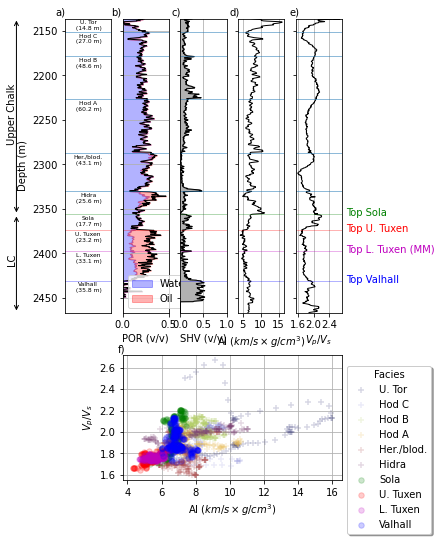

In [8]:
# Define elastic logs
bo2['Vp'] = bo2['DT_edt']
bo2['Vs'] = bo2['DTS_edt']
bo2['AI'] = bo2['Vp'] /1000. * bo2['RHOZ_edt']
bo2['PS'] = bo2['Vp'] / bo2['Vs']


intf = np.array(bo2_fms["depth"])
Fstr = np.array(bo2_fms["fm name"])

# Crop reservoir interval
resSec = bo2[(bo2['DEPTH'] > bo2_fms.loc[bo2_fms['fm name'] == 'U. Tor']['depth'][0]) &
             (bo2['DEPTH'] < bo2_fms.loc[bo2_fms['fm name'] == 'B. Valhall']['depth'][0])]


#resSec = bo2[(bo2['DEPTH'] >= float(top_hidra)) & (bo2['DEPTH'] < float(top_valhall)+30)]
# Subdivide reservoir into ("0") Upper shale zone 1, ("1") Upper shale zone 2, ("2") clean reservoir zone, and ("3") shaly reservoir zone
resSec['F'] = np.zeros(len(resSec))
resSec['F_label'] = ["" for x in range(len(resSec))]

#Removing zeros in the bottom of the Valdemar formation:
resSec = resSec.loc[resSec['AI'] != 0]

#resSec['F'].loc[(resSec['DEPTH'] < intf[0])] = 0
for i in range (len(intf)-1):
    if i == 0:
        resSec['F'].loc[(resSec['DEPTH'] > intf[0]) & (resSec['DEPTH'] <= intf[1])] = 0;
        resSec['F'].loc[(resSec['DEPTH'] >= intf[0]) & (resSec['DEPTH'] <= intf[1])] = 1;
        resSec['F_label'].loc[(resSec['DEPTH'] <= intf[0])] = Fstr[0];
        resSec['F_label'].loc[(resSec['DEPTH'] >= intf[0]) & (resSec['DEPTH'] <= intf[1])] = Fstr[0];
    else:
        resSec['F'].loc[(resSec['DEPTH'] >= intf[i]) & (resSec['DEPTH'] <= intf[i+1])] = i+1;
        resSec['F_label'].loc[(resSec['DEPTH'] >= intf[i]) & (resSec['DEPTH'] <= intf[i+1])] = Fstr[i];

dz = []
for m in range(1,len(Fstr)+1):
    dz.append(resSec[resSec['F']==m]['DEPTH'].diff().sum())

fig = plt.figure(figsize=set_size(width, subplots=(5,2)))
#fig, ax = plt.subplots(10, 8, figsize=set_size(width, subplots=(10, 8)))
#fig.tight_layout(pad=2)
fig.tight_layout
gs1 = gridspec.GridSpec(nrows=12, ncols=6, figure=fig,hspace =0 ,wspace=0.25)#,width_ratios=np.array([.5,.5,.5,.5,.5,.5,.5]))
ax0 = fig.add_subplot(gs1[0:7, 0])
ax1 = fig.add_subplot(gs1[0:7, 2])
ax2 = fig.add_subplot(gs1[0:7, 3])
ax3 = fig.add_subplot(gs1[0:7, 4])
ax4 = fig.add_subplot(gs1[0:7, 5])

ax5 = fig.add_subplot(gs1[8:11, 2:6])

ax6 = fig.add_subplot(gs1[0:7, 1])
#ax0 = plt.subplot2grid((12,8), (0,0), colspan=1, rowspan=12)
#ax1 = plt.subplot2grid((12,8), (0,1), colspan=1, rowspan=12)
#ax2 = plt.subplot2grid((12,8), (0,2), colspan=1, rowspan=12) 
#ax3 = plt.subplot2grid((12,8), (0,3), colspan=1, rowspan=12) 
#ax4 = plt.subplot2grid((12,8), (0,4), colspan=1, rowspan=12) 
#ax5 = plt.subplot2grid((12,8), (0,5), colspan=3, rowspan=7)
#ax6 = plt.subplot2grid((9,8), (0,6), colspan=2, rowspan=3)
#ax0 = plt.subplot2grid((7,7), (0,0), colspan=1, rowspan=7) 


# Porosity
x1 = resSec['PHIE']*(1-resSec['SW_CRETSYS'])
x2 = resSec['PHIE']*resSec['SW_CRETSYS']


ax0.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax0.invert_yaxis()
for pos, spine in ax0.axes.spines.items():
    spine.set_visible(False)
ax0.set_xticks([])
ax0.set_yticks([])

ax6.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax6.invert_yaxis()
for pos, spine in ax0.axes.spines.items():
    spine.set_visible(False)
ax6.set_xticks([])
#ax6.set_yticks([])


x_offset = 0.2
ax0.annotate('',xy=(x_offset,bo2_fms.loc[bo2_fms['fm name'] == 'Sola']['depth'][0]),xytext=(x_offset, np.min(resSec['DEPTH'])),
            arrowprops=dict(facecolor='black',arrowstyle='<->', linewidth=1),)

ax0.annotate('',xy=(x_offset,np.max(resSec['DEPTH'])),xytext=(x_offset, bo2_fms.loc[bo2_fms['fm name'] == 'Sola']['depth'][0]),
            arrowprops=dict(facecolor='black',arrowstyle='<->', linewidth=1),)

ax0.text(x = x_offset-0.2 , y = (np.min(resSec['DEPTH']) + bo2_fms.loc[bo2_fms['fm name'] == 'Sola']['depth'][0]) / 2 + 30,  s = 'Upper Chalk', weight='normal', rotation = -270)
ax0.text(x =x_offset-0.2, y =  (np.max(resSec['DEPTH']) + bo2_fms.loc[bo2_fms['fm name'] == 'Sola']['depth'][0]) / 2 ,  s = 'LC', weight='normal', rotation = -270)

    
ax1.fill_betweenx(resSec['DEPTH'],x2,0, alpha=0.3,color='b',label='Water')
ax1.fill_betweenx(resSec['DEPTH'],x2,resSec['PHIE'], alpha=0.3,color='r',label='Oil')
ax1.plot(resSec['PHIE'],resSec['DEPTH'],'k-', lw = 1,label='')
ax1.axis('tight')
ax1.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax1.invert_yaxis()
ax1.set_xlim(0,0.5)
ax1.set_xlabel('POR (v/v)' )
ax1.grid()
ax1.set_xticks(np.array([0, 0.5]))
ax1.legend(loc=0)
ax1.set_yticklabels('')
#ax1.yaxis.set_label_coords(-0.43, .5)


# Shale volume
ax2.fill_between(resSec['VSHALE'],resSec['DEPTH'], color='k', step="pre", alpha=0.3)
ax2.plot(resSec['VSHALE'],resSec['DEPTH'],'k-', lw = 1)
ax2.axis('tight')
ax2.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax2.invert_yaxis()
ax2.set_xlim(0,1)
ax2.set_xlabel('SHV (v/v)' )
#ax2.set_ylabel('Depth (m)' )
ax2.set_yticklabels('')
ax2.set_xticks(np.array([0, 0.5, 1]))
ax2.grid(axis='x')

# AI
ax3.plot(resSec['AI']/1000.,resSec['DEPTH'],'k-', lw = 1)
ax3.axis('tight')
ax3.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax3.invert_yaxis()
ax3.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$' )
ax3.set_yticklabels('')
ax3.grid(axis='x')

# Vp/Vs
ax4.plot(resSec['PS'],resSec['DEPTH'],'k-', lw = 1)
ax4.axis('tight')
ax4.set_ylim(np.min(resSec['DEPTH']),np.max(resSec['DEPTH']))
ax4.invert_yaxis()
ax4.set_xlabel(r'$V_p/V_s$' )
ax4.set_yticklabels('')
ax4.grid(axis='x')
ax4.set_xticks(np.array([1.6, 2, 2.4]))

for n in range(0,len(intf)-5):
    ax1.axhline(y = intf[n], lw = 1, linestyle = '-',
                   alpha = 0.5)    
    ax2.axhline(y = intf[n], lw = 1, linestyle = '-',
                   alpha = 0.5)
    ax3.axhline(y = intf[n], lw = 1, linestyle = '-',
                   alpha = 0.5)
    ax4.axhline(y = intf[n], lw = 1, linestyle = '-',
                   alpha = 0.5)
    ax6.axhline(y = intf[n], lw = 1, linestyle = '-',
                   alpha = 0.5)
    
ax1.axhline(intf[6], color = 'green', lw=1,   alpha=0.3)
ax1.axhline(intf[7], color = 'red',   lw=1,   alpha=0.3)
ax1.axhline(intf[8], color = 'm',     lw=1,   alpha=0.3)
ax1.axhline(intf[9], color = 'blue',  lw=1,   alpha=0.3)
ax2.axhline(intf[6], color = 'green', lw=1,   alpha=0.3)
ax2.axhline(intf[7], color = 'red',   lw=1,   alpha=0.3)
ax2.axhline(intf[8], color = 'm',     lw=1,   alpha=0.3)
ax2.axhline(intf[9], color = 'blue',  lw=1,   alpha=0.3)
ax3.axhline(intf[6], color = 'green', lw=1,   alpha=0.3)
ax3.axhline(intf[7], color = 'red',   lw=1,   alpha=0.3)
ax3.axhline(intf[8], color = 'm',     lw=1,   alpha=0.3)
ax3.axhline(intf[9], color = 'blue',  lw=1,   alpha=0.3)
ax4.axhline(intf[6], color = 'green', lw=1,   alpha=0.3, label = 'Top Sola')
ax4.axhline(intf[7], color = 'red',   lw=1,   alpha=0.3, label = 'Top U. Tuxen')
ax4.axhline(intf[8], color = 'm',     lw=1,   alpha=0.3, label = 'Top L. Tuxen')
ax4.axhline(intf[9], color = 'blue',  lw=1,   alpha=0.3, label = 'Top Valhall')


ax6.set_ylabel('Depth (m)' )
ax6.axhline(intf[6], color = 'green', lw=1,   alpha=0.3)#, label = 'Top Sola')
ax6.axhline(intf[7], color = 'red',   lw=1,   alpha=0.3)#, label = 'Top U. Tuxen')
ax6.axhline(intf[8], color = 'm',     lw=1,   alpha=0.3)#, label = 'Top L. Tuxen')
ax6.axhline(intf[9], color = 'blue',  lw=1,   alpha=0.3)#, label = 'Top Valhall')   
for i in range(len(Fstr)-1):
    ax6.text(x = ax6.set_xlim()[0]+0.5, y =intf[i]+8, s = Fstr[i]+'\n ({0} m)'.format(str(round(dz[i],1))),
            fontsize = 6,
            horizontalalignment = 'center',
            verticalalignment = 'center',
            #bbox = dict(facecolor = 'white', lw = 0.5),
            weight = 'light',
            rotation=0)

groups = resSec['F_label'].unique();

cmap_dummy = np.array(['green','red','m','blue']);
k=0;
import pylab;
NUM_COLORS = 6
#
cm = pylab.get_cmap('tab20b');
#for i in range(NUM_COLORS):
#    color = cm(1.*i/NUM_COLORS)  # color will now be an RGBA tuple


marker_size = 30

for i in range(len(groups)-4):
    x, y = (resSec[resSec['F_label']==groups[i]]['AI']/1000.,resSec[resSec['F_label']==groups[i]]['PS']);
    col = cm(1.*i/NUM_COLORS)  # color will now be an RGBA tuple
    ax5.scatter(x, y, alpha=0.2, s=marker_size, label=groups[i], color=col,marker = '+');
for i in range(6,len(groups)):
    x, y = (resSec[resSec['F_label']==groups[i]]['AI']/1000.,resSec[resSec['F_label']==groups[i]]['PS']);
    ax5.scatter(x, y, alpha=0.2, s=marker_size, label=groups[i], color = cmap_dummy[k]);
    k=k+1
        
ax5.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$' );
ax5.set_ylabel(r'$V_p/V_s$' );
ax5.grid();
ax5.set_axisbelow(True);
lg = ax5.legend(bbox_to_anchor=(1.0, 0.95),title='Facies',fancybox=True,shadow=True)



ax6.text(x = ax6.get_xlim()[0]-0.2, y = ax6.get_ylim()[1]-4,  s = 'a)', weight='normal')
ax1.text(x = ax1.get_xlim()[0]-0.12, y = ax1.get_ylim()[1]-4,  s = 'b)', weight='normal')
ax2.text(x = ax2.get_xlim()[0]-0.2, y =  ax2.get_ylim()[1]-4,  s = 'c)', weight='normal')
ax3.text(x = ax3.get_xlim()[0]-2.5, y =  ax3.get_ylim()[1]-4,  s = 'd)', weight='normal')
ax4.text(x = ax4.get_xlim()[0]-0.17, y = ax4.get_ylim()[1]-4  ,  s = 'e)', weight='normal')
ax5.text(x = ax5.get_xlim()[0]-0.3, y = ax5.get_ylim()[1]+0.02  ,  s = 'f)', weight='normal')



ax4.text(x = ax4.get_xlim()[1]+0.1, y = intf[6]+2,  s = 'Top Sola', weight='normal', color = 'green')
ax4.text(x = ax4.get_xlim()[1]+0.1, y = intf[7]+2,  s = 'Top U. Tuxen', weight='normal', color = 'red')
ax4.text(x = ax4.get_xlim()[1]+0.1, y = intf[8]+2,  s = 'Top L. Tuxen (MM)', weight='normal', color = 'm')
ax4.text(x = ax4.get_xlim()[1]+0.1, y = intf[9]+2,  s = 'Top Valhall', weight='normal', color = 'blue')





if savefig == True:
    plt.savefig(fig_path+'welllogs.svg',format='svg', bbox_inches='tight')
    print('FIGURE SAVED')
plt.show()

# Blocky model input

In [9]:
###########################################################
#       DEFINE MODELING PARAMETERS HERE

vp_mod = resSec.groupby('F').mean()['Vp'].values  # P-wave velocity (m/s)
vs_mod = resSec.groupby('F').mean()['Vs'].values   # S-wave velocity (m/s)
rho_mod = resSec.groupby('F').mean()['RHOZ_edt'].values   # Density
lit_mod = resSec.groupby('F').mean()['VSHALE'].values   # Shale
phi_mod = resSec.groupby('F').mean()['PHIE'].values   # Density
sw_mod = resSec.groupby('F').mean()['SW_CRETSYS'].values

thickness = np.round(dz,1)[1:-1] # vertical thickness of layer 2 in metres

#   Angle range for incident rays
theta1_min = 0.0    # best to leave this set to zero
theta1_max = 40.0
theta1_step= 1.0


# TWT-Depth Curve (from BO-2X checkshot)

C:\Users\mlo\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


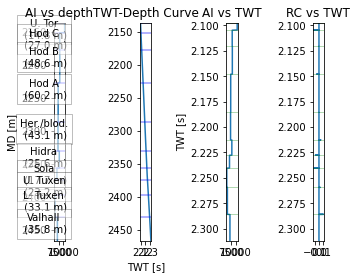

In [10]:
resSec['DPTM'].min()

tmin = resSec['DPTM'].min()
tmax = resSec['DPTM'].max()

md_min = resSec['DEPTH'].min()   #BO2X_checkshot['MD'].loc[BO2X_checkshot['MD'] >= resSec['DEPTH'].min()].min()
md_max = resSec['DEPTH'].max()

#   Plotting Display Parameters
#min_plot_time = tmin
#max_plot_time = tmax
excursion = 2

resSec['vp_mod']  = 0
resSec['vp_mod']  = 0
resSec['vs_mod']  = 0
resSec['rho_mod'] = 0
resSec['lit_mod'] = 0
resSec['phi_mod'] = 0
resSec['ai_mod'] = 0
resSec['sw_mod'] = 0

for i in range (len(intf)-1):
    if i == 0:
        resSec['vp_mod'].loc[(resSec['DEPTH']  > intf[0]) &  (resSec['DEPTH'] <= intf[1])] =  vp_mod[0]
        resSec['vs_mod'].loc[(resSec['DEPTH']  > intf[0]) &  (resSec['DEPTH'] <= intf[1])] =  vs_mod[0]
        resSec['rho_mod'].loc[(resSec['DEPTH'] > intf[0]) &  (resSec['DEPTH'] <= intf[1])] = rho_mod[0]
        resSec['lit_mod'].loc[(resSec['DEPTH'] > intf[0]) &  (resSec['DEPTH'] <= intf[1])] = lit_mod[0]
        resSec['phi_mod'].loc[(resSec['DEPTH'] > intf[0]) &  (resSec['DEPTH'] <= intf[1])] = phi_mod[0]
        resSec['sw_mod'].loc[(resSec['DEPTH'] > intf[0]) &  (resSec['DEPTH'] <= intf[1])] = sw_mod[0] 
        
    else:
        resSec['vp_mod'].loc[(resSec['DEPTH']  >= intf[i]) &  (resSec['DEPTH'] <= intf[i+1])] =  vp_mod[i]
        resSec['vs_mod'].loc[(resSec['DEPTH']  >= intf[i]) &  (resSec['DEPTH'] <= intf[i+1])] =  vs_mod[i]
        resSec['rho_mod'].loc[(resSec['DEPTH'] >= intf[i]) &  (resSec['DEPTH'] <= intf[i+1])] = rho_mod[i]
        resSec['lit_mod'].loc[(resSec['DEPTH'] >= intf[i]) &  (resSec['DEPTH'] <= intf[i+1])] = lit_mod[i]
        resSec['phi_mod'].loc[(resSec['DEPTH'] >= intf[i]) &  (resSec['DEPTH'] <= intf[i+1])] = phi_mod[i]
        resSec['sw_mod'].loc[(resSec['DEPTH'] >= intf[i]) &  (resSec['DEPTH'] <= intf[i+1])] = sw_mod[i]

        
resSec['ai_mod'] = resSec['vp_mod']/1000. * resSec['rho_mod']       

Z = np.array(resSec['ai_mod'])
RC = (Z[1:] - Z[:-1]) / (Z[1:] + Z[:-1])
RC_dummy = np.zeros(RC.size+1)
RC_dummy[:-1] = RC

resSec['RC'] = RC_dummy


def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx


tops_idx = np.zeros([intf.size])

tops_twt =  np.array([2083,2090,2106,2133,2171,2198,2213,2226, 2244,2272,2405])/1000.

for i in range(intf.size):
    #twt_idx[i] = find_nearest(np.array(resSec['DPTM']), tops_twt[i])
    tops_idx[i] = find_nearest(np.array(resSec['DEPTH']), intf[i])
    
#twt_idx = np.array(twt_idx, dtype = 'int')
tops_idx = np.array(tops_idx, dtype = 'int')

#tops_twt = np.array(resSec['DPTM'])[twt_idx]
dummy_twt = np.zeros(intf.size)
dummy_twt[0] = tmin
dummy_twt[-1] = tmax
twt_idx = np.nonzero(np.array(resSec['RC']))
tops_twt = np.array(resSec['DPTM'])[twt_idx]
dummy_twt[1:-1] = tops_twt
tops_twt = dummy_twt
t_plot_twt = np.array(resSec['DPTM'])

fig = plt.figure(figsize=set_size(width, subplots=(2, 2)))

plt.subplot(151)
plt.plot(resSec['ai_mod'] , resSec['DEPTH'])
plt.ylim(md_max,md_min)
for n in range(0,len(intf)):
    plt.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.3)  
for i in range(len(Fstr)-1):
    plt.text(x = 2.35, y =intf[i]+10, s = Fstr[i]+'\n ({0} m)'.format(str(round(dz[i],1))),
        fontsize = '10',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=0)
plt.title('AI vs depth')
plt.ylabel('MD [m]')    
    
plt.subplot(152)
plt.plot(resSec['DPTM'],resSec['DEPTH'])
#plt.plot(t_plot_twt1/1000.,checkshot_depthrange[:-1])
plt.ylim(md_max,md_min);
plt.xlabel('TWT [s]')
plt.title('TWT-Depth Curve')
#np.arange()
for n in range(0,len(intf)):
    plt.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.3)    
    
plt.subplot(153)
plt.plot(resSec['ai_mod'] ,resSec['DPTM'])
plt.ylim(tmax, tmin)
plt.title('AI vs TWT')
plt.ylabel('TWT [s]')
for i in range (tops_twt.size):
    plt.axhline(tops_twt[i], color='green', lw=1, alpha = 0.3)

plt.subplot(154)
plt.title('RC vs TWT')
plt.plot(resSec['RC'] ,resSec['DPTM'])
#plt.yticklabels('')
plt.ylim(tmax, tmin)
for i in range (tops_twt.size):
    plt.axhline(tops_twt[i], color='green', lw=1, alpha = 0.3)
plt.tight_layout(pad=.1)


# Function definitions

# Computations

In [11]:

#   Wavelet Parameters
wvlt_type = 'ricker'  # Valid values: 'ricker' or 'bandpass'
wvlt_length= 0.200 # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 24.0  # Ricker wavelet central frequency
dt =  0.0001 
def ricker(duration, dt, f, return_t=False):
    """
    Also known as the mexican hat wavelet, models the function:
    
    .. math::
        A =  (1 - 2 \pi^2 f^2 t^2) e^{-\pi^2 f^2 t^2}

    If you pass a 1D array of frequencies, you get a wavelet bank in return.

    Args:
        duration (float): The length in seconds of the wavelet.
        dt (float): The sample interval in seconds (often one of  0.001, 0.002,
            or 0.004).
        f (ndarray): Centre frequency of the wavelet in Hz. If a sequence is
            passed, you will get a 2D array in return, one row per frequency.
        return_t (bool): If True, then the function returns a tuple of
            wavelet, time-basis, where time is the range from -duration/2 to
            duration/2 in steps of dt.

    Returns:
        ndarray. Ricker wavelet(s) with centre frequency f sampled on t.

    .. plot::

        plt.plot(bruges.filters.ricker(.5, 0.002, 40))
     
    """
    f = np.asanyarray(f).reshape(-1, 1)
    t = np.arange(-duration/2, duration/2, dt)
    pft2 = (np.pi * f * t)**2
    w = np.squeeze((1 - (2 * pft2)) * np.exp(-pft2))

    if return_t:
        RickerWavelet = namedtuple('RickerWavelet', ['amplitude', 'time'])
        return RickerWavelet(w, t)
    else:
        return w
    
ricker(wvlt_length, dt, wvlt_cfreq)

array([-2.30538126e-23, -2.57762463e-23, -2.88168373e-23, ...,
       -3.22123703e-23, -2.88168373e-23, -2.57762463e-23])

# AVO synthetic plotting (Lower Cretaceous)

# CDP Gather @ BO-2X and Synth. AVO Comparison (RICKER)

In [12]:
il_bo2 = 8368  # @ BO-2X Inline position

path_segy = 'C:/Users/mlo/Locreta_proj_Mads_localtest.prj/seismic.dir/'


file = 'valdemar2016_5-35deg.sgy'


with segyio.open(path_segy + file, iline=189) as f: # iline=189 , xline=189
    #print(f.offsets)
    #print(f.ilines)
    #print(f.xlines)
    #print(f.trace[1 ])
    offsets = f.offsets
    gather_bo2 = np.asarray([np.copy(x) for x in f.iline[il_bo2,:]])

print(gather_bo2.shape)
    
gather_bo2 = -gather_bo2[:,6,:]  #minus sign to shift polarity to reverse/EU polarity

# Trimming traces to reservoir zone:
time = np.arange(1.5,3.004,0.004)
t_start = tmin
index_start = (np.abs(time-t_start)).argmin()
t_stop = tmax
index_stop = (np.abs(time-t_stop)).argmin()

#print(gather_bo2.shape, time.shape)

gather_bo2 = gather_bo2[:,index_start:index_stop]
#gather_exp = gather_exp[:,index_start:index_stop]
print(index_start,index_stop)
print(tmin, tmax)
print(time[index_start], time[index_stop])

(3, 176, 376)
149 203
2.0975144 2.3120608000000002
2.0960000000000005 2.3120000000000007


<a id='wavelets'></a>

# Wavelet Investigation

In [13]:
 
# Wavelets (time domain)
wavelet_str = 'wavelets_SW_RW_BO2X_2016.txt'
#amplitude_str = 'wavelet_CP_stat107_freq_amp.txt'
#for i in range (len(wavelet_str)):
data = pd.read_csv(path_wvlt+wavelet_str, sep ='\t',encoding='utf-8',skiprows=0)
data = np.asarray(data, dtype=float)
wavelet_seismic = data[:,1:6:2]
wavelet_well = data[:,7:12:2]
#wavelet_rw = data[:,19:24:2]
#k = np.array([1,2,3,0]) #re-arrange array to order the angles (only for seismic wavelet)
wavelet_seismic

array([[ 6.6338000e+00,  5.9751000e+00,  3.5303000e+00],
       [ 1.2867200e+01,  3.7596000e+00, -5.4502000e+00],
       [-4.3457300e+01, -4.1788800e+01, -3.0052100e+01],
       [-1.0193250e+02, -9.2798800e+01, -5.5002500e+01],
       [-1.4076500e+02, -1.3647240e+02, -9.0004400e+01],
       [-1.3095160e+02, -1.3174510e+02, -9.9478700e+01],
       [-3.7486400e+01, -3.8421900e+01, -3.3206400e+01],
       [ 1.3205930e+02,  1.3832970e+02,  1.4623670e+02],
       [ 3.2579920e+02,  3.6128450e+02,  4.0995050e+02],
       [ 5.9077720e+02,  6.3587920e+02,  7.0156900e+02],
       [ 9.0659300e+02,  9.3602930e+02,  9.6066650e+02],
       [ 1.1950463e+03,  1.1654215e+03,  1.0368040e+03],
       [ 1.0387043e+03,  8.7595730e+02,  5.1814970e+02],
       [-4.8962570e+02, -6.9334720e+02, -1.0097352e+03],
       [-3.4947412e+03, -3.4050635e+03, -3.1760444e+03],
       [-5.3461689e+03, -4.9635049e+03, -4.3182871e+03],
       [-3.4947407e+03, -3.4050630e+03, -3.1760439e+03],
       [-4.8962490e+02, -6.9334

FIGURE SAVED


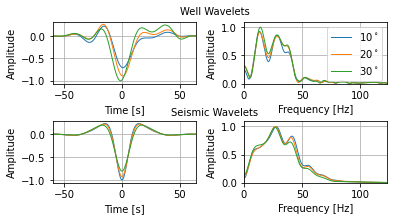

In [14]:
wavelet_seismic = data[:,1:6:2]
wavelet_well = data[:,7:12:2]
# Wavelets (time domain)
#wavelet_str = 'seis_rw_fw_time_amp.txt'
#amplitude_str = 'wavelet_CP_stat107_freq_amp.txt'
#for i in range (len(wavelet_str)):
#data = pd.read_csv(path_wvlt+wavelet_str, sep ='\t',encoding='utf-8')
#data = np.asarray(data, dtype=float)

#dummy= np.zeros([data.shape[0]+1,data.shape[1]])
#dummy[1:,:] = data
#dummy[0,:] = np.array([-64.0000, -12.5062, -64.0000, -12.3317, -64.0000 , -14.2073, -64.0000,-14.0446,-64.0000,-0.0000,-64.0000,0.0002,-64.0000,0.0002,-64.0000,-0.0001,-64.0000,-0.0001,-64.0000,0.0000,-64.0000,0.0000,-64.0000,-0.0002])

#data=dummy

#wavelet_seismic = data[:,1:8:2]
#wavelet_well = data[:,9:17:2]
#wavelet_well = data[:,17:24:2]
k = np.array([0,1,2]) #re-arrange array to order the angles

# Wavelets (amplitude-frequency domain)
freq_amp_str='wavelets_freq_amp.txt'
data_amp = pd.read_csv(path_wvlt+freq_amp_str)
data_amp = np.asarray(data_amp, dtype=float)
data_amp = np.squeeze(data_amp)
data_dummy = np.zeros(data_amp.size + 1)
data_dummy[1:] = data_amp
data_amp = data_dummy
data_amp = np.reshape(data_amp,[16,65])
seis_amp = data_amp[1:8:2,:]
freq = data_amp[0,:]
well_amp = data_amp[9::2,:]
#well_freq = data_amp[8::2,:]

# Interpolations
dx=1280
dummy_well = np.zeros([dx,wavelet_well.shape[1]]) 
dummy_seismic = np.zeros([dx,wavelet_well.shape[1]]) 

dummy_seis_amp = np.zeros([dx,data_amp.shape[1]])
dummy_well_amp = np.zeros([dx,data_amp.shape[1]])


x =         np.linspace(data[0,0],data[-1,0],num=np.int(data.shape[0]))
xnew =      np.linspace(data[0,0],data[-1,0],num=np.int(dx))
wavelet_t = np.linspace(data[0,0],data[-1,0],num=xnew.size)


#x = np.linspace(-,0.1,num=data.shape[0])
#xnew = np.linspace(-0.1,0.1,num=dx)

xnew_freq = np.linspace(freq.min(),freq.max(),num=dx)


for i in range(wavelet_well.shape[1]):
    # Wavelets (time domain)
    y = wavelet_well[:,i] 
    f = interpolate.splrep(x, y,s=0)
    dummy_well[:,i] = interpolate.splev(xnew, f,der=0) #use interpolation function returned by `interp1d`
    
    y = wavelet_seismic[:,i] 
    f = interpolate.splrep(x, y,s=0)
    dummy_seismic[:,k[i]] = interpolate.splev(xnew, f,der=0) #use interpolation function returned by `interp1d`
    
    # Wavelets (amplitude-frequency domain)
    y = seis_amp[i,:] 
    f = interpolate.splrep(freq, y,s=0)
    dummy_seis_amp[:,k[i]] = interpolate.splev(xnew_freq, f,der=0) #use interpolation function returned by `interp1d`
    
    y = well_amp[i,:] 
    f = interpolate.splrep(freq, y,s=0)
    dummy_well_amp[:,i] = interpolate.splev(xnew_freq, f,der=0) #use interpolation function returned by `interp1d`
    
    
    
wavelet_well = dummy_well
wavelet_seismic = dummy_seismic


seis_amp = dummy_seis_amp
well_amp = dummy_well_amp

wavelet_well =  wavelet_well/np.abs(wavelet_well).max()
wavelet_seismic =  wavelet_seismic/np.abs(wavelet_seismic).max()

seis_amp = seis_amp/np.abs(seis_amp).max()
well_amp = well_amp/np.abs(well_amp).max()

#fig = plt.figure(figsize=(14, 10))


fig = plt.figure(figsize=set_size(width, subplots=(4,5)))

fig.tight_layout
gs1 = gridspec.GridSpec(nrows=7, ncols=6, figure=fig,hspace =1 ,wspace=3)
ax0 = fig.add_subplot(gs1[0:3, 0:3])
ax1 = fig.add_subplot(gs1[0:3, 3:6])
ax2 = fig.add_subplot(gs1[4:7, 0:3])
ax3 = fig.add_subplot(gs1[4:7, 3:6])




wavelet_well.shape
for i in range(wavelet_well.shape[1]):
    ax0.plot(xnew,wavelet_well[:,i],lw=1)
    ax2.plot(xnew,wavelet_seismic[:,i],lw=1)
    
    ax1.plot(xnew_freq,well_amp[:,i], lw=1)
    ax3.plot(xnew_freq,seis_amp[:,i],lw=1)
ax1.legend( ['10$^\circ$','20$^\circ$','30$^\circ$'])
ax0.grid(), ax1.grid(), ax2.grid(), ax3.grid();
ax1.set_ylim(0,1.1), ax3.set_ylim(0,1.1);
ax1.set_xlim(0,xnew_freq.max()), ax3.set_xlim(0,xnew_freq.max());
ax0.set_xlim(data[0,0],data[-1,0]), ax2.set_xlim(data[0,0],data[-1,0])

#ax0.set_xticks()

#ax0.set_title('Well Wavelet')
#ax2.set_title('Seismic Wavelet')

ax0.set_ylabel('Amplitude')
ax0.set_xlabel('Time [s]')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Amplitude')

ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude')
ax3.set_xlabel('Frequency [Hz]')
ax3.set_ylabel('Amplitude');


plt.figtext(0.5,0.95, "Well Wavelets", ha="center", va="top", color="k")
plt.figtext(0.5,0.48, "Seismic Wavelets", ha="center", va="top", color="k")
#plt.subplots_adjust(hspace = 0.4 )

if savefig == True:
    plt.savefig(fig_path+'wavelets_well_stat.svg',format='svg', bbox_inches='tight')
    print('FIGURE SAVED')
plt.show()


-64.0 64.0 1280.0
FIGURE SAVED


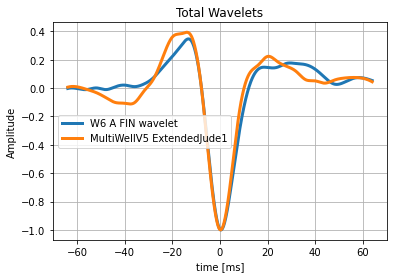

In [15]:
path_wavelets = 'M:/LOCRETA_WORKPACKAGE_D/Valdemar_sprint_well_data_Mads_L/DATA\seismic/Valdemar_4D_post-stack/'

wavelet_total1 = pd.read_csv(path_wavelets+'W6_A_FIN_wavelet_0_0_deg_awos.wvl',skiprows=0)
wavelet_total1 = np.squeeze(np.array(wavelet_total1))
#print('shape=',wavelet_total1.shape)

wavelet_total2 = pd.read_csv(path_wavelets+'MultiWellV5_ExtendedJude1_used4inversion_wavelet_0_0_deg_awos.wvl',skiprows=0)
wavelet_total2 = np.squeeze(np.array(wavelet_total2))

print(-wavelet_total1[1]*wavelet_total1[2],wavelet_total1[1]*wavelet_total1[2],wavelet_total1[1]*wavelet_total1[2]*20)
x =         np.linspace(-wavelet_total1[1]*wavelet_total1[2],wavelet_total1[1]*wavelet_total1[2],num=np.int(wavelet_total1[0]))
xnew =      np.linspace(-wavelet_total1[1]*wavelet_total1[2],wavelet_total1[1]*wavelet_total1[2],num=np.int(wavelet_total1[1]*wavelet_total1[2]*20))
wavelet_t = np.linspace(-wavelet_total1[1]*wavelet_total1[2],wavelet_total1[1]*wavelet_total1[2],num=xnew.size)
y = wavelet_total1[3:]  # 0 = 6-12, 1 = 12-18, 2=18-24, 3=24-30 degrees 


f = interpolate.splrep(x, y,s=0)
wavelet_total1 = interpolate.splev(xnew, f,der=0) #use interpolation function returned by `interp1d`


#x = np.linspace(-0.1,0.1,num=wavelet_total2.shape[0])
#xnew = np.linspace(-0.1,0.1,num=2000)
y = wavelet_total2[3:]  # 0 = 6-12, 1 = 12-18, 2=18-24, 3=24-30 degrees 
f = interpolate.splrep(x, y,s=0)
wavelet_total2 = interpolate.splev(xnew, f,der=0) #use interpolation function returned by `interp1d`


wavelet_total1 =  wavelet_total1/np.abs(wavelet_total1).max()
wavelet_total2 =  wavelet_total2/np.abs(wavelet_total2).max()
plt.figure()
plt.title('Total Wavelets')
plt.plot(wavelet_t,wavelet_total1,lw=3, label = 'W6 A FIN wavelet')
plt.plot(wavelet_t,wavelet_total2,lw=3, label = 'MultiWellV5 ExtendedJude1')
plt.grid()
plt.ylabel('Amplitude')
plt.xlabel('time [ms]')
plt.legend()
if savefig == True:
    plt.savefig(fig_path+'wavelets_total.svg',format='svg', bbox_inches='tight')
    print('FIGURE SAVED')
plt.show()

-64.0 64.0 1280.0
FIGURE SAVED


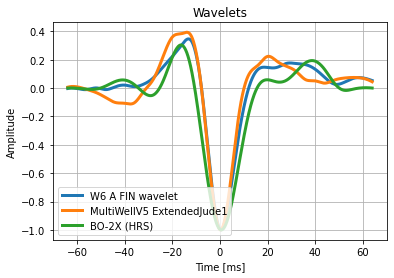

In [16]:
wavelet_total1 = pd.read_csv(path_wavelets+'W6_A_FIN_wavelet_0_0_deg_awos.wvl',skiprows=0)
wavelet_total1 = np.squeeze(np.array(wavelet_total1))
#print('shape=',wavelet_total1.shape)

wavelet_total2 = pd.read_csv(path_wavelets+'MultiWellV5_ExtendedJude1_used4inversion_wavelet_0_0_deg_awos.wvl',skiprows=0)
wavelet_total2 = np.squeeze(np.array(wavelet_total2))


wavelet_kenneth = pd.read_csv(path_wvlt+'BO2X_RW_2030_2300_Kenneth.txt',skiprows=0, header=None, sep='\t')
wavelet_kenneth = np.array(wavelet_kenneth)[:,1]


print(-wavelet_total1[1]*wavelet_total1[2],wavelet_total1[1]*wavelet_total1[2],wavelet_total1[1]*wavelet_total1[2]*20)
x =         np.linspace(-wavelet_total1[1]*wavelet_total1[2],wavelet_total1[1]*wavelet_total1[2],num=np.int(wavelet_total1[0]))
xnew =      np.linspace(-wavelet_total1[1]*wavelet_total1[2],wavelet_total1[1]*wavelet_total1[2],num=np.int(wavelet_total1[1]*wavelet_total1[2]*20))
wavelet_t = np.linspace(-wavelet_total1[1]*wavelet_total1[2],wavelet_total1[1]*wavelet_total1[2],num=xnew.size)
y = wavelet_total1[3:]  # 0 = 6-12, 1 = 12-18, 2=18-24, 3=24-30 degrees 


f = interpolate.splrep(x, y,s=0)
wavelet_total1 = interpolate.splev(xnew, f,der=0) #use interpolation function returned by `interp1d`


#x = np.linspace(-0.1,0.1,num=wavelet_total2.shape[0])
#xnew = np.linspace(-0.1,0.1,num=2000)
y = wavelet_total2[3:]  # 0 = 6-12, 1 = 12-18, 2=18-24, 3=24-30 degrees 
f = interpolate.splrep(x, y,s=0)
wavelet_total2 = interpolate.splev(xnew, f,der=0) #use interpolation function returned by `interp1d`


y = wavelet_kenneth
f = interpolate.splrep(x, y,s=0)
wavelet_kenneth = interpolate.splev(xnew, f,der=0) #use interpolation function returned by `interp1d`


wavelet_total1 =  wavelet_total1/np.abs(wavelet_total1).max()
wavelet_total2 =  wavelet_total2/np.abs(wavelet_total2).max()
wavelet_kenneth = wavelet_kenneth/np.abs(wavelet_kenneth).max()

plt.figure()
plt.title('Wavelets')
plt.plot(wavelet_t,wavelet_total1,lw=3, label = 'W6 A FIN wavelet')
plt.plot(wavelet_t,wavelet_total2,lw=3, label = 'MultiWellV5 ExtendedJude1')
plt.plot(wavelet_t,wavelet_kenneth,lw=3, label = 'BO-2X (HRS)')
plt.grid()
plt.ylabel('Amplitude')
plt.xlabel('Time [ms]')
plt.legend(loc=3)
if savefig == True:
    plt.savefig(fig_path+'wavelets_total_HRS.png',format='png', bbox_inches='tight')
    print('FIGURE SAVED')
plt.show()



<a id='blockymodel'></a>
# Blocky Model

In [17]:
#   Some handy constants
nlayers = len(vp_mod)
#nint = nlayers - 1
nangles = 35
dt =  0.0001 #np.diff(t_plot_twt)[0]#


#   Calculate reflectivities from model parameters

rc_zoep_pp = []
theta1 = []
dummy_rc = np.zeros([9,4,4])

for i in range(0,nangles):
    theta1_buf = i*theta1_step + theta1_min
    for i in range (vp_mod.size-1):
        dummy_rc[i,:,:] = mlo.rc_zoep(vp_mod[i], vs_mod[i], rho_mod[i], vp_mod[i+1], vs_mod[i+1], rho_mod[i+1], theta1_buf)
   
    theta1.append(theta1_buf)
    rc_zoep_pp.append((dummy_rc[0,0,0],dummy_rc[1,0,0],dummy_rc[2,0,0],
                      dummy_rc[3,0,0],dummy_rc[4,0,0],dummy_rc[5,0,0],
                      dummy_rc[6,0,0],dummy_rc[7,0,0],dummy_rc[8,0,0]))
    
rc_zoep_pp = np.array([rc_zoep_pp])

#rc_zoep_pp = np.array([rc_zoep_pp])
stack1 = np.squeeze(  np.sum(rc_zoep_pp[:,5:15,:],axis=1) / rc_zoep_pp[:,5:15,:].shape[2])
stack2 = np.squeeze(np.sum(rc_zoep_pp[:,15:25,:],axis=1) / rc_zoep_pp[:,15:25,:].shape[2])
stack3 = np.squeeze(np.sum(rc_zoep_pp[:,25:35,:],axis=1) / rc_zoep_pp[:,25:35,:].shape[2])
#stack4 = np.squeeze(np.sum(rc_zoep_pp[:,24:30,:],axis=1) / rc_zoep_pp[:,24:30,:].shape[2])



rc_zoep_pp = np.array([stack1,stack2,stack3])


    
syn_zoep_pp_well = [] 
syn_zoep_pp_seis = []
angle_dummy = np.array([5,15,25])
j=0
for angle in range(5, nangles,10):
        nlayers = len(rc_zoep_pp[j])
        nint = nlayers
        nsamp = len(t_plot_twt)
        rc = list(np.zeros(nsamp,dtype='float'))
        lyr = 0

        for i in range(0, nsamp):
            for k in range(0,tops_twt.size-1):
                if t_plot_twt[i] == tops_twt[k]:
                    rc[i] = rc_zoep_pp[j][k-1]
                if lyr > nint:
                    break
        #k=0
        #   Convolve wavelet with reflectivities
        
        syn_buf = np.convolve(rc, wavelet_well[:,j], mode='same')
        syn_buf = list(syn_buf)
        syn_zoep_pp_well.append(syn_buf)
        
        syn_buf_seis = np.convolve(rc, wavelet_seismic[:,j], mode='same')
        syn_buf_seis = list(syn_buf_seis)
        syn_zoep_pp_seis.append(syn_buf_seis)
        j=j+1
        #print("Calculated angle %i" % (angle))

#    Convert data arrays from lists/tuples to numpy arrays    
syn_zoep_pp_well = np.array(syn_zoep_pp_well)
syn_zoep_pp_seis = np.array(syn_zoep_pp_seis)
rc_zoep_pp = np.array(rc_zoep_pp)

#   Copy convolved top/base reflectivity values to Lists for easier plotting
[ntrc, nsamp] = syn_zoep_pp_well.shape
line1 = []
line2 = []
line3 = []
line4 = []
line5 = []
line6 = []
line7 = []
line8 = []
line9 = []
line10 = []

Yzoep = np.array(rc_zoep_pp[:,0])
Yzoep = Yzoep.reshape((ntrc, 1))

#Yconv = np.array(line1)
#Yconv = Yconv.reshape((ntrc, 1))
#
#ones = np.ones(ntrc)
#ones = ones.reshape((ntrc,1))

sintheta2 = np.sin(np.radians(np.arange(0, ntrc)))**2
sintheta2 = sintheta2.reshape((ntrc, 1))


tops_lines = np.zeros([tops_idx.size , syn_zoep_pp_well.shape[0]])    


for i in range(0, ntrc):
    line1.append(syn_zoep_pp_well[i,np.int(tops_idx[0])])
    line2.append(syn_zoep_pp_well[i,np.int(tops_idx[1])])
    line3.append(syn_zoep_pp_well[i,np.int(tops_idx[2])])
    line4.append(syn_zoep_pp_well[i,np.int(tops_idx[3])])
    line5.append(syn_zoep_pp_well[i,np.int(tops_idx[4])])
    line6.append(syn_zoep_pp_well[i,np.int(tops_idx[5])])
    line7.append(syn_zoep_pp_well[i,np.int(tops_idx[6])])
    line8.append(syn_zoep_pp_well[i,np.int(tops_idx[7])])
    line9.append(syn_zoep_pp_well[i,np.int(tops_idx[8])])     
    line10.append(syn_zoep_pp_well[i,np.int(tops_idx[9])])
    
line1=np.squeeze(np.array([line1]))
line2=np.squeeze(np.array([line2]))
line3=np.squeeze(np.array([line3]))
line4=np.squeeze(np.array([line4]))
line5=np.squeeze(np.array([line5]))
line6=np.squeeze(np.array([line6]))
line7=np.squeeze(np.array([line7]))
line8=np.squeeze(np.array([line8]))
line9=np.squeeze(np.array([line9]))
line10=np.squeeze(np.array([line10]))

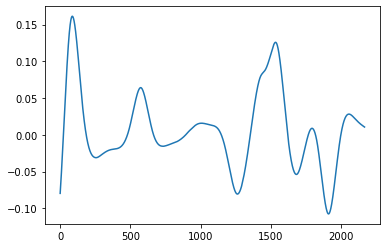

In [18]:
plt.plot(syn_zoep_pp_seis[0,:])

FIGURE SAVED


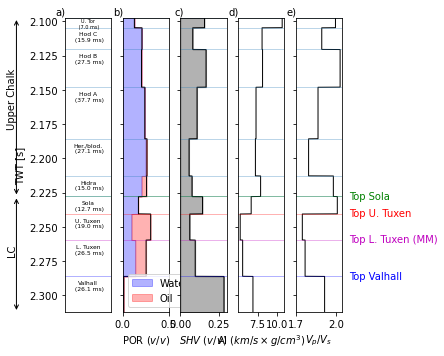

In [19]:
#fig, ax  = plt.subplots(1, 6, figsize=set_size(width, subplots=(3,2)))
fig = plt.figure(figsize=set_size(width, subplots=(5,2)))
#fig, ax = plt.subplots(10, 8, figsize=set_size(width, subplots=(10, 8)))
#fig.tight_layout(pad=2)
fig.tight_layout
gs1 = gridspec.GridSpec(nrows=12, ncols=6, figure=fig,hspace =0 ,wspace=0.25)#,width_ratios=np.array([.5,.5,.5,.5,.5,.5,.5]))
ax0 = fig.add_subplot(gs1[0:7, 0])
ax1 = fig.add_subplot(gs1[0:7, 2])
ax2 = fig.add_subplot(gs1[0:7, 3])
ax3 = fig.add_subplot(gs1[0:7, 4])
ax4 = fig.add_subplot(gs1[0:7, 5])

#ax5 = fig.add_subplot(gs1[8:12, 1:6])

ax6 = fig.add_subplot(gs1[0:7, 1])

ax6.set_ylim(t_plot_twt.min(),t_plot_twt.max())
ax6.invert_yaxis()
for pos, spine in ax0.axes.spines.items():
    spine.set_visible(False)
ax6.set_xticks([])
ax6.set_ylabel(r'TWT [s]')
ax6.axhline(tops_twt[6], color = 'green', lw=1,   alpha=0.3)#, label = 'Top Sola')
ax6.axhline(tops_twt[7], color = 'red',   lw=1,   alpha=0.3)#, label = 'Top U. Tuxen')
ax6.axhline(tops_twt[8], color = 'm',     lw=1,   alpha=0.3)#, label = 'Top L. Tuxen')
ax6.axhline(tops_twt[9], color = 'blue',  lw=1,   alpha=0.3)#, label = 'Top Valhall')   
    
    #thicnkess in ms
ds = np.round(np.diff(tops_twt)*1000.,1)

for i in range(len(Fstr)-1):
    if i == 0:
        ax6.text(x = .5, y =tops_twt[i]+0.004, s = Fstr[i]+'\n ({0} ms)'.format(str(ds[i])),
            fontsize = 5,
            horizontalalignment = 'center',
            verticalalignment = 'center',
            #bbox = dict(facecolor = 'white', lw = 0.5),
            weight = 'light',
            rotation=0)
    else:
        ax6.text(x = .5, y =tops_twt[i]+0.007, s = Fstr[i]+'\n ({0} ms)'.format(str(ds[i])),
            fontsize = 6,
            horizontalalignment = 'center',
            verticalalignment = 'center',
            #bbox = dict(facecolor = 'white', lw = 0.5),
            weight = 'light',
            rotation=0)
  
#ax8 = fig.add_subplot(1,14,5)

ax1.plot(resSec['phi_mod'] ,t_plot_twt,'k' ,lw=1)
ax1.set_ylim(tmax, tmin)
ax1.set_xlabel('POR ' + r'$(v/v)$')
#ax1.xaxis.set_label_position('bottom')

ax1.yaxis.set_label_coords(-0.37, .5)


x1 = resSec['phi_mod']*(1-resSec['sw_mod'])
x2 = resSec['phi_mod']*resSec['sw_mod']


ax1.fill_betweenx(t_plot_twt,x2,0, alpha=0.3,color='b',label='Water')
ax1.fill_betweenx(t_plot_twt,x2,resSec['phi_mod'], alpha=0.3,color='r',label='Oil')
#ax1.legend(loc=0)
ax1.set_xlim(0,0.5)
ax1.set_yticklabels('')
ax1.legend(loc=0)


#ax2 = ax1.twiny()  # instantiate a second axes that shares the same y-axis
ax2.plot(resSec['lit_mod'], t_plot_twt,'k',lw=1)
ax2.set_ylim(tmax, tmin)
ax2.set_xlabel(r'$SHV \ (v/v)$')
ax2.set_xlim(0,0.3)
ax2.set_yticklabels('')
ax2.fill_betweenx(t_plot_twt,0,resSec['lit_mod'], color='k', alpha=0.3)



#ax2.set_title('AI')
ax3.plot(resSec['ai_mod']/1000. ,t_plot_twt,'k' ,lw=1)
ax3.set_xlabel(r'AI $(km/s \times g/cm^3)$',  )
ax3.set_ylim(tmax, tmin)
ax3.set_yticklabels('')


#ax3.set_title('Vp/Vs')
ax4.plot(resSec['vp_mod']/resSec['vs_mod'], t_plot_twt,'k' ,lw=1)
ax4.set_ylim(tmax, tmin)
ax4.set_xlabel(r'$V_p/V_s$')
ax4.set_xticks(np.array([1.7,2]));
ax4.set_xticklabels(['1.7','2.0']);
ax4.set_yticklabels('')


for i in range (tops_twt.size-4):
    ax1.axhline(tops_twt[i],   lw=1, alpha = 0.3) 
    ax2.axhline(tops_twt[i],   lw=1, alpha = 0.3)  
    ax3.axhline(tops_twt[i],   lw=1, alpha = 0.3) 
    ax4.axhline(tops_twt[i],   lw=1, alpha = 0.3)  
    ax6.axhline(tops_twt[i],   lw=1, alpha = 0.3)                 

                
ax1.axhline(tops_twt[6], color = 'green', lw=1,   alpha=0.3)
ax1.axhline(tops_twt[7], color = 'red'  , lw=1,   alpha=0.3)
ax1.axhline(tops_twt[8], color = 'm',     lw=1,   alpha=0.3)
ax1.axhline(tops_twt[9], color = 'blue',  lw=1,   alpha=0.3)
ax2.axhline(tops_twt[6], color = 'green', lw=1,   alpha=0.3)
ax2.axhline(tops_twt[7], color = 'red',   lw=1,   alpha=0.3)
ax2.axhline(tops_twt[8], color = 'm',     lw=1,   alpha=0.3)
ax2.axhline(tops_twt[9], color = 'blue',  lw=1,   alpha=0.3)
ax3.axhline(tops_twt[6], color = 'green', lw=1,   alpha=0.3)
ax3.axhline(tops_twt[7], color = 'red',   lw=1,   alpha=0.3)
ax3.axhline(tops_twt[8], color = 'm',     lw=1,   alpha=0.3)
ax3.axhline(tops_twt[9], color = 'blue',  lw=1,   alpha=0.3)
ax4.axhline(tops_twt[6], color = 'green', lw=1,   alpha=0.3)
ax4.axhline(tops_twt[7], color = 'red',   lw=1,   alpha=0.3)
ax4.axhline(tops_twt[8], color = 'm',     lw=1,   alpha=0.3)
ax4.axhline(tops_twt[9], color = 'blue',  lw=1,   alpha=0.3)


ax0.set_ylim(np.min(t_plot_twt),np.max(t_plot_twt))
ax0.invert_yaxis()
for pos, spine in ax0.axes.spines.items():
    spine.set_visible(False)
ax0.set_xticks([])
ax0.set_yticks([])

x_offset = 0.2
ax0.annotate('',xy=(x_offset,tops_twt[6]),xytext=(x_offset, np.min(resSec['DPTM'])),
            arrowprops=dict(facecolor='black',arrowstyle='<->', linewidth=1),)

ax0.annotate('',xy=(x_offset,np.max(resSec['DPTM'])),xytext=(x_offset, tops_twt[6]),
            arrowprops=dict(facecolor='black',arrowstyle='<->', linewidth=1),)

ax0.text(x = x_offset-0.2 , y = (np.min(resSec['DPTM']) + tops_twt[6]) / 2 + 0.015,  s = 'Upper Chalk', weight='normal', rotation = -270)
ax0.text(x =x_offset-0.2, y =  (np.max(resSec['DPTM']) + tops_twt[6]) / 2 ,  s = 'LC', weight='normal', rotation = -270)
                       
ax6.text(x = ax6.get_xlim()[0]-0.2, y = ax6.get_ylim()[1]-0.0025,  s = 'a)', weight='normal')
ax1.text(x = ax1.get_xlim()[0]-0.1, y = ax1.get_ylim()[1]-0.0025,  s = 'b)', weight='normal')
ax2.text(x = ax2.get_xlim()[0]-0.04, y = ax2.get_ylim()[1]-0.0025,  s = 'c)', weight='normal')
ax3.text(x = ax3.get_xlim()[0]-1.2, y =  ax3.get_ylim()[1]-0.0025,  s = 'd)', weight='normal')
ax4.text(x = ax4.get_xlim()[0]-0.07, y =  ax3.get_ylim()[1]-0.0025,  s = 'e)', weight='normal')

ax4.text(x = ax4.get_xlim()[1]+0.05, y = tops_twt[6]+0.002,  s = 'Top Sola', weight='normal', color = 'green')
ax4.text(x = ax4.get_xlim()[1]+0.05, y = tops_twt[7]+0.002,  s = 'Top U. Tuxen', weight='normal', color = 'red')
ax4.text(x = ax4.get_xlim()[1]+0.05, y = tops_twt[8]+0.002,  s = 'Top L. Tuxen (MM)', weight='normal', color = 'm')
ax4.text(x = ax4.get_xlim()[1]+0.05, y = tops_twt[9]+0.002,  s = 'Top Valhall', weight='normal', color = 'blue')                                                

if savefig == True:
    plt.savefig(fig_path+'BO2X_block.svg',format='svg', bbox_inches='tight')
    print('FIGURE SAVED')
syn_zoep_cdp = syn_zoep_pp_well

In [20]:
syn_zoep_cdp_seis = syn_zoep_pp_seis#np.zeros([len(offsets),syn_zoep_pp_seis.shape[1]])
syn_zoep_cdp_well = syn_zoep_pp_well #np.zeros([len(offsets),syn_zoep_pp_well.shape[1]])
#
#il_bo2 = 8368  # @ BO-2X Inline position
#
#path_segy = 'C:/Users/mlo/Locreta_proj_Mads_localtest.prj/seismic.dir/'
#file = 'valdemar2016_AG1.sgy'
#
#
#with segyio.open(path_segy + file, iline=189) as f: # iline=189 , xline=189
#    #print(f.offsets)
#    #print(f.ilines)
#    #print(f.xlines)
#    offsets = f.offsets
#    gather_bo2 = np.asarray([np.copy(x) for x in f.iline[il_bo2,:]])
#
#gather_bo2 = -gather_bo2[:,np.argwhere(f.xlines==7926)[0][0],:]

#print(gather_bo2.shape)
#
#time = np.arange(1.5,3.004,0.004)
#t_start = tmin
#index_start = (np.abs(time-t_start)).argmin()
#t_stop = tmax
#index_stop = (np.abs(time-t_stop)).argmin()
#
#print(gather_bo2.shape, time.shape)

#gather_bo2 = gather_bo2[:,index_start:index_stop]
##gather_exp = gather_exp[:,index_start:index_stop]
#print(index_start,index_stop)
#print(tmin, tmax)
#print(time[index_start], time[index_stop])






#fig = plt.figure(figsize=set_size(width, subplots=(5,2)))
#fig.tight_layout
##gs1 = gridspec.GridSpec(nrows=12, ncols=6, figure=fig,hspace =1 ,wspace=0.25)#,width_ratios=np.array([.5,.5,.5,.5,.5,.5,.5]))
#plt.plot(gather_bo2[0,:],np.arange(tmin,tmax,0.004)*1000.)
#plt.gca().invert_yaxis()
##ax0 = fig.add_subplot(gs1[0:7, 0])
##mlo.plot_vawig(ax0, gather_bo2[0,:] , time_sm, 2)

In [21]:
    
#il_bo2 = 8368  # @ BO-2X Inline position
#
#path_segy = 'C:/Users/mlo/Locreta_proj_Mads_localtest.prj/seismic.dir/'
#file = 'valdemar2016_AG1.sgy'


with segyio.open(path_segy + file, iline=189) as f: # iline=189 , xline=189
    #print(f.offsets)
    #print(f.ilines)
    #print(f.xlines)
    offsets = f.offsets
    gather_bo2 = np.asarray([np.copy(x) for x in f.iline[il_bo2,:]])

gather_bo2 = gather_bo2[:,np.argwhere(f.xlines==7926)[0][0],:]


print(gather_bo2.shape)

# Trimming traces to reservoir zone:
time = np.arange(1.5,3.004,0.004)
t_start = tmin
index_start = (np.abs(time-t_start)).argmin()
t_stop = tmax
index_stop = (np.abs(time-t_stop)).argmin()

#print(gather_bo2.shape, time.shape)

gather_bo2 = gather_bo2[:,index_start:index_stop]
#gather_exp = gather_exp[:,index_start:index_stop]



time = np.linspace(t_start,t_stop,gather_bo2.shape[-1])
time_sm_corr = np.linspace(time.min(), time.max(), len(time)*10)
time_sm = np.linspace(tmin, tmax, len(time)*10)


gather_sm_bo2 = np.zeros([len(time_sm),gather_bo2.shape[0]])




for i in range(0,gather_bo2.shape[0]):
        gather_sm_bo2[:,i] = make_interp_spline(time,gather_bo2[i,:])(time_sm_corr)
        
        
        
########

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Install click and bruges with pip.
import click
import bruges as bg


def make_synthetic(size=256, top=0.4, base=0.6, value=1, freq=25, phase=0):
    """Make a synthetic. Return the wavelet, the model, the RC, and the synthetic.
    """
    v = np.ones(size) - value

    v[int(top*size):int(base*size)] = value
    rc = np.diff(v)

    w = bg.filters.ricker(0.256, 0.001, freq)

    if phase != 0:
        w = bg.filters.rotate_phase(w, phase, degrees=True)

    syn = np.convolve(rc, w, mode='same')
    return w, v, rc, syn

def get_colour(cmap, frac):
    """
    Decide whether to make white or black labels.
    """
    cmap = get_cmap(cmap)
    return 'k' if (np.mean(cmap(frac)[:3]) > 0.5) else 'w'

(3, 376)


In [22]:
print(time.shape, time_sm.shape, time_sm_corr.shape)

(54,) (540,) (540,)


In [23]:
time = np.arange(1.5,3.004,0.004)

<a id='AVOmodelling'></a>
# Synthetic vs Observed AVO Seismic

FIGURE SAVED


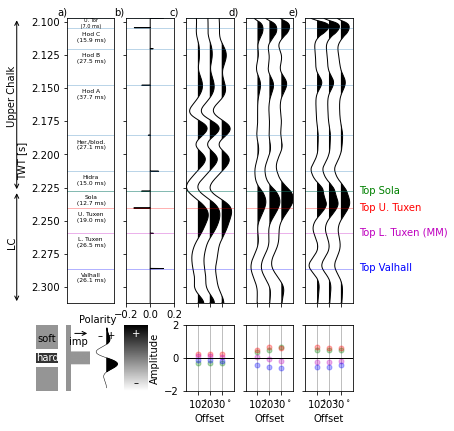

In [24]:
fig = plt.figure(figsize=set_size(width, subplots=(5,2)))
fig.tight_layout
gs1 = gridspec.GridSpec(nrows=12, ncols=6, figure=fig,hspace =1 ,wspace=0.25)#,width_ratios=np.array([.5,.5,.5,.5,.5,.5,.5]))

ax0 = fig.add_subplot(gs1[0:7, 0])
ax0.set_ylim(np.min(t_plot_twt),np.max(t_plot_twt))
ax0.invert_yaxis()
for pos, spine in ax0.axes.spines.items():
    spine.set_visible(False)
ax0.set_xticks([])
ax0.set_yticks([])

x_offset = 0.2
ax0.annotate('',xy=(x_offset,tops_twt[6]),xytext=(x_offset, np.min(resSec['DPTM'])),
            arrowprops=dict(facecolor='black',arrowstyle='<->', linewidth=1),)

ax0.annotate('',xy=(x_offset,np.max(resSec['DPTM'])),xytext=(x_offset, tops_twt[6]),
            arrowprops=dict(facecolor='black',arrowstyle='<->', linewidth=1),)

ax0.text(x = x_offset-0.2 , y = (np.min(resSec['DPTM']) + tops_twt[6]) / 2 + 0.015,  s = 'Upper Chalk', weight='normal', rotation = -270)
ax0.text(x =x_offset-0.2, y =  (np.max(resSec['DPTM']) + tops_twt[6]) / 2 ,  s = 'LC', weight='normal', rotation = -270)




ax6 = fig.add_subplot(gs1[0:7, 1])
ax6.set_ylim(t_plot_twt.min(),t_plot_twt.max())
ax6.invert_yaxis()
for pos, spine in ax0.axes.spines.items():
    spine.set_visible(False)
ax6.set_xticks([])
ax6.set_ylabel(r'TWT [s]')
ax6.axhline(tops_twt[6], color = 'green', lw=1,   alpha=0.3)#, label = 'Top Sola')
ax6.axhline(tops_twt[7], color = 'red',   lw=1,   alpha=0.3)#, label = 'Top U. Tuxen')
ax6.axhline(tops_twt[8], color = 'm',     lw=1,   alpha=0.3)#, label = 'Top L. Tuxen')
ax6.axhline(tops_twt[9], color = 'blue',  lw=1,   alpha=0.3)#, label = 'Top Valhall')   
    
    #thicnkess in ms
ds = np.round(np.diff(tops_twt)*1000.,1)

for i in range(len(Fstr)-1):
    if i == 0:
        ax6.text(x = .5, y =tops_twt[i]+0.004, s = Fstr[i]+'\n ({0} ms)'.format(str(ds[i])),
            fontsize = 5,
            horizontalalignment = 'center',
            verticalalignment = 'center',
            #bbox = dict(facecolor = 'white', lw = 0.5),
            weight = 'light',
            rotation=0)
    else:
        ax6.text(x = .5, y =tops_twt[i]+0.007, s = Fstr[i]+'\n ({0} ms)'.format(str(ds[i])),
            fontsize = 6,
            horizontalalignment = 'center',
            verticalalignment = 'center',
            #bbox = dict(facecolor = 'white', lw = 0.5),
            weight = 'light',
            rotation=0)

#ax0 = plt.subplot2grid((4,4), (0,0), colspan=1, rowspan=3) 
ax1 = fig.add_subplot(gs1[0:7, 2])
#ax1.set_title('RC (ZO)')
ax1.plot(rc ,t_plot_twt,'k' ,lw=1)
ax1.set_ylim(tmax, tmin)
#ax1.set_ylabel('TWT [s]')
ax1.set_yticklabels(['']);
ax1.set_xlim(-.2,.2)
ax1.axhline(tops_twt[6], color = 'green', lw=1,alpha = 0.3, label = 'Top Sola')
ax1.axhline(tops_twt[7], color = 'red',   lw=1,alpha = 0.3, label = 'Upper Tuxen')
ax1.axhline(tops_twt[8], color = 'm',     lw=1,alpha = 0.3, label = 'Lower Tuxen')
ax1.axhline(tops_twt[9], color = 'blue',  lw=1,alpha = 0.3, label = 'Top Valhall')


ax2 = fig.add_subplot(gs1[0:7, 3])


mlo.plot_vawig(ax2, gather_sm_bo2.T/1e3 , time_sm, 1)
ax2.set_ylim(t_plot_twt.min(),t_plot_twt.max())
ax2.axhline(tops_twt[6], color = 'green', lw=1,alpha = 0.3, label = 'Top Sola')
ax2.axhline(tops_twt[7], color = 'red',   lw=1,alpha = 0.3, label = 'Upper Tuxen')
ax2.axhline(tops_twt[8], color = 'm',     lw=1,alpha = 0.3, label = 'Lower Tuxen')
ax2.axhline(tops_twt[9], color = 'blue',  lw=1,alpha = 0.3, label = 'Top Valhall')
ax2.invert_yaxis()
#ax2.set_title('Observed CMP')
ax2.xaxis.tick_bottom()
ax2.set_yticklabels('')
ax2.set_xlim(-1,3)
ax2.set_xticks(np.array([0,1,2]));
ax2.set_xticklabels(['']);


ax3 = fig.add_subplot(gs1[0:7, 4])

mlo.plot_vawig(ax3, syn_zoep_cdp_well , t_plot_twt, 1)
ax3.set_ylim(t_plot_twt.min(),t_plot_twt.max())
ax3.axhline(tops_twt[6], color = 'green', lw=1,alpha = 0.3, label = 'Top Sola')
ax3.axhline(tops_twt[7], color = 'red',   lw=1,alpha = 0.3, label = 'Upper Tuxen')
ax3.axhline(tops_twt[8], color = 'm',     lw=1,alpha = 0.3, label = 'Lower Tuxen')
ax3.axhline(tops_twt[9], color = 'blue',  lw=1,alpha = 0.3, label = 'Top Valhall')
ax3.invert_yaxis()
#ax3.set_title('Well')
ax3.xaxis.tick_bottom()
ax3.xaxis.set_label_position('bottom')
ax3.set_yticklabels('')
ax3.set_xlim(-1,3)
ax3.set_xticks(np.array([0,1,2]));
ax3.set_xticklabels(['']);

ax4 = fig.add_subplot(gs1[0:7, 5])

mlo.plot_vawig(ax4, syn_zoep_cdp_seis , t_plot_twt, 1)

ax4.set_ylim(t_plot_twt.min(),t_plot_twt.max())
ax4.axhline(tops_twt[6], color = 'green', lw=1,alpha = 0.3, label = 'Top Sola')
ax4.axhline(tops_twt[7], color = 'red',   lw=1,alpha = 0.3, label = 'Upper Tuxen')
ax4.axhline(tops_twt[8], color = 'm',     lw=1,alpha = 0.3, label = 'Lower Tuxen')
ax4.axhline(tops_twt[9], color = 'blue',  lw=1,alpha = 0.3, label = 'Top Valhall')
ax4.invert_yaxis()
ax4.set_yticklabels('')
ax4.text(x = ax3.get_xlim()[1] +.5 , y = tops_twt[6]+0.002,  s = 'Top Sola', weight='normal', color = 'green')
ax4.text(x = ax3.get_xlim()[1] +.5 , y = tops_twt[7]+0.002,  s = 'Top U. Tuxen', weight='normal', color = 'red')
ax4.text(x = ax3.get_xlim()[1] +.5 , y = tops_twt[8]+0.002,  s = 'Top L. Tuxen (MM)', weight='normal', color = 'm')
ax4.text(x = ax3.get_xlim()[1] +.5 , y = tops_twt[9]+0.002,  s = 'Top Valhall', weight='normal', color = 'blue')   
ax4.set_xlim(-1,3)
ax4.set_xticks(np.array([0,1,2]));
ax4.set_xticklabels(['']);

#ax3.set_xlabel('Offset (deg)', fontsize = 14)
#ax4.set_title('Seismic' ,weight = 'bold')
ax4.xaxis.tick_bottom()
ax4.xaxis.set_label_position('bottom')
#ax3.legend(bbox_to_anchor=(.85, 0.6))


for i in range (tops_twt.size-4):
    ax1.axhline(tops_twt[i],   lw=1, alpha = 0.3)
    ax2.axhline(tops_twt[i],   lw=1, alpha = 0.3)
    ax3.axhline(tops_twt[i],   lw=1, alpha = 0.3)
    ax4.axhline(tops_twt[i],   lw=1, alpha = 0.3)
    ax6.axhline(tops_twt[i],   lw=1, alpha = 0.3)
ax6.text(x = ax6.get_xlim()[0]-0.2, y = ax6.get_ylim()[1]-0.0025,  s = 'a)', weight='normal')
offset_range = range(-1,2)#np.linspace(offsets.min(), offsets.max(),len(offsets),dtype='int')
scaling = 0.0001


ax5 = fig.add_subplot(gs1[7:9, 3])
ax6 = fig.add_subplot(gs1[7:9, 4])
ax7 = fig.add_subplot(gs1[7:9, 5])
#ax5 = plt.subplot2grid((4,4), (3,1))
#ax6 = plt.subplot2grid((4,4), (3,2))
#ax7 = plt.subplot2grid((4,4), (3,3))
marker_size = 10

#ax4 = fig.add_subplot(gs[-1,0])
ax5.plot(offsets[offset_range],scaling*gather_sm_bo2[(np.argmin(np.abs(time_sm -(t_plot_twt[tops_idx[6]])))),offset_range],'g.',ms=marker_size, alpha = 0.3)  #twt_uppertuxen))),offset_range],'r.',ms=12)
ax5.plot(offsets[offset_range],scaling*gather_sm_bo2[(np.argmin(np.abs(time_sm -(t_plot_twt[tops_idx[7]])))),offset_range],'r.',ms=marker_size, alpha = 0.3)  #twt_lowertuxen))),offset_range],'m.',ms=12)
ax5.plot(offsets[offset_range],scaling*gather_sm_bo2[(np.argmin(np.abs(time_sm -(t_plot_twt[tops_idx[8]])))),offset_range],'m.',ms=marker_size, alpha = 0.3)  #twt_valhall))),offset_range],'b.',ms=12)
ax5.plot(offsets[offset_range],scaling*gather_sm_bo2[(np.argmin(np.abs(time_sm -(t_plot_twt[tops_idx[9]])))),offset_range],'b.',ms=marker_size, alpha = 0.3)  #twt_sola))),offset_range],'g.',ms=12)
ax5.set_xlim(0,40)
ax5.set_xlabel('Offset')
ax5.set_ylabel('Amplitude')
#ax5.yaxis.set_label_coords(-0.2, .5)
ax5.axhline(y = 0, color='black', lw=1)
ax5.set_xticks(np.array([10,20,30]));
ax5.set_xticklabels(['10$^\circ$','$20^\circ$','30$^\circ$']);
ax5.set_ylim(-2,2)
ax5.grid()

#
scaling=5
#ax6.set_xlim(-1,4)
ax6.yaxis.set_label_position("right")
#ax6.set_xticks(np.array([-1,0,1,2,3]));
#ax6.set_xticklabels(['','6','12','18','24']);
ax6.set_xlabel('Offset')
ax6.set_yticklabels(['']);
ax6.plot(offsets[offset_range],scaling*syn_zoep_cdp_well.T[(np.argmin(np.abs(t_plot_twt - (t_plot_twt[tops_idx[6]])))),offset_range],'g.',ms=marker_size, alpha = 0.3)
ax6.plot(offsets[offset_range],scaling*syn_zoep_cdp_well.T[(np.argmin(np.abs(t_plot_twt - (t_plot_twt[tops_idx[7]])))),offset_range],'r.',ms=marker_size, alpha = 0.3)
ax6.plot(offsets[offset_range],scaling*syn_zoep_cdp_well.T[(np.argmin(np.abs(t_plot_twt - (t_plot_twt[tops_idx[8]])))),offset_range],'m.',ms=marker_size, alpha = 0.3)
ax6.plot(offsets[offset_range],scaling*syn_zoep_cdp_well.T[(np.argmin(np.abs(t_plot_twt - (t_plot_twt[tops_idx[9]])))),offset_range],'b.',ms=marker_size, alpha = 0.3)
ax6.set_xlim(0,40)
ax6.set_xlabel('Offset')
ax6.axhline(y = 0, color='black', lw=1)
ax6.set_ylim(-2,2)
ax6.set_xticks(np.array([10,20,30]));
ax6.set_xticklabels(['10$^\circ$','$20^\circ$','30$^\circ$']);
ax6.grid()
ax6.yaxis.set_label_position("right")
ax6.set_yticklabels(['']);
#
#

#
scaling=6
ax7.plot(offsets[offset_range],scaling*syn_zoep_cdp_seis.T[(np.argmin(np.abs(t_plot_twt - (t_plot_twt[tops_idx[6]])))),offset_range],'g.',ms=marker_size, alpha = 0.3)
ax7.plot(offsets[offset_range],scaling*syn_zoep_cdp_seis.T[(np.argmin(np.abs(t_plot_twt - (t_plot_twt[tops_idx[7]])))),offset_range],'r.',ms=marker_size, alpha = 0.3)
ax7.plot(offsets[offset_range],scaling*syn_zoep_cdp_seis.T[(np.argmin(np.abs(t_plot_twt - (t_plot_twt[tops_idx[8]])))),offset_range],'m.',ms=marker_size, alpha = 0.3)
ax7.plot(offsets[offset_range],scaling*syn_zoep_cdp_seis.T[(np.argmin(np.abs(t_plot_twt - (t_plot_twt[tops_idx[9]])))),offset_range],'b.',ms=marker_size, alpha = 0.3)
ax7.set_xlim(0,40)
ax7.set_xlabel('Offset')
ax7.axhline(y = 0, color='black', lw=1)
ax7.set_ylim(-2,2)
ax7.set_xticks(np.array([10,20,30]));
ax7.set_xticklabels(['10$^\circ$','$20^\circ$','30$^\circ$']);
ax7.set_yticklabels(['']);
ax7.grid()
ax7.yaxis.set_label_position("right")



#########

gs2 = gridspec.GridSpec(nrows=12, ncols=12, figure=fig,hspace =1 ,wspace=0.25)

ax8 = fig.add_subplot( gs2[7:9, 1:2])
ax9 = fig.add_subplot( gs2[7:9, 2:3])
ax10 = fig.add_subplot(gs2[7:9, 3:4])
ax11 = fig.add_subplot(gs2[7:9, 4:5])



size, top, base = 256, 0.4, 0.6
layer='hard'
polarity='reverse'
freq='low'
phase=180
style='ramp'
cmap=None
cbar = np.linspace(-1, 1, size).reshape(-1, 1)
freqs = {'vhi': 60, 'hi': 30, 'med': 15, 'lo': 7.5,
             'vhigh': 60, 'high': 30, 'medium': 15, 'low': 7.5,
             'mod': 15, 'mid': 15}
backgr = 'soft' if layer == 'hard' else 'hard'
value = 1 if layer == 'hard' else 0


_, v, _, syn = make_synthetic(size, top, base, value, freq=freqs[freq], phase=phase)


# Plot the earth model.
ax = ax8
cmap_ = 'Greys'
ax.imshow(v.reshape(-1, 1), aspect='auto', cmap=cmap_, vmin=-1.5, vmax=1.5)
ax.axhline(top*size, c='w', lw=4)
ax.axhline(base*size, c='w', lw=4)
ax.axvline(0.55, c='w', lw=1)  # Total hack to adjust RHS
ax.text(0, size/4.75, backgr, ha='center', va='center', color=get_colour(cmap_, (1-value)*256))
ax.text(0, size/2+0.75, layer, ha='center', va='center', color=get_colour(cmap_, (value)*256))

# Plot the impedance diagram.
ax = ax9
cmap_ = 'Greys'
ax.imshow(v.reshape(-1, 1), aspect='auto', cmap=cmap_, vmin=0, vmax=2)
ax.axvline(-0.5, c=(0.58, 0.58, 0.58), lw=10)
ax.text(0.45, 2*size/8, 'imp', ha='right', va='center', color='k')
ax.annotate("", xy=(0.5, size/8), xytext=(-0.2, size/8), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

# Plot the waveform.
ax = ax10
y = np.arange(syn.size)
ax.plot(syn, y, 'k', lw=0.5)
ax.fill_betweenx(y, syn, 0, where=syn>0, color='k')
ax.invert_yaxis()
ax.text(0.65, size/8, '+', ha='center', va='center')
ax.text(-0.9, size/8, '–', ha='center', va='center')

# Plot the colourbar.
ax = ax11
cmap = 'gray'
frac = 1/8
top_col = get_colour(cmap, frac)
bot_col = get_colour(cmap, 7*frac)
ax.imshow(cbar, cmap=cmap, aspect='auto')
ax.text(0, frac*size, '+', ha='center', va='center', color=top_col)
ax.text(0, 7*frac*size, '–', ha='center', va='center', color=bot_col)

# Make final adjustments to subplots and figure.
ax8.set_axis_off()
ax9.set_axis_off()
ax10.set_axis_off()
ax11.set_axis_off()

plt.subplots_adjust(left=0.1)


ax1.text(x = ax1.get_xlim()[0]-0.1, y = ax1.get_ylim()[1]-0.0025,  s = 'b)', weight='normal')
ax2.text(x = ax2.get_xlim()[0]-1.4, y = ax2.get_ylim()[1]-0.0025,  s = 'c)', weight='normal')
ax3.text(x = ax3.get_xlim()[0]-1.4, y =  ax3.get_ylim()[1]-0.0025,  s = 'd)', weight='normal')
ax4.text(x = ax4.get_xlim()[0]-1.4, y =  ax3.get_ylim()[1]-0.0025,  s = 'e)', weight='normal')

#ax8.text(x = ax8.get_xlim()[0], y =  ax8.get_ylim()[1]-0.0025,  s = 'e)', weight='normal')

ax0.text(x = ax0.get_xlim()[0]+1.5, y = t_plot_twt.max() + 0.015 ,  s = 'Polarity', weight='normal', color = 'k')

if savefig == True:
    plt.savefig(fig_path+'prestack.svg',format='svg', bbox_inches='tight')
    print('FIGURE SAVED')

Zero Offset test:

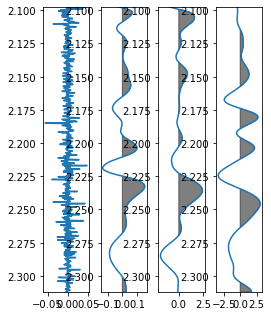

In [25]:
def calc_rc(vp_mod, rho_mod):
        '''
        rc_int = calc_rc(vp_mod, rho_mod)
        '''

        nlayers = len(vp_mod)
        nint = nlayers - 1

        rc_int = []
        for i in range(0, nint):
            buf1 = vp_mod[i+1]*rho_mod[i+1]-vp_mod[i]*rho_mod[i]
            buf2 = vp_mod[i+1]*rho_mod[i+1]+vp_mod[i]*rho_mod[i]
            buf3 = buf1/buf2
            rc_int.append(buf3)

        return rc_int

rc_int = np.array(calc_rc(np.array(resSec['Vp']),np.array(resSec['RHOZ_edt'])))

    
zerotrace = np.convolve(rc_int, wavelet_well[:,0], mode='same')    
    
fig = plt.figure(figsize=set_size(width, subplots=(5,2)))
fig.tight_layout
gs1 = gridspec.GridSpec(nrows=12, ncols=6, figure=fig,hspace =1 ,wspace=0.25)#,width_ratios=np.array([.5,.5,.5,.5,.5,.5,.5]))



ax0 = fig.add_subplot(gs1[0:7, 1])
ax0.set_ylim(t_plot_twt.min(),t_plot_twt.max())
ax0.invert_yaxis()

ax0.plot(rc_int,t_plot_twt[1:])

ax1 = fig.add_subplot(gs1[0:7, 2])

ax1.set_ylim(t_plot_twt.min(),t_plot_twt.max())
ax1.invert_yaxis()

ax1.plot(zerotrace,t_plot_twt[1:])
ax1.fill_betweenx(t_plot_twt[1:], zerotrace, 0, zerotrace > 0, color='k', alpha=.5)



ax2 = fig.add_subplot(gs1[0:7, 3])
ax2.plot(syn_zoep_cdp_well[0,:]*20,t_plot_twt)
ax2.set_ylim(t_plot_twt.min(), t_plot_twt.max())
ax2.invert_yaxis()
ax2.fill_betweenx(t_plot_twt, syn_zoep_cdp_well[0,:]*20,0, syn_zoep_cdp_well[0,:]*20 > 0, color='k', alpha=.5)




ax3 = fig.add_subplot(gs1[0:7, 4])

ax3.plot(gather_sm_bo2[:,0].T/1e3 , time_sm)
ax3.set_ylim(time_sm.min(),time_sm.max())
ax3.invert_yaxis()
ax3.fill_betweenx(time_sm, gather_sm_bo2[:,0].T/1e3, 0, gather_sm_bo2[:,0].T/1e3 > 0, color='k', alpha=.5)

In [26]:
syn_zoep_cdp_well[0,:]

array([-0.04534495, -0.04379644, -0.04223249, ..., -0.00471543,
       -0.00472117, -0.00472444])

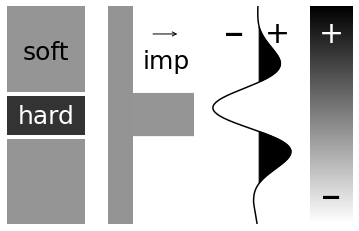

FIGURE SAVED


<Figure size 432x288 with 0 Axes>

In [27]:

"""
Author: Matt Hall, Agile Scientific
Licence: Apache 2.0, please re-use this code!
To use the CLI type this on the command line:
    python polarity_cartoon.py --help
   
There is a web app running at agile.geosci.ai/polarity
"""
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Install click and bruges with pip.
import click
import bruges as bg


def get_colour(cmap, frac):
    """
    Decide whether to make white or black labels.
    """
    cmap = get_cmap(cmap)
    return 'k' if (np.mean(cmap(frac)[:3]) > 0.5) else 'w'


def make_synthetic(size=256, top=0.4, base=0.6, value=1, freq=25, phase=0):
    """Make a synthetic. Return the wavelet, the model, the RC, and the synthetic.
    """
    v = np.ones(size) - value

    v[int(top*size):int(base*size)] = value
    rc = np.diff(v)

    w = bg.filters.ricker(0.256, 0.001, freq)

    if phase != 0:
        w = bg.filters.rotate_phase(w, phase, degrees=True)

    syn = np.convolve(rc, w, mode='same')
    return w, v, rc, syn


#@click.command()
#@click.option('--layer', default='hard', help='Hard or soft layer.')
#@click.option('--polarity', default='normal', help='Normal or reverse polarity.')
#@click.option('--freq', default='med', help='Lo, med, hi or vhi frequency.')
#@click.option('--phase', default=0, help='Phase angle in degrees')
#@click.option('--style', default='synthetic', help='Ramp or synthetic')
#@click.option('--cmap', default='gray', help='Matplotlib cmap.')
def polarity_cartoon(layer='hard',
                     polarity='normal',
                     freq='low',
                     phase=120,
                     style='ramp',
                     cmap=None,
                     ):
    """
    Plot a polarity cartoon. See agile.geosci.ai/polarity for more info.
    """
    freqs = {'vhi': 60, 'hi': 30, 'med': 15, 'lo': 7.5,
             'vhigh': 60, 'high': 30, 'medium': 15, 'low': 7.5,
             'mod': 15, 'mid': 15}
    backgr = 'soft' if layer == 'hard' else 'hard'
    value = 1 if layer == 'hard' else 0
    size, top, base = 256, 0.4, 0.6

    _, v, _, syn = make_synthetic(size, top, base, value, freq=freqs[freq], phase=phase)

    if polarity.lower() not in ['normal', 'seg', 'usa', 'us', 'canada']:
        syn *= -1

    if style == 'ramp':
        # cbar is a ramp.
        cbar = np.linspace(-1, 1, size).reshape(-1, 1)
    else:
        # cbar is the synthetic.
        cbar = syn.reshape(-1, 1)

    gs = {'width_ratios':[2,2,2,1]}

    fig, axs = plt.subplots(ncols=4,
                            figsize=(6, 4),
                            gridspec_kw=gs,
                            facecolor='w', sharey=True,
                            )

    # Plot the earth model.
    ax = axs[0]
    cmap_ = 'Greys'
    ax.imshow(v.reshape(-1, 1), aspect='auto', cmap=cmap_, vmin=-1.5, vmax=1.5)
    ax.axhline(top*size, c='w', lw=4)
    ax.axhline(base*size, c='w', lw=4)
    ax.axvline(0.55, c='w', lw=6)  # Total hack to adjust RHS
    ax.text(0, size/4.75, backgr, ha='center', va='center', color=get_colour(cmap_, (1-value)*256), size=25)
    ax.text(0, size/2+0.75, layer, ha='center', va='center', color=get_colour(cmap_, (value)*256), size=25)

    # Plot the impedance diagram.
    ax = axs[1]
    cmap_ = 'Greys'
    ax.imshow(v.reshape(-1, 1), aspect='auto', cmap=cmap_, vmin=0, vmax=2)
    ax.axvline(-0.5, c=(0.58, 0.58, 0.58), lw=50)
    ax.text(0.45, 2*size/8, 'imp', ha='right', va='center', color='k', size=25)
    ax.annotate("", xy=(0.33, size/8), xytext=(0, size/8), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

    # Plot the waveform.
    ax = axs[2]
    y = np.arange(syn.size)
    ax.plot(syn, y, 'k')
    ax.fill_betweenx(y, syn, 0, where=syn>0, color='k')
    ax.invert_yaxis()
    ax.text(0.65, size/8, '+', ha='center', va='center', size=30)
    ax.text(-0.9, size/8, '–', ha='center', va='center', size=40)

    # Plot the colourbar.
    ax = axs[3]
    cmap = cmap or 'gray'
    frac = 1/8
    top_col = get_colour(cmap, frac)
    bot_col = get_colour(cmap, 7*frac)
    ax.imshow(cbar, cmap=cmap, aspect='auto')
    if style == 'ramp':
        ax.text(0, frac*size, '+', ha='center', va='center', color=top_col, size=30)
        ax.text(0, 7*frac*size, '–', ha='center', va='center', color=bot_col, size=40)

    # Make final adjustments to subplots and figure.
    for ax in axs:
        ax.set_axis_off()

    plt.subplots_adjust(left=0.1)
    plt.show()

    return


if __name__ == '__main__':
    polarity_cartoon()

plt.show()
if savefig == True:
    plt.savefig(fig_path+'zerophase.svg',format='svg', bbox_inches='tight')
    print('FIGURE SAVED')

<a id='RPmodelling'></a>
# Rock Physics Modelling

In [28]:
from ipywidgets import *
resSec['TWT'] = t_plot_twt.copy()
Tuxen = resSec.loc[(resSec['DEPTH'] >= intf[7]) &  (resSec['DEPTH'] <= intf[7+1])].copy()

In [29]:
#chk1 = pd.read_csv(path_las+'p-wave_chk1.txt', sep='                                ',skiprows=1,names=('KB_depth','P_chk'))
#chk1['P_chk'] = chk1['P_chk']**-1 *10**6
##plt.plot(chk1['P_chk'],chk1['KB_depth'])
#plt.ylim(chk1['KB_depth'].max(),chk1['KB_depth'].min())
#plt.plot(bo2['DT']-chk1['P_chk'],bo2['DEPTH'])

#print(np.round(bo2['DEPTH'],2)[:],chk1['KB_depth'][1:-1])
#plt.plot(np.round(bo2['DEPTH'],2)-chk1['KB_depth'][:-1])

In [30]:
#depth_twt = pd.read_csv(path_las+'twt_depth_hrs.txt', sep=' ',skiprows=1,names=('KB','twt'))
#depth_twt


In [31]:
resSec_1 = resSec[(bo2['DEPTH'] > bo2_fms.loc[bo2_fms['fm name'] == 'Sola']['depth'][0]) &
             (bo2['DEPTH'] < bo2_fms.loc[bo2_fms['fm name'] == 'B. Valhall']['depth'][0])].copy()

resSec_1 = resSec_1.loc[resSec_1['PHIE'] != 0]


resSec_1['PHIE'].loc[resSec_1['F_label'] == 'Valhall']

<ipython-input-31-2bc1789d97e0>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resSec_1 = resSec[(bo2['DEPTH'] > bo2_fms.loc[bo2_fms['fm name'] == 'Sola']['depth'][0]) &


2569    0.0626
2570    0.0373
2571    0.0143
2572    0.0025
2586    0.0012
         ...  
2688    0.0248
2689    0.0103
2690    0.0016
2723    0.0007
2724    0.0020
Name: PHIE, Length: 78, dtype: float64

In [32]:
# Physical properties of constituents
K_o=0.62     # oil
Rho_o=0.8

K_w=2.3
G_w=0         # water
Rho_w=1.03

K_ca=71  
G_ca=30       # calcite
Rho_ca=2.71

K_q=37.3  
G_q=44.8      # quartz
Rho_q=2.65

K_k=15  
G_k=7       # shale
Rho_k=2.7

# Volume fraction of large calcite and large silicates 
c_l = 0.1 # large calcite
q_l = 0.05 # large quartz
k_l = 0.1 # large kaolinite

# Volume fraction of small calcite and suspended silicates
c_s = 0.5 # small calcite
q_s = 0.15 # small quartz
k_s = 0.1 # small kaolinite
print('Total volume fraction of solids equals: ', np.round(c_l+q_l+k_l+c_s+q_s+k_s,0))

# Reservoir properties
Por_c = 0.66 # Critical porosity
Por=np.linspace(0,Por_c,100)
S_w = 1 # water saturation


# Modeling

K_sus = np.nan*np.ones((Por.size,11))
K_IF = np.nan*np.ones((Por.size,11))
G_IF = np.nan*np.ones((Por.size,11))
M_IF = np.nan*np.ones((Por.size,11))
Vp_IF = np.nan*np.ones((Por.size,11))
Vs_IF = np.nan*np.ones((Por.size,11))
AI_IF = np.nan*np.ones((Por.size,11))
PS_IF = np.nan*np.ones((Por.size,11))
Rho = np.nan*np.ones((Por.size,11))

n=0;
for IF in np.arange(0,1.1,0.1):
    

    K_f = S_w/K_w + (1-S_w)/K_o # Reuss
    #K_f = S_w*K_w + (1-S_w)*K_o; # Voigt
    
    K_sus[:,n] = ( Por/Por_c*K_f + (1-Por/Por_c)*((c_s*(1-IF)/K_ca) + (q_s/K_q) + (k_s/K_k) ) )**(-1) * (Por/Por_c + (1-Por/Por_c)*(c_s*(1-IF) + q_s + k_s) )

        
    Rho[:,n] = (Por/Por_c)*((1-IF)*c_s*Rho_ca + (Rho_w*S_w) + (Rho_o*(1-S_w)) + Rho_k*k_s + Rho_q*q_s) + (1-(Por/Por_c))*((IF*c_s+c_l)*Rho_ca + q_l*Rho_q + k_l*Rho_k);

    K_IF[:,n] = ( ((Por/Por_c)/(K_sus[:,n] + (4/3)*G_ca)) + (1-(Por/Por_c))* ( (((1-IF)*c_s + q_s + k_s)/(K_sus[:,n] + (4/3)*G_ca)) + ((IF*c_s+c_l)/(K_ca + (4/3)*G_ca)) + (q_l / (K_q + (4/3)*G_ca)) + (k_l / (K_k + (4/3)*G_ca)) ))**(-1) - (4/3)*G_ca

    zeta = (G_ca/6) * ((9*K_ca + 8*G_ca)/(K_ca + 2*G_ca));

    G_IF[:,n] = ( ((Por/Por_c)/zeta) +  (1-(Por/Por_c))*( (((1-IF)*c_s + q_s + k_s)/(zeta)) + ((IF*c_s+c_l)/(G_ca + zeta)) + (q_l/(G_q + zeta)) + (k_l / (G_k + zeta))) )**(-1) - zeta;
        
    M_IF[:,n] = K_IF[:,n] + (4/3)*G_IF[:,n]
    
    Vp_IF[:,n] = np.sqrt(K_IF[:,n] + (4/3)*G_IF[:,n] / Rho[:,n])
    Vs_IF[:,n] = np.sqrt(G_IF[:,n] / Rho[:,n])
    
    AI_IF[:,n] = Vp_IF[:,n] * Rho[:,n]
    PS_IF[:,n] = Vp_IF[:,n] / Vs_IF[:,n]
    
    n=n+1
    
    


resSec_1['G'] = (resSec_1['Vs']/1000.)**2 * resSec_1['RHOZ_edt']/1000.
resSec_1['K'] = (resSec_1['Vp']/1000.)**2 * resSec_1['RHOZ_edt']/1000. - (4/3)*resSec_1['G']
resSec_1['M'] = resSec_1['K'] + (4/3)*resSec_1['G']

def vrh(volumes,k,mu):
    '''
    Calculates Voigt-Reuss-Hill bounds, (C) aadm 2015

    INPUT
    volumes: array with volumetric fractions
    k: array with bulk modulus
    mu: array with shear modulus

    OUTPUT
    k_u, k_l: upper (Voigt) and lower (Reuss) average of k
    mu_u, mu_l: upper (Voigt) and lower (Reuss) average of mu
    k0, mu0: Hill average of k and mu
    '''
    f=np.array(volumes).T
    k=np.resize(np.array(k),np.shape(f))
    mu=np.resize(np.array(mu),np.shape(f))
    ax=0 if f.ndim==1 else 1
    k_u = np.sum(f*k,axis=ax)
    k_l = 1./np.sum(f/k,axis=ax)
    mu_u = np.sum(f*mu,axis=ax)
    mu_l = 1./np.sum(f/mu,axis=ax)
    k0 = (k_u+k_l)/2.
    mu0 = (mu_u+mu_l)/2.
    return k_u, k_l, mu_u, mu_l, k0, mu0


def geqHSW(k1,g1,k2,g2,vol1):
    # Hashin-Shtrikman-Walpole bounds (Walpole 1966). More general version of the
    # Hashin-Shtrikman bounds where the constituent with the higher bulk
    # modulus does not neccessarily have to have the highest shear modulus.
    
    vol2 = 1-vol1
    Kmin = np.min([k1,k2])
    Kmax = np.max([k1,k2])
    Gmin = np.min([g1,g2])
    Gmax = np.max([g1,g2])
    
    ku = k1 + vol2/((k2-k1)**(-1) + vol1*(k1+4/3*Gmax)**(-1))
    kl = k1 + vol2/((k2-k1)**(-1) + vol1*(k1+4/3*Gmin)**(-1))
    gu = g1 + vol2/((g2-g1)**(-1) + \
    vol1*(g1 + Gmax/6 * ((9*Kmax+8*Gmax)/(Kmax+2*Gmax)))**(-1))
    gl = g1 + vol2/((g2-g1)**(-1) + \
    vol1*(g1 + Gmin/6 * ((9*Kmin+8*Gmin)/(Kmin+2*Gmin)))**(-1))
    
    return ku,kl,gu,gl

def geqGassmannDry(Ksat, Ks, Kf, Phi):
    #   Calculates the dry rock bulk modulus using Gassmann. 
    # 
    #   DryBulkModulus  - [array]; dry rock bulk modulus [GPa]
    #   Ksat            - [array]; effective (saturated) bulk modulus [GPa]
    #   Ks              - [array]; effective solid bulk modulus [GPa]
    #   Kf              - [array]; effective fluid bulk modulus [GPa]
    #   Phi             - [array]; porosity (in fraction of 1)
    DryBulkModulus   = (Ksat * ( Phi * Ks / Kf + 1 - Phi) - Ks) / \
                    (Phi * Ks / Kf + Ksat / Ks - 1 - Phi)
        
    return DryBulkModulus 

def geqGassmannFluidSubst(Ksat1,Ks,Kf1,Kf2,Phi):
    #   Calculate effective bulk modulus doing a Gassmann fluid substitution.
    # 
    #   NewEffectiveBulkModulus - [array]; effective bulk modulus after 
    #                               substituting with fluid 2 [GPa]
    #   Ksat1       - [array]; effective bulk modulus with (original) fluid 1 [GPa]
    #   Ks          - [array]; effective solid bulk modulus [GPa]
    #   Kf1         - [array]; effective bulk modulus of fluid 1 [GPa]
    #   Kf2         - [array]; effective bulk modulus of fluid 2 [GPa]
    #   Phi         - [array]; porosity  (in fraction of 1)
    
    Tmp = Ksat1/(Ks-Ksat1) - Kf1 / (Phi*(Ks-Kf1)) + \
    Kf2/(Phi*(Ks-Kf2))
    
    NewEffectiveBulkModulus = Ks*Tmp / (1+Tmp)
    
    return NewEffectiveBulkModulus




# Calculate the mineral/solid constituents using a Hashin-Shtrikman bound
_,resSec_1['k_s'],_,_ = geqHSW(65,35,K_k,G_k,1-(resSec_1['VSHALE']))

# Calculate the fluid bulk moduli using a Hill average
_,_,_,_,resSec_1['k_f'],_ = vrh([resSec_1['SW_CRETSYS'], 1-resSec_1['SW_CRETSYS']], [K_w,K_o],[_,_])

# Calculate the dry bulk modulus using Gassmann
resSec_1['k_d'] = geqGassmannDry(resSec_1['K'],resSec_1['k_s'],resSec_1['k_f'],resSec_1['PHIE'])

# Calculate water substituted bulk modulus using Gassmann
resSec_1['k_w'] = geqGassmannFluidSubst(resSec_1['K'],resSec_1['k_s'],resSec_1['k_f'],K_w,resSec_1['PHIE'])

Total volume fraction of solids equals:  1.0


<ipython-input-32-698bf55b76b8>:74: RuntimeWarning: divide by zero encountered in true_divide
  PS_IF[:,n] = Vp_IF[:,n] / Vs_IF[:,n]


FIGURE SAVED


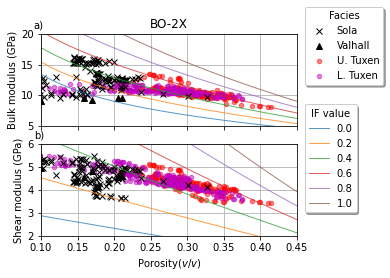

In [33]:
# Plot model vs data

#fig, ax = plt.subplots(nrows = 2, ncols = 1,sharex=True,figsize=(12,10))
fig = plt.figure(figsize=set_size(width, subplots=(4,4)))
fig.tight_layout
gs1 = gridspec.GridSpec(nrows=6, ncols=5, figure=fig,hspace =1 ,wspace=3)
ax0 = fig.add_subplot(gs1[0:3, 0:4])
ax1 = fig.add_subplot(gs1[3:6, 0:4])


groups = resSec_1['F_label'].unique()

if S_w == 1:
    tmp = 'k_w'
else:
    tmp = 'K'

c_idx = 0    
colors = np.array(['red','m']) 
  
for i in range(len(groups)):
    x, y = (resSec_1[resSec_1['F_label']==groups[i]]['PHIE'],resSec_1[resSec_1['F_label']==groups[i]][tmp])
    if (groups[i]=='Sola'):
        ax0.plot(resSec_1[resSec_1['F_label']==groups[i]]['PHIE'],resSec_1[resSec_1['F_label']==groups[i]][tmp],'kx',ms=6,label=groups[i])
    elif (groups[i]=='Valhall'):
        ax0.plot(resSec_1[resSec_1['F_label']==groups[i]]['PHIE'],resSec_1[resSec_1['F_label']==groups[i]][tmp],'k^',ms=6,label=groups[i],color='k')
    else:
        ax0.scatter(x, y, alpha=0.5, s=20, label=groups[i],color=colors[c_idx])
        c_idx = c_idx+1
ax0.plot(Por,K_IF[:,::2],lw=1,alpha=0.75)        
    
ax0.set_ylabel('Bulk modulus (GPa)')
ax0.set_title('BO-2X')
ax0.set_xticklabels([''])
ax0.grid()
ax0.set_axisbelow(True)
lg = ax0.legend(bbox_to_anchor=(1.01,.39),title='Facies',fancybox=True,shadow=True)
#plt.setp(lg.get_title())

ax0.set_xlim([0.1,0.45])
ax0.set_ylim([5,20])
ax0.text(x =ax0.get_xlim()[0]-0.01, y = ax0.get_ylim()[1]+1, s = 'a)',weight='normal')



    
c_idx = 0    
for i in range(len(groups)):
    x, y = (resSec_1[resSec_1['F_label']==groups[i]]['PHIE'],resSec_1[resSec_1['F_label']==groups[i]]['G'])
    if (groups[i]=='Sola'):
        ax1.plot(resSec_1[resSec_1['F_label']==groups[i]]['PHIE'],resSec_1[resSec_1['F_label']==groups[i]]['G'],'kx',ms=6 )
    elif (groups[i]=='Valhall'):
        ax1.plot(resSec_1[resSec_1['F_label']==groups[i]]['PHIE'],resSec_1[resSec_1['F_label']==groups[i]]['G'],'k^',ms=6,color='k')
    else:
        ax1.scatter(x, y, alpha=0.5, s=20  ,color=colors[c_idx])
        c_idx = c_idx+1
        

if_val = np.linspace(0,1,len(G_IF[0,::2]))
for n in range(len(if_val)):    
    ax1.plot(Por,G_IF[:,n*2],lw=1,alpha=0.75,label=np.round(if_val[n],1))       


ax1.set_xlabel('Porosity' + r'$(v/v)$')
ax1.set_ylabel('Shear modulus (GPa)')
ax1.grid()
ax1.set_axisbelow(True)
ax1.set_xlim([0.1,0.45])
ax1.set_ylim([2,6])

ax1.text(x = ax1.get_xlim()[0]-0.01, y = ax1.get_ylim()[1]+.25, s = 'b)', weight='normal')

lg = ax1.legend(bbox_to_anchor=(1.01,.20),title='IF value',fancybox=True,shadow=True)

if savefig == True:
    plt.savefig(fig_path+'IF_BO2X.svg',format='svg', bbox_inches='tight')
    print('FIGURE SAVED')

<a id='RPmodelling_interactive'></a>
# Interactive Rock Physics AVO Modelling

In [34]:
def f(r_Sw, r_por, r_shv):
    
    Tuxen['sw_mod'] = r_Sw
    Tuxen['phi_mod'] = r_por
    Tuxen['lit_mod'] = r_shv
    
    # Physical properties of constituents
    K_o=0.62     # oil
    Rho_o=0.8

    K_w=2.3
    G_w=0         # water
    Rho_w=1.03

    K_ca=71  
    G_ca=30       # calcite
    Rho_ca=2.71

    K_q=37.3  
    G_q=44.8      # quartz
    Rho_q=2.65

    K_k=15  
    G_k=7       # shale
    Rho_k=2.7


    # Volume fraction of large calcite and large silicates 
    Vc_l = 0.1 # large calcite
    Vq_l = 0 # large quartz
    Vk_l = 0.05 # large kaolinite

    # Volume fraction of small calcite and suspended silicates
    Vc_s = 0.7 # small calcite
    Vq_s = 0.1 # small quartz
    Vk_s = 0.05 # small kaolinite

    Vtot_sh = Vk_s + Vk_l
    Vtot_r = Vc_l+Vq_l+Vc_s+Vq_s

    c_l = np.zeros(len(Tuxen['phi_mod'])) 
    c_l[:] = np.nan
    c_s = np.zeros(len(Tuxen['phi_mod']))
    c_s[:] = np.nan
    c_l = np.zeros(len(Tuxen['phi_mod']))
    c_l[:] = np.nan
    q_l = np.zeros(len(Tuxen['phi_mod']))
    q_l[:] = np.nan
    q_s = np.zeros(len(Tuxen['phi_mod']))
    q_s[:] = np.nan
    k_s = np.zeros(len(Tuxen['phi_mod']))
    k_s[:] = np.nan
    k_l = np.zeros(len(Tuxen['phi_mod']))
    k_l[:] = np.nan

    Por = np.zeros(len(Tuxen['phi_mod']))
    Por[:] = np.nan
    S_w = np.zeros(len(Tuxen['phi_mod']))
    S_w[:] = np.nan

    # Dynamic reservoir properties from log data
    for n in range(len(Tuxen['phi_mod'])):

        # Normalizing the solid volume fractions according to the shale log
        c_l[n] = (1-Tuxen['lit_mod'].iloc[n]) * Vc_l/Vtot_r
        c_s[n] = (1-Tuxen['lit_mod'].iloc[n]) * Vc_s/Vtot_r
        q_l[n] = (1-Tuxen['lit_mod'].iloc[n]) * Vq_l/Vtot_r
        q_s[n] = (1-Tuxen['lit_mod'].iloc[n]) * Vq_s/Vtot_r
        k_s[n] = Tuxen['lit_mod'].iloc[n] * Vk_s/Vtot_sh
        k_l[n] = Tuxen['lit_mod'].iloc[n] * Vk_l/Vtot_sh

        Por[n] = Tuxen['phi_mod'].iloc[n]
        S_w[n] = Tuxen['sw_mod'].iloc[n]

    # Reservoir properties
    Por_c = 0.66 # Critical porosity
    fluidMix = 'reuss'
    
    
    # Modeling

    IFc = np.linspace(0,1,6) # Iso-frame value for the suspended chalk
    IFs = 0.2 # Iso-frame value for the suspended shale
    IFq = 0.2 # Iso-frame value for the suspended quartz

    K_sus = np.nan*np.ones((Por.size,IFc.size))
    K_IF = np.nan*np.ones((Por.size,IFc.size))
    G_IF = np.nan*np.ones((Por.size,IFc.size))
    M_IF = np.nan*np.ones((Por.size,IFc.size))
    Vp_IF = np.nan*np.ones((Por.size,IFc.size))
    Vs_IF = np.nan*np.ones((Por.size,IFc.size))
    AI_IF = np.nan*np.ones((Por.size,IFc.size))
    PS_IF = np.nan*np.ones((Por.size,IFc.size))
    Rho = np.nan*np.ones((Por.size,IFc.size))

    K_f = S_w/K_w + (1-S_w)/K_o
    Rho =  Por*((Rho_w*S_w) + (Rho_o*(1-S_w))) + ((1-Por)*((c_s+c_l)*Rho_ca + Rho_k*(k_s+k_l) + Rho_q*(q_s+q_l))) 

    #for n in range(len(IFc)):
    n=2
    K_sus[:,n] = ( Por/Por_c*K_f + (1-Por/Por_c)*( (c_s*(1-IFc[n])/K_ca) + (q_s*(1-IFq)/K_q) + (k_s*(1-IFs)/K_k) ) )**(-1) * (Por/Por_c + (1-Por/Por_c)*( c_s*(1-IFc[n]) + q_s*(1-IFq) + k_s*(1-IFs)) )

    K_IF[:,n] = ( ((Por/Por_c)/(K_sus[:,n] + (4/3)*G_ca)) + (1-(Por/Por_c))* ( (((1-IFc[n])*c_s + (1-IFq)*q_s + (1-IFs)*k_s)/(K_sus[:,n] + (4/3)*G_ca)) + ((IFc[n]*c_s+c_l) / (K_ca + (4/3)*G_ca)) + ( (IFq*q_s+q_l) / (K_q + (4/3)*G_ca)) + ((IFs*k_s+k_l) / (K_k + (4/3)*G_ca)) ))**(-1) - (4/3)*G_ca

    zeta = (G_ca/6) * ((9*K_ca + 8*G_ca)/(K_ca + 2*G_ca));

    G_IF[:,n] = ( ((Por/Por_c)/zeta) +  (1-(Por/Por_c))*( (((1-IFc[n])*c_s + (1-IFq)*q_s + (1-IFs)*k_s)/(zeta)) + ((IFc[n]*c_s+c_l)/(G_ca + zeta)) + ((IFq*q_s+q_l)/(G_q + zeta)) + ( (IFs*k_s+k_l) / (G_k + zeta))) )**(-1) - zeta

    M_IF[:,n] = K_IF[:,n] + (4/3)*G_IF[:,n]

    Vp_IF[:,n] = np.sqrt((K_IF[:,n] + (4/3)*G_IF[:,n]) / Rho)
    Vs_IF[:,n] = np.sqrt(G_IF[:,n] / Rho)

    AI_IF[:,n] = Vp_IF[:,n] * Rho
    PS_IF[:,n] = Vp_IF[:,n] / Vs_IF[:,n]


        
        
        #   Calculate reflectivities from model parameters
    
        #   Calculate reflectivities from model parameters
    Tuxen['vp_mod'] = Vp_IF[0,2]
    Tuxen['vs_mod'] = Vs_IF[0,2]

    rc_zoep_pp = []
    theta1 = []
    dummy_rc = np.zeros([9,4,4])
    
    #phi_mod[7] = Por[0]
    rho_mod[7] = Rho[0]*1000.
    vp_mod[7] = Vp_IF[0,2]*1000.
    vs_mod[7] = Vs_IF[0,2]*1000.
    #lit_mod[7] = 
    
    
    for i in range(5, nangles,10):
        theta1_buf = i*theta1_step + theta1_min
        for i in range (vp_mod.size-1):
            dummy_rc[i,:,:] = mlo.rc_zoep(vp_mod[i], vs_mod[i], rho_mod[i], vp_mod[i+1], vs_mod[i+1], rho_mod[i+1], theta1_buf)

        theta1.append(theta1_buf)
        rc_zoep_pp.append((dummy_rc[0,0,0],dummy_rc[1,0,0],dummy_rc[2,0,0],
                          dummy_rc[3,0,0],dummy_rc[4,0,0],dummy_rc[5,0,0],
                          dummy_rc[6,0,0],dummy_rc[7,0,0],dummy_rc[8,0,0]))
    
    syn_zoep_pp_well = [] 
    syn_zoep_pp_seis = []
    angle_dummy = np.array([5,15,25])
    j=0
    for angle in range(5, nangles,10):
            nlayers = len(rc_zoep_pp[j])
            nint = nlayers
            nsamp = len(t_plot_twt)
            rc = list(np.zeros(nsamp,dtype='float'))
            lyr = 0

            for i in range(0, nsamp):
                for k in range(0,tops_twt.size-1):
                    if t_plot_twt[i] == tops_twt[k]:
                        rc[i] = rc_zoep_pp[j][k-1]
                    if lyr > nint:
                        break
            #k=0
            #   Convolve wavelet with reflectivities

            syn_buf = np.convolve(rc, wavelet_well[:,j], mode='same')
            syn_buf = list(syn_buf)
            syn_zoep_pp_well.append(syn_buf)

            syn_buf_seis = np.convolve(rc, wavelet_seismic[:,j], mode='same')
            syn_buf_seis = list(syn_buf_seis)
            syn_zoep_pp_seis.append(syn_buf_seis)
            j=j+1
            #print("Calculated angle %i" % (angle))

    #    Convert data arrays from lists/tuples to numpy arrays    
    syn_zoep_pp_well = np.array(syn_zoep_pp_well)
    syn_zoep_pp_seis = np.array(syn_zoep_pp_seis)
    rc_zoep_pp = np.array(rc_zoep_pp)

    #   Copy convolved top/base reflectivity values to Lists for easier plotting
    [ntrc, nsamp] = syn_zoep_pp_well.shape
    line1 = []
    line2 = []
    line3 = []
    line4 = []
    line5 = []
    line6 = []
    line7 = []
    line8 = []
    line9 = []
    line10 = []

    Yzoep = np.array(rc_zoep_pp[:,0])
    Yzoep = Yzoep.reshape((ntrc, 1))


    sintheta2 = np.sin(np.radians(np.arange(0, ntrc)))**2
    sintheta2 = sintheta2.reshape((ntrc, 1))


    tops_lines = np.zeros([tops_idx.size , syn_zoep_pp_well.shape[0]])    


    for i in range(0, ntrc):
        line1.append(syn_zoep_pp_well[i,np.int(tops_idx[0])])
        line2.append(syn_zoep_pp_well[i,np.int(tops_idx[1])])
        line3.append(syn_zoep_pp_well[i,np.int(tops_idx[2])])
        line4.append(syn_zoep_pp_well[i,np.int(tops_idx[3])])
        line5.append(syn_zoep_pp_well[i,np.int(tops_idx[4])])
        line6.append(syn_zoep_pp_well[i,np.int(tops_idx[5])])
        line7.append(syn_zoep_pp_well[i,np.int(tops_idx[6])])
        line8.append(syn_zoep_pp_well[i,np.int(tops_idx[7])])
        line9.append(syn_zoep_pp_well[i,np.int(tops_idx[8])])     
        line10.append(syn_zoep_pp_well[i,np.int(tops_idx[9])])

    line1=np.squeeze(np.array([line1]))
    line2=np.squeeze(np.array([line2]))
    line3=np.squeeze(np.array([line3]))
    line4=np.squeeze(np.array([line4]))
    line5=np.squeeze(np.array([line5]))
    line6=np.squeeze(np.array([line6]))
    line7=np.squeeze(np.array([line7]))
    line8=np.squeeze(np.array([line8]))
    line9=np.squeeze(np.array([line9]))
    line10=np.squeeze(np.array([line10]))




    tops_lines = np.zeros([tops_idx.size , syn_zoep_pp_well.shape[0]])    

    fig = plt.figure(figsize=(20, 15))
    fig.set_facecolor('white')
    fig.tight_layout
    
    ax0 = fig.add_subplot(1,12,1)
    ax1 = fig.add_subplot(1,12,2)
    ax2 = fig.add_subplot(1,12,3)
    ax3 = fig.add_subplot(1,12,4)
    ax4 = fig.add_subplot(1,12,5)
        
    ax0.plot(resSec['lit_mod'],t_plot_twt,'k',alpha=0.5,label='Vsh',lw=3)
    ax0.plot(resSec['sw_mod'],t_plot_twt, 'b',alpha=0.75,label='Sw',lw=3)
    ax0.plot(Tuxen['sw_mod'],Tuxen['TWT'], 'k.',alpha=0.75,label='Sw',lw=3)
    ax0.plot(Tuxen['lit_mod'],Tuxen['TWT'], 'k.',alpha=0.75,label='Vsh',lw=3)
    ax0.fill_betweenx(Tuxen['TWT'],np.ones(Tuxen.shape[0])*sw_mod[7],Tuxen['sw_mod'],color='skyblue',alpha=0.4)
    ax0.fill_betweenx(Tuxen['TWT'],np.ones(Tuxen.shape[0])*lit_mod[7],Tuxen['lit_mod'],color='k',alpha=0.4)
    ax0.invert_yaxis()
    ax0.set_ylabel('TWT (ms)', fontsize = 14)
    ax0.set_xlabel('(v/v)', fontsize = 14)
    ax0.axis('tight')
 #   ax0.grid()
    ax0.set_axisbelow(True)
    ax0.set_xlim(0,1)
    ax0.legend(loc=1,fontsize=12,fancybox=True,shadow=True)

    
     
    ax1.plot(resSec['phi_mod'],t_plot_twt,'g',alpha=0.75,lw=3)
    ax1.plot(Tuxen['phi_mod'],Tuxen['TWT'], 'k.',alpha=0.75,label='Sw',lw=3)
    ax1.fill_betweenx(Tuxen['TWT'],np.ones(Tuxen.shape[0])*r_por,resSec['phi_mod'].loc[resSec['F_label']== 'U. Tuxen'],color='green',alpha=0.4)
    ax1.invert_yaxis()
    ax1.set_yticklabels('')
    ax1.set_title('POR')
    ax1.set_xlabel('(v/v)', fontsize = 14)
    ax1.xaxis.set_label_position('bottom')
    ax1.axis('tight')
  #  ax1.grid()
    ax1.set_axisbelow(True)
    ax1.set_xlim(0,0.5)

     
    ax2.plot(resSec['rho_mod']/1000.,t_plot_twt,'k',alpha=1,lw=3)
    ax2.plot(Rho,Tuxen['TWT'],'r.',alpha=0.5)
    yerr = Rho.std() * 2 # ~ 95% confidence interval
    ax2.fill_betweenx(Tuxen['TWT'],Rho-yerr,Rho+yerr,color='skyblue',alpha=0.4)
    ax2.invert_yaxis()
    ax2.set_yticklabels('')
    ax2.set_title('RHO')
    ax2.set_xlabel(r'$(g/cm^3)$', fontsize = 14)
    ax2.xaxis.set_label_position('bottom')
    ax2.axis('tight')
   # ax2.grid()
    ax2.set_axisbelow(True)


    
    ax3.plot(resSec['vp_mod']/1000.,t_plot_twt,'k',alpha=1,lw=3)
    ax3.plot(Tuxen['vp_mod'],Tuxen['TWT'],'r.',alpha=0.5)
    yerr = Tuxen['vp_mod'].std() * 2 # ~ 95% confidence interval
    ax3.fill_betweenx(Tuxen['TWT'],Tuxen['vp_mod']-yerr,Tuxen['vp_mod']+yerr,color='skyblue',alpha=0.4)
    
    
     
    ax4.plot(resSec['vs_mod']/1000.,t_plot_twt,'k',alpha=1,lw=3,label='Data')

    

    ax4.plot(Tuxen['vs_mod'],Tuxen['TWT'],'r.',alpha=0.5,label='IF Model')
    yerr = Tuxen['vs_mod'].std() * 2 # ~ 95% confidence interval
    #ax4.fill_betweenx(Tuxen['TWT'],Tuxen['vs_mod']-yerr,Tuxen['vs_mod']+yerr,color='skyblue',alpha=0.4,label='95% CI')


    ax3.invert_yaxis()
    ax3.set_yticklabels('')
    ax3.set_title('Vp')
    ax3.set_xlabel('(km/s)', fontsize = 14)
    ax3.xaxis.set_label_position('bottom')
    ax3.axis('tight')
   # ax3.grid()
    ax3.set_axisbelow(True)


    ax4.invert_yaxis()
    ax4.set_yticklabels('')
    ax4.set_title('Vs')
    ax4.set_xlabel('(km/s)', fontsize = 14)
    ax4.xaxis.set_label_position('bottom')
    ax4.axis('tight')
   # ax4.grid()
    ax4.set_axisbelow(True)
    ax4.legend(loc=1,fontsize=12,fancybox=True,shadow=True)    

    syn_zoep_cdp_well = syn_zoep_pp_well
    

    #Pre-stack trace
    ax5 = fig.add_subplot(1,5,3)
    mlo.plot_vawig(ax5, syn_zoep_cdp_well , t_plot_twt, 1)
    ax5.set_ylim(t_plot_twt.min(),t_plot_twt.max())
    ax5.axhline(tops_twt[6], color = 'green', lw=3, label = 'Top Sola')
    ax5.axhline(tops_twt[7], color = 'red', lw=3 , label = 'Upper Tuxen')
    ax5.axhline(tops_twt[8], color = 'm', lw=3, label = 'Lower Tuxen')
    ax5.axhline(tops_twt[9], color = 'blue', lw=3, label = 'Top Valhall')
    ax5.invert_yaxis()
    ax5.set_title('Synthetic CDP', fontsize = 20,weight = 'bold')
    ax5.xaxis.tick_bottom()
    ax5.xaxis.set_label_position('bottom')
    ax5.set_xlim(-1,3)
    ax5.yaxis.set_label_position("right")
    ax5.set_xticks(np.array([0,1,2]));
    ax5.set_xticklabels(['10','20','30']);
    ax5.set_xlabel('Offset (deg)', fontsize = 14)
    ax5.set_yticklabels('')
    
    
    ax6 = fig.add_subplot(1,5,4)
    mlo.plot_vawig(ax6, gather_sm_bo2.T/1e3 , time_sm, 1)
    ax6.set_ylim(time_sm.min(),time_sm.max())
    ax6.set_ylim(t_plot_twt.min(),t_plot_twt.max())
    ax6.axhline(tops_twt[6], color = 'green', lw=3, label = 'Top Sola')
    ax6.axhline(tops_twt[7], color = 'red', lw=3 , label = 'Upper Tuxen')
    ax6.axhline(tops_twt[8], color = 'm', lw=3, label = 'Lower Tuxen')
    ax6.axhline(tops_twt[9], color = 'blue', lw=3, label = 'Top Valhall')
    ax6.invert_yaxis()
    ax6.set_xlabel('Offset (deg)', fontsize = 14)
    ax6.set_title('CMP @ BO-2X', fontsize = 20,weight = 'bold')
    #ax6.set_ylabel('Time (s)', fontsize = 14)
    ax6.xaxis.tick_bottom()
    ax6.xaxis.set_label_position('bottom')
    ax6.set_xlim(-1,3)
    ax6.set_xticks(np.array([0,1,2]));
    ax6.set_xticklabels(['10','20','30']);
    ax6.set_yticklabels('')
    ax6.text(x = ax6.get_xlim()[1] +.5 , y = tops_twt[6]+0.002,  s = 'Top Sola', weight='normal', color = 'green')
    ax6.text(x = ax6.get_xlim()[1] +.5 , y = tops_twt[7]+0.002,  s = 'Top U. Tuxen', weight='normal', color = 'red')
    ax6.text(x = ax6.get_xlim()[1] +.5 , y = tops_twt[8]+0.002,  s = 'Top L. Tuxen (MM)', weight='normal', color = 'm')
    ax6.text(x = ax6.get_xlim()[1] +.5 , y = tops_twt[9]+0.002,  s = 'Top Valhall', weight='normal', color = 'blue')   
    
    
    for i in range (tops_twt.size-4):
        ax0.axhline(tops_twt[i],   lw=1, alpha = 0.3)
        ax1.axhline(tops_twt[i],   lw=1, alpha = 0.3)
        ax2.axhline(tops_twt[i],   lw=1, alpha = 0.3)
        ax3.axhline(tops_twt[i],   lw=1, alpha = 0.3)
        ax4.axhline(tops_twt[i],   lw=1, alpha = 0.3)
        ax5.axhline(tops_twt[i],   lw=1, alpha = 0.3)
        ax6.axhline(tops_twt[i],   lw=1, alpha = 0.3)

    
    ax0.set_ylim(t_plot_twt.max(),t_plot_twt.min())
    ax1.set_ylim(t_plot_twt.max(),t_plot_twt.min())
    ax2.set_ylim(t_plot_twt.max(),t_plot_twt.min())
    ax3.set_ylim(t_plot_twt.max(),t_plot_twt.min())
    ax4.set_ylim(t_plot_twt.max(),t_plot_twt.min())
    
    ax0.axhline(tops_twt[6], color = 'green', lw=3, alpha=0.3)
    ax0.axhline(tops_twt[7], color = 'red', lw=3,   alpha=0.3)
    ax0.axhline(tops_twt[8], color = 'm', lw=3,     alpha=0.3)
    ax0.axhline(tops_twt[9], color = 'blue', lw=3,  alpha=0.3)    
    ax1.axhline(tops_twt[6], color = 'green', lw=3, alpha=0.3)
    ax1.axhline(tops_twt[7], color = 'red', lw=3,   alpha=0.3)
    ax1.axhline(tops_twt[8], color = 'm', lw=3,     alpha=0.3)
    ax1.axhline(tops_twt[9], color = 'blue', lw=3,  alpha=0.3)
    ax2.axhline(tops_twt[6], color = 'green', lw=3, alpha=0.3)
    ax2.axhline(tops_twt[7], color = 'red', lw=3,   alpha=0.3)
    ax2.axhline(tops_twt[8], color = 'm', lw=3,     alpha=0.3)
    ax2.axhline(tops_twt[9], color = 'blue', lw=3,  alpha=0.3)
    ax3.axhline(tops_twt[6], color = 'green', lw=3, alpha=0.3)
    ax3.axhline(tops_twt[7], color = 'red', lw=3,   alpha=0.3)
    ax3.axhline(tops_twt[8], color = 'm', lw=3,     alpha=0.3)
    ax3.axhline(tops_twt[9], color = 'blue', lw=3,  alpha=0.3)
    ax4.axhline(tops_twt[6], color = 'green', lw=3, alpha=0.3)
    ax4.axhline(tops_twt[7], color = 'red', lw=3,   alpha=0.3)
    ax4.axhline(tops_twt[8], color = 'm', lw=3,     alpha=0.3)
    ax4.axhline(tops_twt[9], color = 'blue', lw=3,  alpha=0.3)

    
interactive_plot = interactive(f, r_Sw=(0, 1., 0.1),r_por=(0,Por_c,.1), r_shv = (0,1.,.05),continuous_update=False,)
output = interactive_plot.children[-1]
output.layout.height = '500x'
interactive_plot



interactive(children=(FloatSlider(value=0.5, description='r_Sw', max=1.0), FloatSlider(value=0.300000000000000…

<a id='wedge'></a>
# Wedge Model

In [35]:
# Wavelets average:
wavelet_seismic = np.sum(wavelet_seismic, 1)/wavelet_seismic.shape[1]
wavelet_well = np.sum(wavelet_well, 1)/wavelet_well.shape[1]

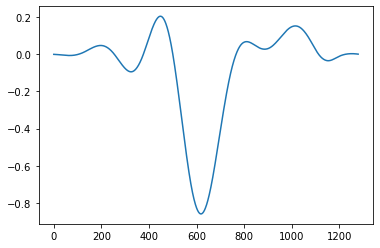

In [36]:
plt.plot(wavelet_well)

61


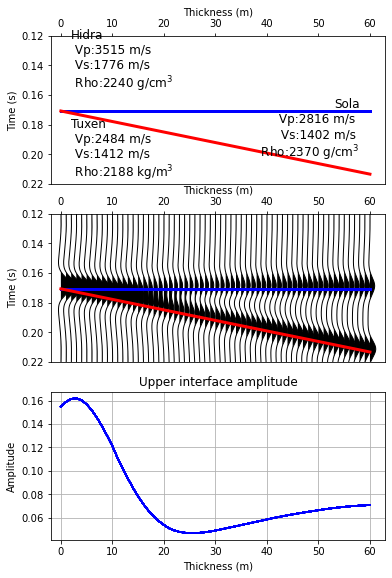

In [37]:
##   3-Layer Model Parameters [Layer1, Layer2, Layer 3]

#mlo.plot_vawig(ax5, syn_zoep_cdp_well , t_plot_twt, 1)


vp_mod = np.array([resSec['Vp'].loc[resSec['F_label']=='Hidra'].mean() , resSec['Vp'].loc[resSec['F_label']=='Sola'].mean(), (resSec['Vp'].loc[resSec['F_label']=='U. Tuxen'].mean() + resSec['Vp'].loc[resSec['F_label']=='L. Tuxen'].mean())/2.])  # P-wave velocity (m/s)
vs_mod = np.array([resSec['Vs'].loc[resSec['F_label']=='Hidra'].mean() , resSec['Vs'].loc[resSec['F_label']=='Sola'].mean(), (resSec['Vs'].loc[resSec['F_label']=='U. Tuxen'].mean()+ resSec['Vs'].loc[resSec['F_label']=='L. Tuxen'].mean())/2.])  # S-wave velocity (m/s)
rho_mod= np.array([resSec['RHOZ_edt'].loc[resSec['F_label']=='Hidra'].mean() , resSec['RHOZ_edt'].loc[resSec['F_label']=='Sola'].mean(), (resSec['RHOZ_edt'].loc[resSec['F_label']=='U. Tuxen'].mean()+resSec['RHOZ_edt'].loc[resSec['F_label']=='L. Tuxen'].mean())/2.])         # Density (g/cc)
#
dz_min = 0.0   # Minimum thickness of Layer 2 (m)
dz_max = 60.0  # Maximum thickness of Layer 2 (m)
dz_step= 1.0   # Thickness step from trace-to-trace (normally 1.0 m)
#   Trace Parameters
tmin = 0.0
tmax = 0.3

##   Plot Parameters
min_plot_time = 0.12
max_plot_time = 0.22
excursion = 2

###########################################################
#
#       FUNCTIONS DEFINITIONS
#

def plot_vawig(axhdl, data, t, excursion, highlight=None):
        import numpy as np
        import matplotlib.pyplot as plt

        [ntrc, nsamp] = data.shape
        t = np.hstack([0, t, t.max()])

        for i in range(0, ntrc):
            tbuf = excursion * data[i] / np.max(np.abs(data)) + i

            tbuf = np.hstack([i, tbuf, i])

            if i==highlight:
                lw = 1
                clr = 'black'
            else:
                lw = 1
                clr = 'black'

            axhdl.plot(tbuf, t, color=clr, linewidth=lw)
            plt.fill_betweenx(t, tbuf, i, where=tbuf>i, facecolor='k', linewidth=0)
            #plt.fill_betweenx(t, tbuf, i, where=tbuf>i, facecolor=[0.6,0.6,1.0], linewidth=0)
            #plt.fill_betweenx(t, tbuf, i, where=tbuf<i, facecolor=[1.0,0.7,0.7], linewidth=0)


        axhdl.set_xlim((-excursion, ntrc+excursion))
        axhdl.xaxis.tick_top()
        axhdl.xaxis.set_label_position('top')
        axhdl.invert_yaxis()
        return
  
def calc_rc(vp_mod, rho_mod):
        '''
        rc_int = calc_rc(vp_mod, rho_mod)
        '''

        nlayers = len(vp_mod)
        nint = nlayers - 1

        rc_int = []
        for i in range(0, nint):
            buf1 = vp_mod[i+1]*rho_mod[i+1]-vp_mod[i]*rho_mod[i]
            buf2 = vp_mod[i+1]*rho_mod[i+1]+vp_mod[i]*rho_mod[i]
            buf3 = buf1/buf2
            rc_int.append(buf3)

        return rc_int

def calc_times(z_int, vp_mod):
        '''
        t_int = calc_times(z_int, vp_mod)
        '''

        nlayers = len(vp_mod)
        nint = nlayers - 1

        t_int = []
        for i in range(0, nint):
            if i == 0:
                tbuf = z_int[i]/vp_mod[i]
                t_int.append(tbuf)
            else:
                zdiff = z_int[i]-z_int[i-1]
                tbuf = 2*zdiff/vp_mod[i] + t_int[i-1]
                t_int.append(tbuf)

        return t_int

def digitize_model(rc_int, t_int, t):
        '''
        rc = digitize_model(rc, t_int, t)

        rc = reflection coefficients corresponding to interface times
        t_int = interface times
        t = regularly sampled time series defining model sampling
        '''

        import numpy as np

        nlayers = len(rc_int)
        nint = nlayers - 1
        nsamp = len(t)

        rc = list(np.zeros(nsamp,dtype='float'))
        lyr = 0

        for i in range(0, nsamp):

            if t[i] >= t_int[lyr]:
                rc[i] = rc_int[lyr]
                lyr = lyr + 1    

            if lyr > nint:
                break

        return rc
    
    
    ##########################################################
#
#       COMPUTATIONS BELOW HERE...
#
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nmodel = int((dz_max-dz_min)/dz_step+1)


#   Calculate reflectivities from model parameters
rc_int = calc_rc(vp_mod, rho_mod)

syn_zo = []
rc_zo = []
lyr_times = []
print(nmodel)
for model in range(0, nmodel):
    
        #   Calculate interface depths
        z_int = [600.0]
        z_int.append(z_int[0]+dz_min+dz_step*model)

        #   Calculate interface times
        t_int = calc_times(z_int, vp_mod)
        lyr_times.append(t_int)

        #   Digitize 3-layer model
        nsamp = int((tmax-tmin)/dt) + 1
        t = []
        for i in range(0,nsamp):
            t.append(i*dt)

        rc = digitize_model(rc_int, t_int, t)
        rc_zo.append(rc)

        #   Convolve wavelet with reflectivities
        syn_buf = np.convolve(rc, wavelet_seismic, mode='same')     ###### WAVELET CONVOLUTION HAPPENS HERE
        syn_buf = list(syn_buf)
        syn_zo.append(syn_buf)
        #print("finished step %i" % (model))

syn_zo = np.array(syn_zo)
t = np.array(t)
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')

# Use the transpose because rows are traces;
# columns are time samples.
max_amp = np.zeros(syn_zo.shape[0])
thickness = np.zeros(syn_zo.shape[0])
for i in range(syn_zo.shape[0]):
        max_amp[i] = np.min(syn_zo[i,:])
#max_amp.argmax()

#tuning_trace = max_amp.argmax()#np.argmin((syn_zo.T)) % syn_zo.T.shape[1]
#tuning_thickness = max_amp.argmax()
tuning_trace = np.argmax(np.abs(syn_zo.T)) % syn_zo.T.shape[1]
#tuning_thickness = tuning_trace * dz_step

#   Plotting Code
[ntrc, nsamp] = syn_zo.shape

fig = plt.figure(figsize=set_size(width, subplots=(5,2)))
fig.tight_layout

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1],figure=fig)

ax0 = fig.add_subplot(gs[0])
ax0.plot(lyr_times[:,0], color='blue', lw=3)
ax0.plot(lyr_times[:,1], color='red', lw=3)
ax0.set_ylim((min_plot_time,max_plot_time))
ax0.invert_yaxis()
ax0.set_xlabel('Thickness (m)')
ax0.set_ylabel('Time (s)')
plt.text(2,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.+0.01,
        '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} g/cm$^3$'.format('Hidra' ,np.str(np.int(vp_mod[0])), np.str(np.int(vs_mod[0])),np.str(np.int(rho_mod[0]))),
        fontsize=12)
plt.text(dz_max/dz_step - 2,
        lyr_times[-1,0] + (lyr_times[-1,1] - lyr_times[-1,0])/2.+0.01,
        '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} g/cm$^3$'.format('Sola' ,np.str(np.int(vp_mod[1])), np.str(np.int(vs_mod[1])),np.str(np.int(rho_mod[1]))),
        fontsize=12,
        horizontalalignment='right')
plt.text(2,
        lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.+0.02,
        '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} kg/m$^3$'.format('Tuxen' ,np.str(np.int(vp_mod[2])), np.str(np.int(vs_mod[2])),np.str(np.int(rho_mod[2]))),
        fontsize=12)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
ax0.set_xlim((-excursion, ntrc+excursion))

tuning_trace = 20+np.argmin(syn_zo[:,lyr_indx[:,0]][20:40,0])

ax1 = fig.add_subplot(gs[1])
plot_vawig(ax1, syn_zo, t, excursion, highlight=tuning_trace)
ax1.plot(lyr_times[:,0], color='blue', lw=3)
ax1.plot(lyr_times[:,1], color='red', lw=3)
ax1.set_ylim((min_plot_time,max_plot_time))
ax1.invert_yaxis()
ax1.set_xlabel('Thickness (m)')
ax1.set_ylabel('Time (s)')

ax2 = fig.add_subplot(gs[2])
ax2.plot(syn_zo[:,lyr_indx[:,0]], color='blue')
ax2.set_xlim((-excursion, ntrc+excursion))
#ax2.axvline(tuning_trace, color='k', lw=1)
ax2.grid()
ax2.set_title('Upper interface amplitude')
ax2.set_xlabel('Thickness (m)')
ax2.set_ylabel('Amplitude')
#plt.text(tuning_trace -15,
#        plt.ylim()[0] * 1.1-0.02,
#        'tuning thickness = {0} m'.format(str(tuning_trace),
#        fontsize=16))

#if savefig == True:
#    plt.savefig(fig_path+'wedge_tuning_hidrasolatuxen.svg',dpi=400)
#    print('FIGURE SAVED')
plt.show()

In [38]:
plt.figure()

def f(x_deg):
    #plt.plot(wavelet_well[:,0])

    rot = bg.filters.rotate_phase(wavelet_seismic,x_deg,degrees=True)

    nlayers = len(vp_mod)
    nint = nlayers - 1
    nmodel = int((dz_max-dz_min)/dz_step+1)


    #   Calculate reflectivities from model parameters
    rc_int = calc_rc(vp_mod, rho_mod)

    syn_zo = []
    rc_zo = []
    lyr_times = []
    for model in range(0, nmodel):

            #   Calculate interface depths
            z_int = [500.0]
            z_int.append(z_int[0]+dz_min+dz_step*model)

            #   Calculate interface times
            t_int = calc_times(z_int, vp_mod)
            lyr_times.append(t_int)

            #   Digitize 3-layer model
            nsamp = int((tmax-tmin)/dt) + 1
            t = []
            for i in range(0,nsamp):
                t.append(i*dt)

            rc = digitize_model(rc_int, t_int, t)
            rc_zo.append(rc)

            #   Convolve wavelet with reflectivities
            syn_buf = np.convolve(rc, rot, mode='same')     ###### WAVELET CONVOLUTION HAPPENS HERE
            syn_buf = list(syn_buf)
            syn_zo.append(syn_buf)
            #print("finished step %i" % (model))

    syn_zo = np.array(syn_zo)
    t = np.array(t)
    lyr_times = np.array(lyr_times)
    lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')

    # Use the transpose because rows are traces;
    # columns are time samples.
    max_amp = np.zeros(syn_zo.shape[0])
    thickness = np.zeros(syn_zo.shape[0])
    for i in range(syn_zo.shape[0]):
            max_amp[i] = np.min(syn_zo[i,:])
    #max_amp.argmax()

    #tuning_trace = max_amp.argmax()#np.argmin((syn_zo.T)) % syn_zo.T.shape[1]
    #tuning_thickness = max_amp.argmax()
    tuning_trace = np.argmax(np.abs(syn_zo.T)) % syn_zo.T.shape[1]
    #tuning_thickness = tuning_trace * dz_step

    #   Plotting Code
    [ntrc, nsamp] = syn_zo.shape

    fig = plt.figure(figsize=set_size(width, subplots=(5,2)))
    fig.tight_layout
    gs1 = gridspec.GridSpec(nrows=12, ncols=6, figure=fig,hspace =1 ,wspace=0.25)#,width_ratios=np.array([.5,.5,.5,.5,.5,.5,.5]))


    ax0 = fig.add_subplot(gs1[0:4, 0:4])
    ax0.plot(lyr_times[:,0], color='blue', lw=3)
    ax0.plot(lyr_times[:,1], color='red', lw=3)
    ax0.set_ylim((min_plot_time,max_plot_time))
    ax0.invert_yaxis()
    ax0.set_xlabel('Thickness (m)')
    ax0.set_ylabel('Time (s)')
    plt.text(2,
            min_plot_time + (lyr_times[0,0] - min_plot_time)/2.+0.01,
            '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} g/cm$^3$'.format('Hidra' ,np.str(np.int(vp_mod[0])), np.str(np.int(vs_mod[0])),np.str(np.int(rho_mod[0]))),
            fontsize=12)
    plt.text(dz_max/dz_step - 2,
            lyr_times[-1,0] + (lyr_times[-1,1] - lyr_times[-1,0])/2.+0.01,
            '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} g/cm$^3$'.format('Sola' ,np.str(np.int(vp_mod[1])), np.str(np.int(vs_mod[1])),np.str(np.int(rho_mod[1]))),
            fontsize=12,
            horizontalalignment='right')
    plt.text(2,
            lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.+0.02,
            '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} kg/m$^3$'.format('Tuxen' ,np.str(np.int(vp_mod[2])), np.str(np.int(vs_mod[2])),np.str(np.int(rho_mod[2]))),
            fontsize=12)
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')
    ax0.set_xlim((-excursion, ntrc+excursion))

    tuning_trace = 20+np.argmin(syn_zo[:,lyr_indx[:,0]][20:40,0])

    ax1 = fig.add_subplot(gs1[4:8, 0:4])
    plot_vawig(ax1, syn_zo, t, excursion, highlight=tuning_trace)
    ax1.plot(lyr_times[:,0], color='blue', lw=3)
    ax1.plot(lyr_times[:,1], color='red', lw=3)
    ax1.set_ylim((min_plot_time,max_plot_time))
    ax1.invert_yaxis()
    ax1.set_xlabel('Thickness (m)')
    ax1.set_ylabel('Time (s)')

    ax2 = fig.add_subplot(gs1[8:12, 0:4])
    ax2.plot(syn_zo[:,lyr_indx[:,0]], color='blue')
    ax2.set_xlim((-excursion, ntrc+excursion))
    #ax2.axvline(tuning_trace, color='k', lw=1)
    ax2.grid()
    ax2.set_title('Upper interface amplitude')
    ax2.set_xlabel('Thickness (m)')
    ax2.set_ylabel('Amplitude')
    
    
    ax3 = fig.add_subplot(gs1[4:8, 4:6])
    
    ax3.plot(wavelet_well)

    rot = bg.filters.rotate_phase(wavelet_well,x_deg,degrees=True)

    ax3.plot(rot)
    
    
interactive_plot = interactive(f, x_deg=(0, 360, 1),continuous_update=False,)
output = interactive_plot.children[-1]
output.layout.height = '500x'
interactive_plot

interactive(children=(IntSlider(value=180, description='x_deg', max=360), Output(layout=Layout(height='500x'))…

<Figure size 432x288 with 0 Axes>

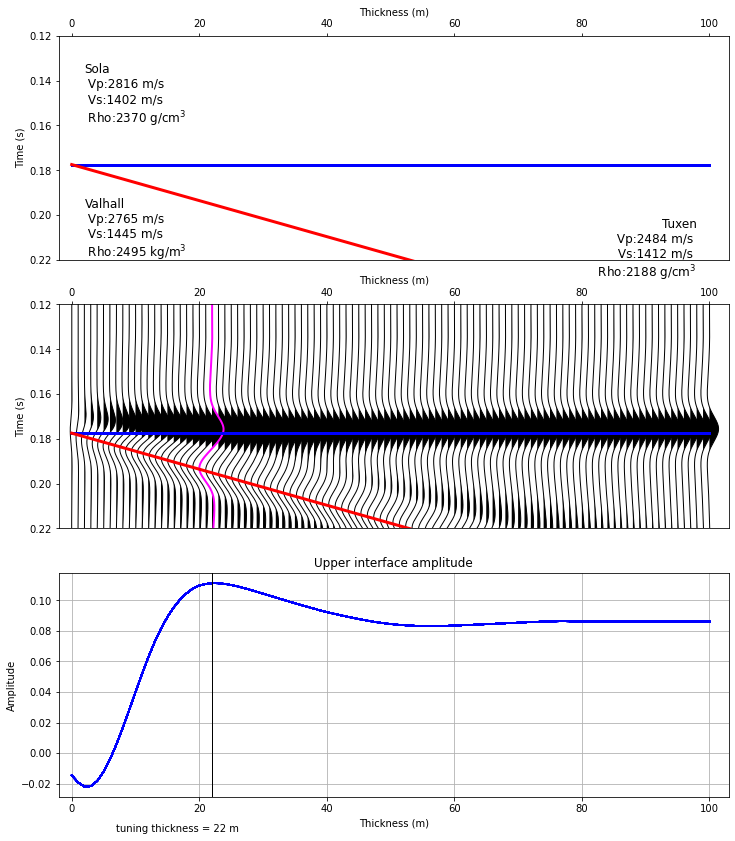

In [39]:
##   3-Layer Model Parameters [Layer1, Layer2, Layer 3]

#mlo.plot_vawig(ax5, syn_zoep_cdp_well , t_plot_twt, 1)


vp_mod = np.array([resSec['Vp'].loc[resSec['F_label']=='Sola'].mean(), (resSec['Vp'].loc[resSec['F_label']=='U. Tuxen'].mean() + resSec['Vp'].loc[resSec['F_label']=='L. Tuxen'].mean())/2., resSec['Vp'].loc[resSec['F_label']=='Valhall'].mean()])  # P-wave velocity (m/s)
vs_mod = np.array([resSec['Vs'].loc[resSec['F_label']=='Sola'].mean(), (resSec['Vs'].loc[resSec['F_label']=='U. Tuxen'].mean()+ resSec['Vs'].loc[resSec['F_label']=='L. Tuxen'].mean())/2. , resSec['Vs'].loc[resSec['F_label']=='Valhall'].mean()])  # S-wave velocity (m/s)
rho_mod= np.array([resSec['RHOZ_edt'].loc[resSec['F_label']=='Sola'].mean(), (resSec['RHOZ_edt'].loc[resSec['F_label']=='U. Tuxen'].mean()+resSec['RHOZ_edt'].loc[resSec['F_label']=='L. Tuxen'].mean())/2., resSec['RHOZ_edt'].loc[resSec['F_label']=='Valhall'].mean()])         # Density (g/cc)
#
dz_min = 0.0   # Minimum thickness of Layer 2 (m)
dz_max = 100.0  # Maximum thickness of Layer 2 (m)
dz_step= 1.0   # Thickness step from trace-to-trace (normally 1.0 m)
#   Trace Parameters
tmin = 0.0
tmax = 0.3

##   Plot Parameters
min_plot_time = 0.12
max_plot_time = 0.22
excursion = 2

###########################################################
#
#       FUNCTIONS DEFINITIONS
#

def plot_vawig(axhdl, data, t, excursion, highlight=None):
        import numpy as np
        import matplotlib.pyplot as plt

        [ntrc, nsamp] = data.shape
        t = np.hstack([0, t, t.max()])

        for i in range(0, ntrc):
            tbuf = excursion * data[i] / np.max(np.abs(data)) + i

            tbuf = np.hstack([i, tbuf, i])

            if i==highlight:
                lw = 2
                clr = 'magenta'
            else:
                lw = 1
                clr = 'black'

            axhdl.plot(tbuf, t, color=clr, linewidth=lw)
            plt.fill_betweenx(t, tbuf, i, where=tbuf>i, facecolor='k', linewidth=0)
            #plt.fill_betweenx(t, tbuf, i, where=tbuf>i, facecolor=[0.6,0.6,1.0], linewidth=0)
            #plt.fill_betweenx(t, tbuf, i, where=tbuf<i, facecolor=[1.0,0.7,0.7], linewidth=0)


        axhdl.set_xlim((-excursion, ntrc+excursion))
        axhdl.xaxis.tick_top()
        axhdl.xaxis.set_label_position('top')
        axhdl.invert_yaxis()
        return
  
def calc_rc(vp_mod, rho_mod):
        '''
        rc_int = calc_rc(vp_mod, rho_mod)
        '''

        nlayers = len(vp_mod)
        nint = nlayers - 1

        rc_int = []
        for i in range(0, nint):
            buf1 = vp_mod[i+1]*rho_mod[i+1]-vp_mod[i]*rho_mod[i]
            buf2 = vp_mod[i+1]*rho_mod[i+1]+vp_mod[i]*rho_mod[i]
            buf3 = buf1/buf2
            rc_int.append(buf3)

        return rc_int

def calc_times(z_int, vp_mod):
        '''
        t_int = calc_times(z_int, vp_mod)
        '''

        nlayers = len(vp_mod)
        nint = nlayers - 1

        t_int = []
        for i in range(0, nint):
            if i == 0:
                tbuf = z_int[i]/vp_mod[i]
                t_int.append(tbuf)
            else:
                zdiff = z_int[i]-z_int[i-1]
                tbuf = 2*zdiff/vp_mod[i] + t_int[i-1]
                t_int.append(tbuf)

        return t_int

def digitize_model(rc_int, t_int, t):
        '''
        rc = digitize_model(rc, t_int, t)

        rc = reflection coefficients corresponding to interface times
        t_int = interface times
        t = regularly sampled time series defining model sampling
        '''

        import numpy as np

        nlayers = len(rc_int)
        nint = nlayers - 1
        nsamp = len(t)

        rc = list(np.zeros(nsamp,dtype='float'))
        lyr = 0

        for i in range(0, nsamp):

            if t[i] >= t_int[lyr]:
                rc[i] = rc_int[lyr]
                lyr = lyr + 1    

            if lyr > nint:
                break

        return rc
    
    
    ##########################################################
#
#       COMPUTATIONS BELOW HERE...
#
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nmodel = int((dz_max-dz_min)/dz_step+1)


#   Calculate reflectivities from model parameters
rc_int = calc_rc(vp_mod, rho_mod)

syn_zo = []
rc_zo = []
lyr_times = []
for model in range(0, nmodel):
    
        #   Calculate interface depths
        z_int = [500.0]
        z_int.append(z_int[0]+dz_min+dz_step*model)

        #   Calculate interface times
        t_int = calc_times(z_int, vp_mod)
        lyr_times.append(t_int)

        #   Digitize 3-layer model
        nsamp = int((tmax-tmin)/dt) + 1
        t = []
        for i in range(0,nsamp):
            t.append(i*dt)

        rc = digitize_model(rc_int, t_int, t)
        rc_zo.append(rc)

        #   Convolve wavelet with reflectivities
        syn_buf = np.convolve(rc, wavelet_seismic, mode='same')     ###### WAVELET CONVOLUTION HAPPENS HERE
        syn_buf = list(syn_buf)
        syn_zo.append(syn_buf)
        #print("finished step %i" % (model))

syn_zo = np.array(syn_zo)
t = np.array(t)
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')

# Use the transpose because rows are traces;
# columns are time samples.
max_amp = np.zeros(syn_zo.shape[0])
thickness = np.zeros(syn_zo.shape[0])
for i in range(syn_zo.shape[0]):
        max_amp[i] = np.min(syn_zo[i,:])
#max_amp.argmax()

#tuning_trace = max_amp.argmax()#np.argmin((syn_zo.T)) % syn_zo.T.shape[1]
#tuning_thickness = max_amp.argmax()
tuning_trace = np.argmax(np.abs(syn_zo.T)) % syn_zo.T.shape[1]
#tuning_thickness = tuning_trace * dz_step

#   Plotting Code
[ntrc, nsamp] = syn_zo.shape

fig = plt.figure(figsize=(12, 14))
fig.set_facecolor('white')

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0])
ax0.plot(lyr_times[:,0], color='blue', lw=3)
ax0.plot(lyr_times[:,1], color='red', lw=3)
ax0.set_ylim((min_plot_time,max_plot_time))
ax0.invert_yaxis()
ax0.set_xlabel('Thickness (m)')
ax0.set_ylabel('Time (s)')
plt.text(2,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.+0.01,
        '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} g/cm$^3$'.format('Sola' ,np.str(np.int(vp_mod[0])), np.str(np.int(vs_mod[0])),np.str(np.int(rho_mod[0]))),
        fontsize=12)
plt.text(dz_max/dz_step - 2,
        lyr_times[-1,0] + (lyr_times[-1,1] - lyr_times[-1,0])/2.+0.01,
        '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} g/cm$^3$'.format('Tuxen' ,np.str(np.int(vp_mod[1])), np.str(np.int(vs_mod[1])),np.str(np.int(rho_mod[1]))),
        fontsize=12,
        horizontalalignment='right')
plt.text(2,
        lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.+0.02,
        '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} kg/m$^3$'.format('Valhall' ,np.str(np.int(vp_mod[2])), np.str(np.int(vs_mod[2])),np.str(np.int(rho_mod[2]))),
        fontsize=12)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
ax0.set_xlim((-excursion, ntrc+excursion))

tuning_trace = 20+np.argmax(syn_zo[:,lyr_indx[:,0]][20:40,0])

ax1 = fig.add_subplot(gs[1])
plot_vawig(ax1, syn_zo, t, excursion, highlight=tuning_trace)
ax1.plot(lyr_times[:,0], color='blue', lw=3)
ax1.plot(lyr_times[:,1], color='red', lw=3)
ax1.set_ylim((min_plot_time,max_plot_time))
ax1.invert_yaxis()
ax1.set_xlabel('Thickness (m)')
ax1.set_ylabel('Time (s)')

ax2 = fig.add_subplot(gs[2])
ax2.plot(syn_zo[:,lyr_indx[:,0]], color='blue')
ax2.set_xlim((-excursion, ntrc+excursion))
ax2.axvline(tuning_trace, color='k', lw=1)
ax2.grid()
ax2.set_title('Upper interface amplitude')
ax2.set_xlabel('Thickness (m)')
ax2.set_ylabel('Amplitude')
plt.text(tuning_trace -15,
        plt.ylim()[0] * 1.1-0.02,
        'tuning thickness = {0} m'.format(str(tuning_trace),
        fontsize=16))

#if savefig == True:
#    plt.savefig(fig_path+'wedge_tuning_solatuxenvalhall.svg',dpi=400)
#    print('FIGURE SAVED')
plt.show()

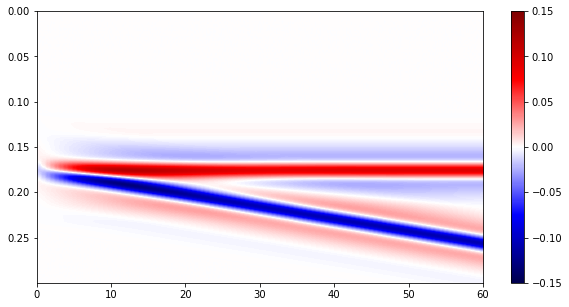

In [40]:
plt.figure(figsize=(10,5))
plt.imshow(syn_zo.T, cmap="seismic", extent = (0,60,t.max(),t.min()) ,vmin=-.15,vmax=.15,  aspect='auto')
plt.colorbar()
plt.show()

# Tuning effect live demo <a id='wedge_interactive'></a>

In [46]:
Sola = resSec.loc[(resSec['DEPTH'] >= intf[6]) &  (resSec['DEPTH'] <= intf[6+1])].copy()


def f(r_Sw, r_por, r_shv):
    
    Sola['sw_mod'] = r_Sw
    Sola['phi_mod'] = r_por
    Sola['lit_mod'] = r_shv
    
    
    # Physical properties of constituents
    K_o=0.62     # oil
    Rho_o=0.8

    K_w=2.3
    G_w=0         # water
    Rho_w=1.03

    K_ca=71  
    G_ca=30       # calcite
    Rho_ca=2.71

    K_q=37.3  
    G_q=44.8      # quartz
    Rho_q=2.65

    K_k=15  
    G_k=7       # shale
    Rho_k=2.7


    # Volume fraction of large calcite and large silicates 
    Vc_l = 0.1 # large calcite
    Vq_l = 0 # large quartz
    Vk_l = 0.05 # large kaolinite

    # Volume fraction of small calcite and suspended silicates
    Vc_s = 0.7 # small calcite
    Vq_s = 0.1 # small quartz
    Vk_s = 0.05 # small kaolinite

    Vtot_sh = Vk_s + Vk_l
    Vtot_r = Vc_l+Vq_l+Vc_s+Vq_s

    c_l = np.zeros(len(Sola['phi_mod'])) 
    c_l[:] = np.nan
    c_s = np.zeros(len(Sola['phi_mod']))
    c_s[:] = np.nan
    c_l = np.zeros(len(Sola['phi_mod']))
    c_l[:] = np.nan
    q_l = np.zeros(len(Sola['phi_mod']))
    q_l[:] = np.nan
    q_s = np.zeros(len(Sola['phi_mod']))
    q_s[:] = np.nan
    k_s = np.zeros(len(Sola['phi_mod']))
    k_s[:] = np.nan
    k_l = np.zeros(len(Sola['phi_mod']))
    k_l[:] = np.nan

    Por = np.zeros(len(Sola['phi_mod']))
    Por[:] = np.nan
    S_w = np.zeros(len(Sola['phi_mod']))
    S_w[:] = np.nan

    # Dynamic reservoir properties from log data
    for n in range(len(Sola['phi_mod'])):

        # Normalizing the solid volume fractions according to the shale log
        c_l[n] = (1-Sola['lit_mod'].iloc[n]) * Vc_l/Vtot_r
        c_s[n] = (1-Sola['lit_mod'].iloc[n]) * Vc_s/Vtot_r
        q_l[n] = (1-Sola['lit_mod'].iloc[n]) * Vq_l/Vtot_r
        q_s[n] = (1-Sola['lit_mod'].iloc[n]) * Vq_s/Vtot_r
        k_s[n] = Sola['lit_mod'].iloc[n] * Vk_s/Vtot_sh
        k_l[n] = Sola['lit_mod'].iloc[n] * Vk_l/Vtot_sh

        Por[n] = Sola['phi_mod'].iloc[n]
        S_w[n] = Sola['sw_mod'].iloc[n]

    # Reservoir properties
    Por_c = 0.66 # Critical porosity
    fluidMix = 'reuss'
    
    
    # Modeling

    IFc = np.linspace(0,1,6) # Iso-frame value for the suspended chalk
    IFs = 0.2 # Iso-frame value for the suspended shale
    IFq = 0.2 # Iso-frame value for the suspended quartz

    K_sus = np.nan*np.ones((Por.size,IFc.size))
    K_IF = np.nan*np.ones((Por.size,IFc.size))
    G_IF = np.nan*np.ones((Por.size,IFc.size))
    M_IF = np.nan*np.ones((Por.size,IFc.size))
    Vp_IF = np.nan*np.ones((Por.size,IFc.size))
    Vs_IF = np.nan*np.ones((Por.size,IFc.size))
    AI_IF = np.nan*np.ones((Por.size,IFc.size))
    PS_IF = np.nan*np.ones((Por.size,IFc.size))
    Rho = np.nan*np.ones((Por.size,IFc.size))

    K_f = S_w/K_w + (1-S_w)/K_o
    Rho =  Por*((Rho_w*S_w) + (Rho_o*(1-S_w))) + ((1-Por)*((c_s+c_l)*Rho_ca + Rho_k*(k_s+k_l) + Rho_q*(q_s+q_l))) 

    #for n in range(len(IFc)):
    n=2
    K_sus[:,n] = ( Por/Por_c*K_f + (1-Por/Por_c)*( (c_s*(1-IFc[n])/K_ca) + (q_s*(1-IFq)/K_q) + (k_s*(1-IFs)/K_k) ) )**(-1) * (Por/Por_c + (1-Por/Por_c)*( c_s*(1-IFc[n]) + q_s*(1-IFq) + k_s*(1-IFs)) )

    K_IF[:,n] = ( ((Por/Por_c)/(K_sus[:,n] + (4/3)*G_ca)) + (1-(Por/Por_c))* ( (((1-IFc[n])*c_s + (1-IFq)*q_s + (1-IFs)*k_s)/(K_sus[:,n] + (4/3)*G_ca)) + ((IFc[n]*c_s+c_l) / (K_ca + (4/3)*G_ca)) + ( (IFq*q_s+q_l) / (K_q + (4/3)*G_ca)) + ((IFs*k_s+k_l) / (K_k + (4/3)*G_ca)) ))**(-1) - (4/3)*G_ca

    zeta = (G_ca/6) * ((9*K_ca + 8*G_ca)/(K_ca + 2*G_ca));

    G_IF[:,n] = ( ((Por/Por_c)/zeta) +  (1-(Por/Por_c))*( (((1-IFc[n])*c_s + (1-IFq)*q_s + (1-IFs)*k_s)/(zeta)) + ((IFc[n]*c_s+c_l)/(G_ca + zeta)) + ((IFq*q_s+q_l)/(G_q + zeta)) + ( (IFs*k_s+k_l) / (G_k + zeta))) )**(-1) - zeta

    M_IF[:,n] = K_IF[:,n] + (4/3)*G_IF[:,n]

    Vp_IF[:,n] = np.sqrt((K_IF[:,n] + (4/3)*G_IF[:,n]) / Rho)
    Vs_IF[:,n] = np.sqrt(G_IF[:,n] / Rho)

    AI_IF[:,n] = Vp_IF[:,n] * Rho
    PS_IF[:,n] = Vp_IF[:,n] / Vs_IF[:,n]


        
        
    #   Calculate reflectivities from model parameters
    
    Sola['vp_mod'] = Vp_IF[0,2]
    Sola['vs_mod'] = Vs_IF[0,2]
    
    #phi_mod[6] = Por[0]
    #rho_mod[6] = Rho[0]*1000.
    #vp_mod[6] = Vp_IF[0,2]*1000.
    #vs_mod[6] = Vs_IF[0,2]*1000.
    
    
   
    vp_mod = np.array([resSec['Vp'].loc[resSec['F_label']=='Hidra'].mean() ,Vp_IF[0,2]*1000., (resSec['Vp'].loc[resSec['F_label']=='U. Tuxen'].mean() + resSec['Vp'].loc[resSec['F_label']=='L. Tuxen'].mean())/2.])  # P-wave velocity (m/s)
    vs_mod = np.array([resSec['Vs'].loc[resSec['F_label']=='Hidra'].mean() , Vs_IF[0,2]*1000., (resSec['Vs'].loc[resSec['F_label']=='U. Tuxen'].mean()+ resSec['Vs'].loc[resSec['F_label']=='L. Tuxen'].mean())/2.])  # S-wave velocity (m/s)
    rho_mod= np.array([resSec['RHOZ_edt'].loc[resSec['F_label']=='Hidra'].mean() , Rho[0]*1000., (resSec['RHOZ_edt'].loc[resSec['F_label']=='U. Tuxen'].mean()+resSec['RHOZ_edt'].loc[resSec['F_label']=='L. Tuxen'].mean())/2.])         # Density (g/cc)

    dz_min = 0.0   # Minimum thickness of Layer 2 (m)
    dz_max = 60.0  # Maximum thickness of Layer 2 (m)
    dz_step= 1.0   # Thickness step from trace-to-trace (normally 1.0 m)
    #   Trace Parameters
    tmin = 0.0
    tmax = 0.3

    ##   Plot Parameters
    min_plot_time = tmin
    max_plot_time = tmax
    excursion = 2
    
    
    
    nlayers = len(vp_mod)
    nint = nlayers - 1
    nmodel = int((dz_max-dz_min)/dz_step+1)


    #   Calculate reflectivities from model parameters
    rc_int = calc_rc(vp_mod, rho_mod)

    syn_zo = []
    rc_zo = []
    lyr_times = []
    for model in range(0, nmodel):

            #   Calculate interface depths
            z_int = [500.0]
            z_int.append(z_int[0]+dz_min+dz_step*model)

            #   Calculate interface times
            t_int = calc_times(z_int, vp_mod)
            lyr_times.append(t_int)

            #   Digitize 3-layer model
            nsamp = int((tmax-tmin)/dt) + 1
            t = []
            for i in range(0,nsamp):
                t.append(i*dt)

            rc = digitize_model(rc_int, t_int, t)
            rc_zo.append(rc)

            #   Convolve wavelet with reflectivities
            syn_buf = np.convolve(rc, wavelet_seismic, mode='same')     ###### WAVELET CONVOLUTION HAPPENS HERE
            syn_buf = list(syn_buf)
            syn_zo.append(syn_buf)
            #print("finished step %i" % (model))

    syn_zo = np.array(syn_zo)
    t = np.array(t)
    lyr_times = np.array(lyr_times)
    lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')

    # Use the transpose because rows are traces;
    # columns are time samples.
    max_amp = np.zeros(syn_zo.shape[0])
    thickness = np.zeros(syn_zo.shape[0])
    for i in range(syn_zo.shape[0]):
            max_amp[i] = np.min(syn_zo[i,:])
    #max_amp.argmax()

    #tuning_trace = max_amp.argmax()#np.argmin((syn_zo.T)) % syn_zo.T.shape[1]
    #tuning_thickness = max_amp.argmax()
    tuning_trace = np.argmax(np.abs(syn_zo.T)) % syn_zo.T.shape[1]
    #tuning_thickness = tuning_trace * dz_step

    #   Plotting Code
    [ntrc, nsamp] = syn_zo.shape

    fig = plt.figure(figsize=(20, 14))
    fig.set_facecolor('white')

    gs = gridspec.GridSpec(12,12)#, height_ratios=[1, 1, 1])

    ax0 = fig.add_subplot(gs[0:4,0:6])
    ax0.plot(lyr_times[:,0], color='blue', lw=3)
    ax0.plot(lyr_times[:,1], color='red', lw=3)
    ax0.set_ylim((min_plot_time,max_plot_time))
    ax0.invert_yaxis()
    ax0.set_xlabel('Sola Thickness (m)')
    ax0.set_ylabel('Time (s)')
    plt.text(2,
            min_plot_time + (lyr_times[0,0] - min_plot_time)/2.+0.01,
            '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} g/cm$^3$'.format('Hidra' ,np.str(np.int(vp_mod[0])), np.str(np.int(vs_mod[0])),np.str(np.int(rho_mod[0]))),
            fontsize=12)
    plt.text(dz_max/dz_step - 2,
            lyr_times[-1,0] + (lyr_times[-1,1] - lyr_times[-1,0])/2.+0.01,
            '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} g/cm$^3$'.format('Sola' ,np.str(np.int(vp_mod[1])), np.str(np.int(vs_mod[1])),np.str(np.int(rho_mod[1]))),
            fontsize=12,
            horizontalalignment='right')
    plt.text(2,
            lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.+0.02,
            '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} kg/m$^3$'.format('Tuxen' ,np.str(np.int(vp_mod[2])), np.str(np.int(vs_mod[2])),np.str(np.int(rho_mod[2]))),
            fontsize=12)
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')
    ax0.set_xlim((-excursion, ntrc+excursion))

    #tuning_trace = 20+np.argmax(syn_zo[:,lyr_indx[:,0]][20:40,0])

    ax1 = fig.add_subplot(gs[4:8,0:6])
    im1 = ax1.imshow(syn_zo.T, cmap="seismic", extent = (0,60,t.max(),t.min()) ,vmin=-.35,vmax=.35,  aspect='auto')
    ax1.plot(lyr_times[:,0], color='k', lw=3,ls='--',alpha=0.5)
    ax1.plot(lyr_times[:,1], color='k', lw=3,ls='--',alpha=0.5)
    #ax1.colorbar()
#    plot_vawig(ax1, syn_zo, t, excursion, highlight=tuning_trace)
#    ax1.plot(lyr_times[:,0], color='blue', lw=3)
#    ax1.plot(lyr_times[:,1], color='red', lw=3)
#    ax1.set_ylim((min_plot_time,max_plot_time))
#    ax1.invert_yaxis()
#    ax1.set_xlabel('Thickness (m)')
#    ax1.set_ylabel('Time (s)')
    #fig.colorbar(im1, ax=ax1, orientation='horizontal')

    
    
    ax2 = fig.add_subplot(gs[8:,0:6])
    ax2.plot(syn_zo[:,lyr_indx[:,0]]/np.abs(syn_zo[:,lyr_indx[:,0]]).max(), lw=3,color='k')
    ax2.set_xlim((-excursion, ntrc+excursion))
    #ax2.axvline(tuning_trace, color='k', lw=1)
    ax2.set_ylim(0,1.1)
    ax2.grid()
    ax2.set_title('Upper interface amplitude')
    ax2.set_xlabel('Sola Thickness (m)')
    ax2.set_ylabel('Amplitude')
#    plt.text(tuning_trace -15,
#            plt.ylim()[0] * 1.1-0.02,
#            'tuning thickness = {0} m'.format(str(tuning_trace),
#            fontsize=16))
#
 

#gs2 = gridspec.GridSpec(nrows=12, ncols=12, figure=fig,hspace =1 ,wspace=0.25)
#
    ax8 = fig.add_subplot( gs[4:8, 6:7])
    ax9 = fig.add_subplot( gs[4:8, 7:8])
    ax10 = fig.add_subplot(gs[4:8, 8:9])
    ax11 = fig.add_subplot(gs[4:8, 9:10])



    size, top, base = 256, 0.4, 0.6
    layer='hard'
    polarity='reverse'
    freq='low'
    phase=180
    style='ramp'
    cmap=None
    cbar = np.linspace(-1, 1, size).reshape(-1, 1)
    freqs = {'vhi': 60, 'hi': 30, 'med': 15, 'lo': 7.5,
                 'vhigh': 60, 'high': 30, 'medium': 15, 'low': 7.5,
                 'mod': 15, 'mid': 15}
    backgr = 'soft' if layer == 'hard' else 'hard'
    value = 1 if layer == 'hard' else 0


    _, v, _, syn = make_synthetic(size, top, base, value, freq=freqs[freq], phase=phase)


    # Plot the earth model.
    ax = ax8
    cmap_ = 'Greys'
    ax.imshow(v.reshape(-1, 1), aspect='auto', cmap=cmap_, vmin=-1.5, vmax=1.5)
    ax.axhline(top*size, c='w', lw=4)
    ax.axhline(base*size, c='w', lw=4)
    ax.axvline(0.55, c='w', lw=1)  # Total hack to adjust RHS
    ax.text(0, size/4.75, backgr, ha='center', va='center', color=get_colour(cmap_, (1-value)*256))
    ax.text(0, size/2+0.75, layer, ha='center', va='center', color=get_colour(cmap_, (value)*256))

    # Plot the impedance diagram.
    ax = ax9
    cmap_ = 'Greys'
    ax.imshow(v.reshape(-1, 1), aspect='auto', cmap=cmap_, vmin=0, vmax=2)
    ax.axvline(-0.5, c=(0.58, 0.58, 0.58), lw=10)
    ax.text(0.45, 2*size/8, 'imp', ha='right', va='center', color='k')
    ax.annotate("", xy=(0.5, size/8), xytext=(-0.2, size/8), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

    # Plot the waveform.
    ax = ax10
    y = np.arange(syn.size)
    ax.plot(syn, y, 'k', lw=0.5)
    ax.fill_betweenx(y, syn, 0, where=syn>0, color='k')
    ax.invert_yaxis()
    ax.text(0.65, size/8, '+', ha='center', va='center')
    ax.text(-0.9, size/8, '–', ha='center', va='center')

    # Plot the colourbar.
    ax = ax11
    cmap = 'seismic'
    frac = 1/8
    top_col = get_colour(cmap, frac)
    bot_col = get_colour(cmap, 7*frac)
    ax.imshow(cbar, cmap=cmap, aspect='auto')
    ax.text(0, frac*size, '+', ha='center', va='center', color=top_col)
    ax.text(0, 7*frac*size, '–', ha='center', va='center', color=bot_col)

    # Make final adjustments to subplots and figure.
    ax8.set_axis_off()
    ax9.set_axis_off()
    ax10.set_axis_off()
    ax11.set_axis_off()

    plt.tight_layout()


interactive_plot = interactive(f, r_Sw=(0, 1., .05),r_por=(0,Por_c,.05), r_shv = (0,1.,.05),continuous_update=False,)
output = interactive_plot.children[-1]
output.layout.height = '1000x'
interactive_plot




interactive(children=(FloatSlider(value=0.5, description='r_Sw', max=1.0, step=0.05), FloatSlider(value=0.3000…

In [42]:
print(t.max(),t.min(),dt)
t.shape

0.2999 0.0 0.0001


(3000,)

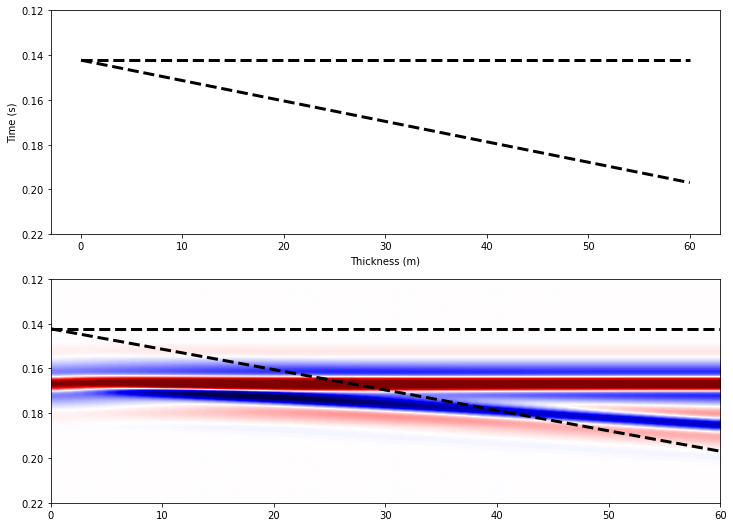

In [43]:
Sola = resSec.loc[(resSec['DEPTH'] >= intf[6]) &  (resSec['DEPTH'] <= intf[6+1])].copy()

r_Sw = 0.3
r_por = 0.4
    
Sola['sw_mod'] = r_Sw
Sola['phi_mod'] = r_por

# Physical properties of constituents
K_o=0.62     # oil
Rho_o=0.8

K_w=2.3
G_w=0         # water
Rho_w=1.03

K_ca=71  
G_ca=30       # calcite
Rho_ca=2.71

K_q=37.3  
G_q=44.8      # quartz
Rho_q=2.65

K_k=15  
G_k=7       # shale
Rho_k=2.7


# Volume fraction of large calcite and large silicates 
Vc_l = 0.1 # large calcite
Vq_l = 0 # large quartz
Vk_l = 0.05 # large kaolinite

# Volume fraction of small calcite and suspended silicates
Vc_s = 0.7 # small calcite
Vq_s = 0.1 # small quartz
Vk_s = 0.05 # small kaolinite

Vtot_sh = Vk_s + Vk_l
Vtot_r = Vc_l+Vq_l+Vc_s+Vq_s

c_l = np.zeros(len(Sola['phi_mod'])) 
c_l[:] = np.nan
c_s = np.zeros(len(Sola['phi_mod']))
c_s[:] = np.nan
c_l = np.zeros(len(Sola['phi_mod']))
c_l[:] = np.nan
q_l = np.zeros(len(Sola['phi_mod']))
q_l[:] = np.nan
q_s = np.zeros(len(Sola['phi_mod']))
q_s[:] = np.nan
k_s = np.zeros(len(Sola['phi_mod']))
k_s[:] = np.nan
k_l = np.zeros(len(Sola['phi_mod']))
k_l[:] = np.nan

Por = np.zeros(len(Sola['phi_mod']))
Por[:] = np.nan
S_w = np.zeros(len(Sola['phi_mod']))
S_w[:] = np.nan

# Dynamic reservoir properties from log data
for n in range(len(Sola['phi_mod'])):

    # Normalizing the solid volume fractions according to the shale log
    c_l[n] = (1-Sola['lit_mod'].iloc[n]) * Vc_l/Vtot_r
    c_s[n] = (1-Sola['lit_mod'].iloc[n]) * Vc_s/Vtot_r
    q_l[n] = (1-Sola['lit_mod'].iloc[n]) * Vq_l/Vtot_r
    q_s[n] = (1-Sola['lit_mod'].iloc[n]) * Vq_s/Vtot_r
    k_s[n] = Sola['lit_mod'].iloc[n] * Vk_s/Vtot_sh
    k_l[n] = Sola['lit_mod'].iloc[n] * Vk_l/Vtot_sh

    Por[n] = Sola['phi_mod'].iloc[n]
    S_w[n] = Sola['sw_mod'].iloc[n]

# Reservoir properties
Por_c = 0.66 # Critical porosity
fluidMix = 'reuss'


# Modeling

IFc = np.linspace(0,1,6) # Iso-frame value for the suspended chalk
IFs = 0.2 # Iso-frame value for the suspended shale
IFq = 0.2 # Iso-frame value for the suspended quartz

K_sus = np.nan*np.ones((Por.size,IFc.size))
K_IF = np.nan*np.ones((Por.size,IFc.size))
G_IF = np.nan*np.ones((Por.size,IFc.size))
M_IF = np.nan*np.ones((Por.size,IFc.size))
Vp_IF = np.nan*np.ones((Por.size,IFc.size))
Vs_IF = np.nan*np.ones((Por.size,IFc.size))
AI_IF = np.nan*np.ones((Por.size,IFc.size))
PS_IF = np.nan*np.ones((Por.size,IFc.size))
Rho = np.nan*np.ones((Por.size,IFc.size))

K_f = S_w/K_w + (1-S_w)/K_o
Rho =  Por*((Rho_w*S_w) + (Rho_o*(1-S_w))) + ((1-Por)*((c_s+c_l)*Rho_ca + Rho_k*(k_s+k_l) + Rho_q*(q_s+q_l))) 

#for n in range(len(IFc)):
n=2
K_sus[:,n] = ( Por/Por_c*K_f + (1-Por/Por_c)*( (c_s*(1-IFc[n])/K_ca) + (q_s*(1-IFq)/K_q) + (k_s*(1-IFs)/K_k) ) )**(-1) * (Por/Por_c + (1-Por/Por_c)*( c_s*(1-IFc[n]) + q_s*(1-IFq) + k_s*(1-IFs)) )

K_IF[:,n] = ( ((Por/Por_c)/(K_sus[:,n] + (4/3)*G_ca)) + (1-(Por/Por_c))* ( (((1-IFc[n])*c_s + (1-IFq)*q_s + (1-IFs)*k_s)/(K_sus[:,n] + (4/3)*G_ca)) + ((IFc[n]*c_s+c_l) / (K_ca + (4/3)*G_ca)) + ( (IFq*q_s+q_l) / (K_q + (4/3)*G_ca)) + ((IFs*k_s+k_l) / (K_k + (4/3)*G_ca)) ))**(-1) - (4/3)*G_ca

zeta = (G_ca/6) * ((9*K_ca + 8*G_ca)/(K_ca + 2*G_ca));

G_IF[:,n] = ( ((Por/Por_c)/zeta) +  (1-(Por/Por_c))*( (((1-IFc[n])*c_s + (1-IFq)*q_s + (1-IFs)*k_s)/(zeta)) + ((IFc[n]*c_s+c_l)/(G_ca + zeta)) + ((IFq*q_s+q_l)/(G_q + zeta)) + ( (IFs*k_s+k_l) / (G_k + zeta))) )**(-1) - zeta

M_IF[:,n] = K_IF[:,n] + (4/3)*G_IF[:,n]

Vp_IF[:,n] = np.sqrt((K_IF[:,n] + (4/3)*G_IF[:,n]) / Rho)
Vs_IF[:,n] = np.sqrt(G_IF[:,n] / Rho)

AI_IF[:,n] = Vp_IF[:,n] * Rho
PS_IF[:,n] = Vp_IF[:,n] / Vs_IF[:,n]




    #   Calculate reflectivities from model parameters

Sola['vp_mod'] = Vp_IF[0,2]
Sola['vs_mod'] = Vs_IF[0,2]

#phi_mod[6] = Por[0]
#rho_mod[6] = Rho[0]*1000.
#vp_mod[6] = Vp_IF[0,2]*1000.
#vs_mod[6] = Vs_IF[0,2]*1000.



vp_mod = np.array([resSec['Vp'].loc[resSec['F_label']=='Hidra'].mean() ,Vp_IF[0,2]*1000., (resSec['Vp'].loc[resSec['F_label']=='U. Tuxen'].mean() + resSec['Vp'].loc[resSec['F_label']=='L. Tuxen'].mean())/2.])  # P-wave velocity (m/s)
vs_mod = np.array([resSec['Vs'].loc[resSec['F_label']=='Hidra'].mean() , Vs_IF[0,2]*1000., (resSec['Vs'].loc[resSec['F_label']=='U. Tuxen'].mean()+ resSec['Vs'].loc[resSec['F_label']=='L. Tuxen'].mean())/2.])  # S-wave velocity (m/s)
rho_mod= np.array([resSec['RHOZ_edt'].loc[resSec['F_label']=='Hidra'].mean() , Rho[0]*1000., (resSec['RHOZ_edt'].loc[resSec['F_label']=='U. Tuxen'].mean()+resSec['RHOZ_edt'].loc[resSec['F_label']=='L. Tuxen'].mean())/2.])         # Density (g/cc)

dz_min = 0.0   # Minimum thickness of Layer 2 (m)
dz_max = 60.0  # Maximum thickness of Layer 2 (m)
dz_step= 1.0   # Thickness step from trace-to-trace (normally 1.0 m)
#   Trace Parameters
tmin = 0.0
tmax = 0.3

##   Plot Parameters
min_plot_time = 0.12
max_plot_time = 0.22
excursion = 2



nlayers = len(vp_mod)
nint = nlayers - 1
nmodel = int((dz_max-dz_min)/dz_step+1)


#   Calculate reflectivities from model parameters
rc_int = calc_rc(vp_mod, rho_mod)

syn_zo = []
rc_zo = []
lyr_times = []
for model in range(0, nmodel):

        #   Calculate interface depths
        z_int = [500.0]
        z_int.append(z_int[0]+dz_min+dz_step*model)

        #   Calculate interface times
        t_int = calc_times(z_int, vp_mod)
        lyr_times.append(t_int)

        #   Digitize 3-layer model
        nsamp = int((tmax-tmin)/dt) + 1
        t = []
        for i in range(0,nsamp):
            t.append(i*dt)

        rc = digitize_model(rc_int, t_int, t)
        rc_zo.append(rc)
    
        #   Convolve wavelet with reflectivities
        syn_buf = np.convolve(rc, wavelet_seismic, mode='same')     ###### WAVELET CONVOLUTION HAPPENS HERE
        syn_buf = list(syn_buf)
        syn_zo.append(syn_buf)
        #print("finished step %i" % (model))

syn_zo = np.array(syn_zo)
t = np.array(t)
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')

# Use the transpose because rows are traces;
# columns are time samples.
max_amp = np.zeros(syn_zo.shape[0])
thickness = np.zeros(syn_zo.shape[0])
for i in range(syn_zo.shape[0]):
        max_amp[i] = np.min(syn_zo[i,:])
#max_amp.argmax()

#tuning_trace = max_amp.argmax()#np.argmin((syn_zo.T)) % syn_zo.T.shape[1]
#tuning_thickness = max_amp.argmax()
tuning_trace = np.argmax(np.abs(syn_zo.T)) % syn_zo.T.shape[1]
#tuning_thickness = tuning_trace * dz_step

#   Plotting Code
[ntrc, nsamp] = syn_zo.shape

fig = plt.figure(figsize=(12, 14))
fig.set_facecolor('white')

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0])
ax0.plot(lyr_times[:,0], color='k', lw=3,ls='--')
ax0.plot(lyr_times[:,1], color='k', lw=3,ls='--')
ax0.set_ylim((min_plot_time,max_plot_time))
ax0.invert_yaxis()
ax0.set_xlabel('Thickness (m)')
ax0.set_ylabel('Time (s)')
#plt.text(2,
#        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.+0.01,
#        '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} g/cm$^3$'.format('Sola' ,np.str(np.int(vp_mod[0])), np.str(np.int(vs_mod[0])),np.str(np.int(rho_mod[0]))),
#        fontsize=12)
#plt.text(dz_max/dz_step - 2,
#        lyr_times[-1,0] + (lyr_times[-1,1] - lyr_times[-1,0])/2.+0.01,
#        '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} g/cm$^3$'.format('Tuxen' ,np.str(np.int(vp_mod[1])), np.str(np.int(vs_mod[1])),np.str(np.int(rho_mod[1]))),
#        fontsize=12,
#        horizontalalignment='right')
#plt.text(2,
#        lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.+0.02,
#        '{}\n Vp:{} m/s \n Vs:{} m/s \n Rho:{} kg/m$^3$'.format('Valhall' ,np.str(np.int(vp_mod[2])), np.str(np.int(vs_mod[2])),np.str(np.int(rho_mod[2]))),
#        fontsize=12)
#plt.gca().xaxis.tick_top()
#plt.gca().xaxis.set_label_position('top')
#ax0.set_xlim((-excursion, ntrc+excursion))

#tuning_trace = 20+np.argmax(syn_zo[:,lyr_indx[:,0]][20:40,0])

ax1 = fig.add_subplot(gs[1])
ax1.imshow(syn_zo.T, cmap="seismic", extent = (0,60,max_plot_time,min_plot_time) ,vmin=-.15,vmax=.15,  aspect='auto')
ax1.plot(lyr_times[:,0], color='k', lw=3,ls='--')
ax1.plot(lyr_times[:,1], color='k', lw=3,ls='--')
#    plot_vawig(ax1, syn_zo, t, excursion, highlight=tuning_trace)
#    ax1.plot(lyr_times[:,0], color='blue', lw=3)
#    ax1.plot(lyr_times[:,1], color='red', lw=3)
#    ax1.set_ylim((min_plot_time,max_plot_time))
#    ax1.invert_yaxis()
#    ax1.set_xlabel('Thickness (m)')
#    ax1.set_ylabel('Time (s)')

#    ax2 = fig.add_subplot(gs[2])
#    ax2.plot(syn_zo[:,lyr_indx[:,0]], color='blue')
#    ax2.set_xlim((-excursion, ntrc+excursion))
#    ax2.axvline(tuning_trace, color='k', lw=1)
#    ax2.grid()
#    ax2.set_title('Upper interface amplitude')
#    ax2.set_xlabel('Thickness (m)')
#    ax2.set_ylabel('Amplitude')
#    plt.text(tuning_trace -15,
#            plt.ylim()[0] * 1.1-0.02,
#            'tuning thickness = {0} m'.format(str(tuning_trace),
#            fontsize=16))
#




In [44]:
Sola['lit_mod']

2081    0.143943
2082    0.143943
2083    0.143943
2084    0.143943
2085    0.143943
          ...   
2193    0.143943
2194    0.143943
2195    0.143943
2196    0.143943
2197    0.143943
Name: lit_mod, Length: 117, dtype: float64

# Wavelet Estimation from BO-2X

Source:
<a href='https://github.com/seg/tutorials-2016/blob/master/1606_Wavelet_estimation/Wavelet_estimation_for_well_ties.ipynb'> [GITHUB CODE]

<a href='https://wiki.seg.org/wiki/Wavelet_estimation_for_well_ties'> [WIKI]


In [45]:
# Synthetic Post-stack Trace:
syn_s = syn_zoep_pp.T.sum(axis=1)*10000

# Post-stack @ BO-2X
s = gather_bo2[:,:].sum(axis=0)
t = np.linspace(t_start,t_stop,gather_bo2.shape[-1])

plt.figure(figsize=(10,10))
plt.subplot(141)
plt.plot(np.array(rc),t_plot_twt,'k')
plt.title('BO-2X RC')
plt.ylim(tmax,tmin);

plt.subplot(142)
plt.plot(syn_s, t_plot_twt,'k')
plt.ylim(tmax,tmin);
plt.fill_betweenx(t_plot_twt, syn_s, 0, syn_s > 0, color='k', alpha=.5)
#ax2.fill_betweenx(t, s, 0, s > 0, color='k', alpha=1.0)
plt.title('Synth Post-stack')

plt.subplot(143)
plt.title('Raw Stack Signal')
plt.plot(s, t)
plt.ylim(tmax,tmin);
plt.fill_betweenx(t, s, 0, s > 0, color='k', alpha=.5)

s_bo2 = gather_sm_bo2.T.sum(axis=0)
plt.subplot(144)
plt.title('Splined Signal')
plt.plot(s_bo2, time_sm)
plt.ylim(tmax,tmin);
plt.fill_betweenx(time_sm, s_bo2, 0, s_bo2 > 0, color='k', alpha=.5)
print(tmin, tmax, time_sm.min(), time_sm.max(), time_sm.shape,np.array(rc).shape )

NameError: name 'syn_zoep_pp' is not defined

In [ ]:
# Spectral Analysis - Uninterpolated signal



wavelet_total1 = pd.read_csv(path_wavelets+'W6_A_FIN_wavelet_0_0_deg_awos.wvl',skiprows=0)
wavelet_total1 = np.squeeze(np.array(wavelet_total1))
#print('shape=',wavelet_total1.shape)

x = np.linspace(-wavelet_total1[1]*wavelet_total1[2],wavelet_total1[1]*wavelet_total1[2],num=np.int(wavelet_total1[0]))
y = wavelet_total2[3:]



#¤freqs = [5, 25, 60, 100]
#c = 1.0
#points = c*np.array([95,110,87,85])

#dt = np.round(np.diff(t)[0],3)
s = wavelet_total1
dt = 0.004


amp_spec = np.abs(np.fft.rfft(s))
f = np.fft.rfftfreq(len(s), d=dt)
P = 20 * np.log10(amp_spec)   #Power in Decibel Scale

fig02 = plt.figure()
ax = fig02.add_subplot(111)
ax.plot(f, P,'m')
#ax.plot(freqs, points, 'ko-', lw=1, zorder=2, ms=6)
#for fr in freqs:
#    ax.text(fr,1.20*points[0], fr, ha='center', va='top', fontsize=15)
ax.set_xlabel('frequency (Hz)', fontsize=14)
ax.set_ylabel('power (dB)', fontsize=14)
#print(f[1],dt, s.shape)




In [ ]:
path_wavelets

In [ ]:
phase_spec = np.angle(np.fft.rfft(s))
plt.plot(f, phase_spec, 'm')
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
plt.xlabel('frequency (Hz)', fontsize=14)
plt.ylabel('phase', fontsize=14)

from bruges.filters.wavelets import ormsby, ricker

duration = 0.256 # seconds
orms = ormsby(duration, dt=0.004, f=freqs)
tw = np.arange(-len(orms)//2,len(orms)//2,1)*dt

In [ ]:
# Autocorrelation try-out (assumes zero-phase)

dw = s.size//2 # number of samples to display on either side of zero
acorr = np.correlate(s, s, mode='same')
w1 = acorr[len(s)//2-dw//2:len(s)//2+dw//2]


def norm(data):
    return data/np.amax(data)

fig04 =plt.figure(figsize=(8,3))
ax = fig04.add_axes([0.1, 0.15, 0.8, 0.7])
ax.plot(tw, orms, 'blue', lw=1, alpha=0.75, 
         label='Ormsby (%i-%i-%i-%i Hz)' %(freqs[0],freqs[1],freqs[2],freqs[3]))
ax.plot(np.arange(0,len(w1))*dt-0.076, norm(w1), 'k', lw=1, alpha=0.75,
         label='Autocorrelation')
ax.legend(loc=1)
#ax.set_xlim(-0.064,0.064)
ax.set_xlabel('time (s)', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.grid()
fig04.tight_layout

# Uncomment this next line if you want to save the figure
# fig04.savefig('figure_2.svg', dpi=500)



In [ ]:

# Wavelet estimation by spectral division

bo2_section = bo2.loc[bo2['AI'] != 0].copy()
bo2_section = bo2.iloc[1:].copy() # remove first index


md_min = BO2X_checkshot['MD'].loc[BO2X_checkshot['MD'] >= bo2['DEPTH'].min()].min()
md_max = bo2['DEPTH'].max()

bo2_section = bo2[(bo2['DEPTH'] >= md_min)].copy()

bo2_section = bo2_section.loc[bo2['AI'] != 0].copy()
bo2_section = bo2_section.iloc[1:].copy() # remove first index


Z = np.array(bo2_section['AI'])
RC = (Z[1:] - Z[:-1]) / (Z[1:] + Z[:-1])
bo2_section = bo2_section.iloc[1:].copy() # remove first index
bo2_section['RC'] = RC


In [ ]:
#Interpolation

tmin = BO2X_checkshot['TWT PICKED'].loc[BO2X_checkshot['MD'] >= bo2_section['DEPTH'].min()].min()/1000.
tmax = BO2X_checkshot['TWT PICKED'].loc[bo2_section['DEPTH'].max() >= BO2X_checkshot['MD']].max()/1000.

y = BO2X_checkshot['TWT PICKED'].loc[BO2X_checkshot.MD >= bo2_section['DEPTH'].min()]/1000.
x = np.arange(0, y.size)



f = interpolate.interp1d(x, y)

#t = np.arange(tmin,tmax,0.004)
#xnew = np.linspace(0,y.size-1, len(t))
#xnew = np.linspace(0,y.size-1,t.size)
xnew = np.linspace(0,y.size-1,RC.size)


t_plot = f(xnew)
#t_plot = f(t)

#t_plot = np.interp(xnew,  y, x)

#x = np.arange(0, 10)
#y = np.exp(-x/3.0)
#f = interpolate.interp1d(x, y)
#>>>
#xnew = np.arange(0, 9, 0.1)
#Xynew = f(xnew)   # use interpolation function returned by `interp1d`


print(np.linspace(0,y.size-1, len(t)).shape, np.arange(tmin,tmax,0.004).shape, np.linspace(0,1,20).shape)
print(tmin, tmax, bo2_section.shape, t_plot.shape)



In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(151)
plt.plot(bo2_section['AI'],bo2_section['DEPTH'])
plt.ylim(bo2_section['DEPTH'].max(),bo2_section['DEPTH'].min());

for n in range(0,len(intf)):
    plt.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.3)    

for i in range(len(Fstr)-1):
    plt.text(x = 2.35, y =intf[i]+10, s = Fstr[i]+'\n ({0} m)'.format(str(round(dz[i],1))),
        fontsize = '10',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0.5, lw = 0.5),
        weight = 'light',
        rotation=0)


plt.subplot(152)
plt.plot(bo2_section['RC'],bo2_section['DEPTH'])
plt.ylim(bo2_section['DEPTH'].max(),bo2_section['DEPTH'].min());

for n in range(0,len(intf)):
    plt.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.3)  
    

plt.subplot(153)
plt.plot(t_plot,bo2_section['DEPTH'])
plt.ylim(bo2_section['DEPTH'].max(),bo2_section['DEPTH'].min());

for n in range(0,len(intf)):
    plt.axhline(y = intf[n], color = 'b', lw = 2, linestyle = '-',
                   alpha = 0.3)  

plt.subplot(154)
plt.plot(bo2_section['RC'],t_plot)
plt.ylim(t_plot.max(),t_plot.min())




def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx
#For plotting tops in the time-domain, make a second entry in the dictionary for the travel-time.

tops_twt = np.zeros([intf.size])

#print(np.array(t_plot),find_nearest(np.array(bo2_section['DEPTH']), intf[1]))
find_nearest(np.array(bo2_section['DEPTH']), intf[1])
for i in range(intf.size):
#    print(i)
    tops_twt[i] = t_plot[find_nearest(np.array(bo2_section['DEPTH']), intf[i])]

    
    

for i in range (tops_twt.size):
    plt.axhline(tops_twt[i], color='green', lw=1, alpha = 0.3)





il_bo2 = 8367  # @ BO-2X Inline position

path_segy = '//netapp/Petrel/PetrelProjects/UTM33/Employee/HRS/Locreta_proj_Mads.prj/seismic.dir/'
file = 'RE_DUC05_AG.sgy'


with segyio.open(path_segy + file, iline=189) as f: # iline=189 , xline=189
    #print(f.offsets)
    #print(f.ilines)
    #print(f.xlines)
    #print(f.trace[1 ])
    offsets = f.offsets
    gather_bo2 = np.asarray([np.copy(x) for x in f.iline[il_bo2,:]])

print(gather_bo2.shape)
    
gather_bo2 = -gather_bo2[:,6,:]  #minus sign to shift polarity to reverse/EU polarity


# Trimming traces to reservoir zone:
time = np.arange(0,8.004,0.004)
t_start = t_plot.min()
index_start = (np.abs(time-t_start)).argmin()
t_stop = t_plot.max()
index_stop = (np.abs(time-t_stop)).argmin()

#print(gather_bo2.shape, time.shape)

gather_bo2 = gather_bo2[:,index_start:index_stop]

s = gather_bo2[:,:].sum(axis=0)

plt.subplot(155)
x = np.arange(0,s.size)
y = s
xnew = np.linspace(0,s.size-1,RC.size)
f = interpolate.interp1d(x, y, kind='cubic')
s_plot = f(xnew)
plt.plot(s_plot, t_plot)
plt.ylim(t_plot.max(),t_plot.min())
plt.fill_betweenx(t_plot, s_plot, 0, s_plot > 0, color='k', alpha=.5)
for i in range (tops_twt.size):
    plt.axhline(tops_twt[i], color='green', lw=1, alpha = 0.3)

In [ ]:
il_bo2 = 8367  # @ BO-2X Inline position

path_segy = '//netapp/Petrel/PetrelProjects/UTM33/Employee/HRS/Locreta_proj_Mads.prj/seismic.dir/'
file = 'RE_DUC05_AG.sgy'


with segyio.open(path_segy + file, iline=189) as f: # iline=189 , xline=189
    #print(f.offsets)
    #print(f.ilines)
    #print(f.xlines)
    #print(f.trace[1 ])
    offsets = f.offsets
    gather_bo2 = np.asarray([np.copy(x) for x in f.iline[il_bo2,:]])

print(gather_bo2.shape)
    
gather_bo2 = -gather_bo2[:,6,:]  #minus sign to shift polarity to reverse/EU polarity


# Trimming traces to reservoir zone:
time = np.arange(0,8.004,0.004)
t_start = t_plot.min()
index_start = (np.abs(time-t_start)).argmin()
t_stop = t_plot.max()
index_stop = (np.abs(time-t_stop)).argmin()

#print(gather_bo2.shape, time.shape)

gather_bo2 = gather_bo2[:,index_start:index_stop]

s = gather_bo2[:,:].sum(axis=0)

plt.plot(gather_bo2[0,:])
#gather_exp = gather_exp[:,index_start:index_stop]
print(index_start,index_stop)
#print(tmin, tmax)
print(time[index_start], time[index_stop], gather_bo2.shape)

#time = np.linspace(t_start,t_stop,gather_bo2.shape[-1])
#time_sm = np.linspace(time.min(), time.max(), len(time)*10)
gather_sm_bo2 = np.zeros([xnew.size,gather_bo2.shape[0]])
#ather_sm_exp = np.zeros([len(time_sm),gather_exp.shape[0]])
print(time.shape, gather_sm_bo2.shape, gather_bo2.shape, time_sm.shape)

for i in range(0,gather_bo2.shape[0]):
        gather_sm_bo2[:,i] = spline(np.arange(gather_bo2.shape[1]),gather_bo2[i,:],xnew)

In [ ]:

freqs = [5, 25, 60, 100]
c = 1.0
points = c*np.array([130,140,120,100])

dt = (t_plot.max()-t_plot.min())/s_plot.size

amp_spec = np.abs(np.fft.rfft(s_plot))
f = np.fft.rfftfreq(len(s_plot), d=dt)
P = 20 * np.log10(amp_spec)   #Power in Decibel Scale

fig02 = plt.figure()
ax = fig02.add_subplot(111)
ax.plot(f, P,'m')
ax.set_xlim(0,250)
ax.plot(freqs, points, 'ko-', lw=1, zorder=2, ms=6)
for fr in freqs:
    ax.text(fr,1.20*points[0], fr, ha='center', va='top', fontsize=15)
ax.set_xlabel('frequency (Hz)', fontsize=14)
ax.set_ylabel('power (dB)', fontsize=14)

print(f.max(),dt)

In [ ]:
phase_spec = np.angle(np.fft.rfft(s_plot))
plt.plot(f, phase_spec, 'm')
plt.xlim(0,250)
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
plt.xlabel('frequency (Hz)', fontsize=14)
plt.ylabel('phase', fontsize=14)

In [ ]:
duration = 0.2#0.256 # seconds
orms = ormsby(duration, dt=(t_plot.max()-t_plot.min())/s_plot.size, f=freqs)
tw = np.arange(-len(orms)//2,len(orms)//2,1)*dt

fig03 =plt.figure(figsize=(8,3))
ax = fig03.add_subplot(111)
ax.plot(tw, orms, 'blue', lw=1, alpha=0.75, 
        label='Ormsby (%i-%i-%i-%i Hz)' %(freqs[0],freqs[1],freqs[2],freqs[3]))
ax.legend(loc=1)
#ax.set_xlim(-0.064,0.064)
ax.set_xlabel('time (s)', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.grid()


In [ ]:
dw = 1135 # number of samples to display on either side of zero
acorr = np.correlate(s_plot, s_plot, mode='same')
w1 = acorr[len(s_plot)//2-dw//2:len(s_plot)//2+dw//2]


def norm(data):
    return data/np.amax(data)

fig04 =plt.figure(figsize=(8,3))
ax = fig04.add_axes([0.1, 0.15, 0.8, 0.7])
ax.plot(tw, orms, 'blue', lw=1, alpha=0.75, 
         label='Ormsby (%i-%i-%i-%i Hz)' %(freqs[0],freqs[1],freqs[2],freqs[3]))
ax.plot(np.arange(0,len(w1))*dt-0.064, norm(w1), 'k', lw=1, alpha=0.75,
         label='Autocorrelation')
ax.legend(loc=1)
#ax.set_xlim(-0.064,0.064)
ax.set_xlabel('time (s)', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.grid()
fig04.tight_layout

# Uncomment this next line if you want to save the figure
# fig04.savefig('figure_2.svg', dpi=500)

In [ ]:
# Wavelet estimation by least squares
from numpy.linalg import lstsq
from sklearn import linear_model
from scipy import linalg as la
clf = linear_model.Ridge(alpha = 0.5, fit_intercept=False)
R = la.toeplitz(RC)
clf.fit(R, s_plot)
wavelet = clf.coef_

Y2 = 20* np.log10(np.abs(np.fft.rfft(wavelet)))


fig08 = plt.figure(figsize = (10,3))
ax = fig08.add_subplot(121)
ax.plot(t_plot, wavelet, 'k', lw=1)
#ax.set_xlim([0,0.128])
ax.set_title('wavelet', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.set_xlabel('time (s)', fontsize=14)

# Check the spectra
ax2 = fig08.add_subplot(122)
ax2.plot(f,Y2, 'k', lw=1)
ax2.set_title('spectrum of wavelet', fontsize=14)
ax2.set_ylabel('power (dB)', fontsize=14)
ax2.set_xlabel('frequency (Hz)', fontsize=14)


# modelled seismic
fig09 = plt.figure(figsize=(15,3))
ax = fig09.add_subplot(111) 
ax.plot(t_plot, np.dot(R, wavelet), 'k', lw=1)
ax.set_title('synthetic', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.set_xlabel('time (s)', fontsize=14)

In [ ]:

wavelet_size = RC.size # samples
opProj = np.zeros((RC.size, RC.size))
opProj[:wavelet_size, :wavelet_size] = np.eye(wavelet_size)     

op  = np.dot(R, opProj)
wavelet = lstsq(op, s_plot)[0]

Y3 = 20* np.log10(np.abs(np.fft.rfft(wavelet)))


fig10 = plt.figure(figsize = (10,3))
ax = fig10.add_axes([0.1, 0.15, 0.3, 0.7])
ax.plot(t_plot, wavelet, 'k', lw=1)
#ax.set_xlim([tmin,tmin+0.005])
ax.set_title('wavelet', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.set_xlabel('time (s)', fontsize=14)

# Check the spectra
ax2 = fig10.add_axes([0.5, 0.15, 0.35, 0.7])
ax2.plot(f, Y3, 'k', lw=1)
ax2.set_title('spectrum of wavelet', fontsize=14)
ax2.set_ylabel('power (dB)', fontsize=14)
ax2.set_xlabel('frequency (Hz)', fontsize=14)

# Uncomment this next line if you want to save the figure
# fig10.savefig('figure_4.svg', dpi=500)


synth = np.dot(op, wavelet)

In [ ]:
# Params
ylim = (0.75, 1.5)
# N wiggles
nwigs = 5
gap = 0.1
g = 0.25  # gain

fig10 = plt.figure(figsize=(6,8))
ax1 = fig10.add_subplot(141)
ax2 = fig10.add_subplot(142)
ax3 = fig10.add_subplot(143)

# Reflectivity track
ax1.plot(RC, t_plot, 'b')
ax1.set_xticks([])
#ax1.set_xlim(-0.5,0.5)
ax1.set_xticks([])
ax1.set_xlabel('reflectivity', fontsize=14)
ax1.xaxis.set_label_position('top') 
ax1.set_ylim(tmax,tmin)
ax1.set_ylabel('two-way time (s)', fontsize=14)

# Synthetic track
for i in range(nwigs):
    ax2.plot(synth+i*gap, t_plot, 'k', lw=0.5)
    ax2.fill_betweenx(t_plot, synth+i*gap, i*gap,
                      synth+i*gap > i*gap, color='k', alpha=1.0)
#ax2.set_xlim(-gap,gap*(nwigs))
ax2.set_ylim(tmax,tmin)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('synthetic', fontsize=14)
ax2.xaxis.set_label_position('top') 


# Seismic track
for i in range(nwigs):
    ax3.plot(s_plot+i*gap, t_plot, 'k', lw=0.5)
    ax3.fill_betweenx(t_plot, s_plot+i*gap, i*gap,
                      s_plot+i*gap > i*gap, color='k', alpha=1.0)
#ax3.set_xlim(-gap,gap*(nwigs))
ax3.set_ylim(tmax,tmin)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('data', fontsize=14)
ax3.xaxis.set_label_position('top') 

# Wavelet track
if False:
    ax4 = fig.add_subplot(144)
    ax4.plot(wavelet, t_plot, 'k', lw=0.5)
    ax4.fill_betweenx(t_plot, wavelet, 0,
                      wavelet > 0, color='k', alpha=1.0)
    ax4.set_ylim(ylim[1],ylim[0])
    ax4.set_xlim(-0.1,0.1)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.tight_layout()

# Uncomment this next line if you want to save the figure
# fig10.savefig('figure_5.svg', dpi=500)


In [ ]:
np.corrcoef(s_plot,synth)[0][1]

In [ ]:
np.array([65,55,45,35,25,15])*0.2

In [ ]:
wavelet_well[:,0].shape

In [ ]:
plt.figure()



def f(x_deg):
    plt.plot(wavelet_well)

    rot = bg.filters.rotate_phase(wavelet_well,x_deg,degrees=True)

    plt.plot(rot)

    
interactive_plot = interactive(f, x_deg=(0, 360, 1),continuous_update=False,)

output = interactive_plot.children[0]
output.layout.height = '500x'
interactive_plot

In [ ]:
w = widgets.Dropdown(
    options={'Two': 2, 'Three': 3},
    value=2,3,
    description='Wavelet:',
)
display(w)

In [ ]:
wavelet_well

In [ ]:
    w = widgets.Dropdown(
    options={'One': 1, 'Two': 2, 'Three': 3},
    value=1,
    description='Number:',
    )
    display(w)
    
    if w.value == 1:
        plt.plot(wavelet_well)
    else:
        plt.plot(wavelet_seismic)

In [ ]:
w.value

In [ ]:
from ipywidgets import VBox, SelectionSlider, Output, Dropdown
from IPython.display import display, clear_output
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget
plt.ioff()
plt.clf()
slider = SelectionSlider(options=np.arange(0.5, 10, 0.5), description="a", orientation='horizontal')
dropper = Dropdown(options=['linear', 'squared', 'cubed'], value='linear', description='Function:')
output = Output()
functions = {
    "linear": lambda x: x,
    "squared": lambda x: x*x,
    "cubed": lambda x: x*x*x
}
fig, axs = plt.subplots(1, figsize=(5,5), num=10)
fig.canvas.layout.height = "500px" # this stops matplotlib auto resizing the canvas on redraw
x = np.arange(-10, 10, 0.1)
line = axs.plot(x, x, color='red')
#def printer(change):
#    with output:
#        print(dropper.value)
def update_lineplot(change):
    func = functions[dropper.value]
    a = slider.value
    y = a*func(x)
    line[0].set_ydata(y)
    fig.canvas.draw()
    fig.canvas.flush_events()
dropper.observe(update_lineplot)
slider.observe(update_lineplot)
wid = VBox([dropper, slider, fig.canvas, output])
display(wid)

In [ ]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Testing matplotlib interactions with a simple plot
fig = plt.figure()
plt.plot(np.sin(np.linspace(0, 20, 100)));

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('kenneth_wavelets_5-35valdemar2016.txt',skiprows=0, header=None, sep='\t')
df = np.array(df)
df.shape

In [ ]:
plt.plot(df[:,0],df[:,3])